# **ĐỒ ÁN THỰC HÀNH - NHẬP MÔN KHOA HỌC DỮ LIỆU** 

### Bảng thành viên nhóm 7 
|<div style="width:150px">MSSV</div>|<div style="width:290px">Tên</div>|
|---------- |:-------------:|
| 20120041  |  Trần Kim Bảo |
| 20120053  |    Nguyễn Thành Đạt   | 
| 20120071  | Nguyễn Thị Bích Hà |
| 20120113  | Lê Nguyên Khang |

<h1 style="color:orange">PHẦN 1: QUY TRÌNH KHOA HỌC DỮ LIỆU</h1>


### Import thư viện

In [1]:
!pip install scrapy
!pip install spider3

In [2]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import scrapy
import math
import copy
from pandas.testing import assert_frame_equal # to compare two dataframes
# YOUR CODE HERE (OPTION) 
# Nếu cần các thư viện khác thì bạn có thể import thêm tại đây

### Mô tả trang web 

Trong đồ án này nhóm mình xin được giới thiệu đến mọi người danh sách phim hay nhất mọi thời đại *(Thời gian tính đến ngày 19/11/2022)* được trang IMDb tổng hợp.

**IMDb** (<font color='blue'>https://www.imdb.com/</font>) là một trang cơ sở dữ liệu trực tuyến về điện ảnh thế giới, cung cấp thông tin về phim, diễn viên, đạo diễn, nhà làm phim,.. và tất cả những người, công ty trong lĩnh vực sản xuất phim, phim truyền hình và cả trò chơi video.

Những thông tin được thu thập tại website: <font color='blue'>https://www.imdb.com/list/ls006266261/</font>

## A. Thu thập dữ liệu

#### Tạo một project mới với scrapy 

In [3]:
!scrapy startproject film_crawler

Error: scrapy.cfg already exists in /home/echkidieu/Desktop/YEAR3-SEM1/NM-KHDL/Project/week1/film_crawler


In [4]:
cd film_crawler/film_crawler

/home/echkidieu/Desktop/YEAR3-SEM1/NM-KHDL/Project/week1/film_crawler/film_crawler


####  **Thu thập `URL`, `ID`, `Votes`, `Gross` của các phim**

In [5]:
%%writefile spiders/collect_film_urls.py
import scrapy

class collect_film_url(scrapy.Spider):
  name='film_urls' 
  
  def start_requests(self):
    urls=['https://www.imdb.com/list/ls006266261/?sort=list_order,asc&st_dt=&mode=detail&page=1']
    self.page=1
    yield scrapy.Request(url=urls[0], callback=self.parse)
        
  def parse(self, response):
    stt=response.css('div.lister-list span.lister-item-index.unbold.text-primary::text').getall()
    id=response.css('div.lister-list img::attr(data-tconst)').getall()
    url=response.css('div.lister-list div.lister-item.mode-detail div.lister-item-image.ribbonize a::attr(href)').re(r'.*/title/.*\d{4,10}.')
    for i in range(len(stt)):
      yield{
        'STT': stt[i],
        'ID':id[i],
        'URL':url[i],
        'Votes':response.xpath(f'//*[@id="main"]/div/div[4]/div[3]/div[{i+1}]/div[2]/p[4]/span[2]/@data-value').get(),
        'Gross':response.xpath(f'//*[@id="main"]/div/div[4]/div[3]/div[{i+1}]/div[2]/p[4]/span[5]/@data-value').get()
      }
    if self.page<11:
      self.page+=1
      next_page_url=f'https://www.imdb.com/list/ls006266261/?sort=list_order,asc&st_dt=&mode=detail&page={self.page}'
      yield scrapy.Request(url=next_page_url, callback=self.parse)
      

Overwriting spiders/collect_film_urls.py


In [6]:
# !scrapy crawl film_urls -o dataset/film_urls.json

####   Thu thập các thông tin còn lại của phim

In [7]:
%%writefile spiders/collect_data_films.py
import scrapy
import pandas as pd
import numpy as np
from selenium import webdriver

class collect_data_film(scrapy.Spider):
  name='data_film'
  def __init__(self):
    try:
      df = pd.read_json('./dataset/film_urls.json', encoding='utf-8-sig')
      self.urls=df['URL']
    except IOError:
      print("File not found")
  def start_requests(self):
    self.headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:48.0) Gecko/20100101 Firefox/48.0'}
    for i in range(1000):
      next_page_url=f'https://www.imdb.com{self.urls[i]}?ref_=ttls_li_tt'
      yield scrapy.Request(url=next_page_url, callback=self.parse,headers=self.headers)

  def parse(self, response):

    # ID
    id_film=response.css('a.ipc-lockup-overlay.ipc-focusable::attr(href)').re(r'\w*\d{4,10}')[0]
    # Name
    name=response.css('h1[data-testid="hero-title-block__title"]::text').get()
    # Year release
    published_year=response.css("a[href*=releaseinfo]::text").re(r'\d{4}')[0]
    # Rate age
    age_rated=response.css("a[href*=certificates]::text").get()
    # Duration
    duration=response.css('div.ipc-metadata-list-item__content-container::text').getall()
    # Genres
    genres=response.css("a[href*=genres] span.ipc-chip__text::text").getall()
    
    # Director
    Director=set(response.css('ul.ipc-metadata-list.ipc-metadata-list--dividers-all.title-pc-list.ipc-metadata-list--baseAlt').xpath(".//*[contains(text(),'Director')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Writes
    Writers=set(response.css('ul.ipc-metadata-list.ipc-metadata-list--dividers-all.title-pc-list.ipc-metadata-list--baseAlt').xpath(".//*[contains(text(),'Writer')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Stars
    Stars=set(response.css('ul.ipc-metadata-list.ipc-metadata-list--dividers-all.title-pc-list.ipc-metadata-list--baseAlt').xpath(".//*[contains(text(),'Star')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Budget
    try:
      Budget=response.xpath(".//*[contains(text(),'Budget')]").xpath('following-sibling::div/ul/li/label/text()').re(r'^.?.*\s')[0]
    except:
      Budget=None

    #  IMDb rating
    IMDb_rating = response.css("span.sc-7ab21ed2-1::text").get()
    # Popularity
    popularity = response.css("div.sc-edc76a2-1::text").get()
    # User reviews
    user_reviews = response.css("span:contains(User\ reviews) span::text").get()
    # Critic reviews
    critic_reviews = response.css("span:contains(Critic\ reviews) span::text").get()
    # Metascore
    meta_score = response.css("span.score-meta::text").get()
    # Oscar wins
    wins = response.css("a[href*=awards]::text").get()
    
    yield {
      'ID':id_film,
      'Name':name,
      'Published Year':published_year,
      'Rated':age_rated,
      'Duration':duration,
      'Genres':genres,
      
      'Director':Director,
      'Writers':Writers,
      'Stars':Stars,
      'Budget (estimated)':Budget,
      
      "IMDb RATING": IMDb_rating,
      "Popularity" : popularity,
      "User reviews": user_reviews,
      "Critic reviews": critic_reviews,
      "Meta score": meta_score,
      "Wins": wins,
    }

Overwriting spiders/collect_data_films.py


In [8]:
# !scrapy crawl data_film -o dataset/data_film.json

---

## B. Khám phá và tiền xử lý dữ liệu 

### Đọc dữ liệu từ file

Đầu tiên ta đọc dữ liệu từ 2 file film_urls.json và data_film.json lần lượt vào 2 Dataframe `df_url` và `df_film`.

In [9]:
df_url=pd.read_json('dataset/film_urls.json',encoding='utf-8-sig')
df_url.head()

,STT,ID,URL,Votes,Gross
0,1.,tt0068646,/title/tt0068646/,1849463,"134,966,411"
1,2.,tt0099685,/title/tt0099685/,1156922,"46,836,394"
2,3.,tt0110912,/title/tt0110912/,2043441,"107,928,762"
3,4.,tt0114814,/title/tt0114814/,1083363,"23,341,568"
4,5.,tt0078788,/title/tt0078788/,666884,"83,471,511"


In [10]:
df_film=pd.read_json('dataset/data_film.json',encoding='utf-8-sig')
df_film.head()

,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,Budget (estimated),IMDb RATING,Popularity,User reviews,Critic reviews,Meta score,Wins
0,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]","$6,000,000",9.2,92,5.2K,193,100.0,Won 3 Oscars
1,tt0108052,Schindler's List,1993,R,"[3, , hours, , 15, , minutes]","[Biography, Drama, History]",[Steven Spielberg],"[Steven Zaillian, Thomas Keneally]","[Liam Neeson, Ben Kingsley, Ralph Fiennes]","$22,000,000",9.0,219,2.1K,175,94.0,Won 7 Oscars
2,tt0137523,Fight Club,1999,R,"[2, , hours, , 19, , minutes]",[Drama],[David Fincher],"[Chuck Palahniuk, Jim Uhls]","[Edward Norton, Meat Loaf, Brad Pitt]","$63,000,000",8.8,139,4.3K,373,66.0,Nominated for 1 Oscar
3,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]","$6,000,000",8.5,425,1.4K,154,77.0,Won 2 Oscars
4,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]","$31,500,000",8.5,307,1.3K,302,94.0,Won 2 Oscars


### Hợp dữ liệu lại

Vì lúc crawl dữ liệu, nhóm đã crawl dữ liệu làm 2 phần và xuất vào 2 file json khác nhau, nên khi xuất ra Dataframe cũng là 2 Dataframe khác nhau. Để tiện cho việc xử lý và khám phá phía sau, ở đây nhóm sẽ merge 2 Dataframe lại. Đồng thời cũng sắp xếp lại thứ tự các cột cho dễ quan sát.

In [11]:
film_info_df=df_url.merge(df_film, on="ID", how="outer")
film_info_df=film_info_df[['STT','ID','Name','Published Year','Rated','Duration','Genres','Director','Writers','Stars','IMDb RATING'\
    ,'Budget (estimated)','Gross','Popularity','Votes','User reviews','Critic reviews','Meta score','Wins','URL']]
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1.,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,"$6,000,000","134,966,411",92,1849463,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2.,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,"$25,000,000","46,836,394",194,1156922,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3.,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,"$8,000,000","107,928,762",115,2043441,3.5K,306,94.0,Won 1 Oscar,/title/tt0110912/
3,4.,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,"$6,000,000","23,341,568",425,1083363,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5.,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,"$31,500,000","83,471,511",307,666884,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [12]:
num_rows, num_cols = film_info_df.shape
num_rows, num_cols

(1000, 20)

**Nhận xét:** 
* Tập dữ liệu gồm 1000 dòng và 20 cột.

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

* Theo quan sát, mỗi dòng thể hiện thông tin chi tiết của các phim trong [top 1000 phim hay nhất mọi thời đại](https://www.imdb.com/list/ls006266261/), được [IMDb](https://www.imdb.com/?ref_=nv_home)  tổng hợp.
* Có vẻ **không** có dòng nào có ý nghĩa khác nhau. 

### Dữ liệu có các dòng bị lặp không?

Kiểm tra việc này và lưu kết quả vào biến `have_duplicated_rows`. Biến này sẽ có giá trị `True` nếu dữ liệu có các dòng bị lặp và có giá trị `False` nếu ngược lại. Do ở đây cột `ID` mang tính định danh cho từng phim nên ta sẽ kiểm tra xem thử có ID phim nào trùng nhau không.

In [13]:
check_duplicated = set(film_info_df.ID.duplicated())

if True in check_duplicated:
    have_duplicated_rows = True
else:
    have_duplicated_rows = False
    
if (have_duplicated_rows == True):
    print('Có dòng dữ liệu bị lặp')
else:
    print('Không có dòng dữ liệu nào bị lặp')

Không có dòng dữ liệu nào bị lặp


<h3> Mỗi cột có ý nghĩa gì?</h3>

|STT|Tên cột dữ liệu | <center>Mô tả<center> | Đơn vị |
|--|:------:| ---| --- |
|1|Top|<center>Thể hiện thứ hạng của phim trên bảng xếp hạng<center>|
|2|ID| <center>Mã định danh của phim<center>|
|3|Name|<center>Tên của phim<center>|
|4|Published Year| <center>Năm xuất bản phim<center>| năm |
|5|Rated|<center>Loại phim dựa trên Hệ thống phân loại phim của MPAA, để phân loại phim cho các đối tượng xem trẻ em, thanh thiếu niên và người lớn<center>|  | 
|6|Duration|<center>Thời lượng phim<center>|  phút
|7|Genres|<center>Thể loại phim<center>|  |
|8|Director|<center>Tên các đạo diễn sản xuất phim<center>| |
|9|Writers|<center>Tên các biên kịch phim<center>|  |
|10|Stars|<center>Tên các diễn viên tham gia (ở cột này chỉ lấy tên các diễn viên được hiển thị trên trang web)<center>|  |
|11|IMDb RATING|<center>Điểm IMDb được tính theo thang điểm 10, nghĩa là nếu điểm số càng cao thì chất lượng càng tốt<center>| |
|12|Budget (estimated)|<center>Kinh phí thực hiện phim (ước tính)<center>| \$ |
|13|Gross|<center>Doanh thu của phim tính đến thời điểm hiện tại<center>| \$ |
|14|Popularity|<center>Độ phổ biến của phim (thứ tự trên bảng xếp hạng) được tính đến tuần hiện tại<center>|  |
|15|Votes|<center>Số lượt bình chọn của người xem trên trang IMDb dành cho phim<center>|  |
|16|User reviews|<center>Số lượng nhận xét của người xem<center>|  |
|17|Critic reviews|<center>Số lượng nhận xét của các nhà phê bình<center>|  |
|18|Meta score|<center>Điểm trung bình của các nhà phê bình lấy từ bộ điểm số của Metacritic, với thang điểm là 100<center>|  |
|19|Wins|<center>Số lượng giải thưởng và đề cử mà phim đạt được trong Giải thưởng Viện Hàn lâm, thường được biết đến với tên Giải Oscar<center>|
|20|URL|<center>Địa chỉ truy cập vào trang web mô tả chi tiết của phim<center>|



* **Thời điểm hiện tại** là tính đến ngày 12/11/2021

<h3>Mỗi cột hiện đang có kiểu dữ liệu gì?</h3>

In [14]:
film_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STT                 1000 non-null   object 
 1   ID                  1000 non-null   object 
 2   Name                1000 non-null   object 
 3   Published Year      1000 non-null   int64  
 4   Rated               997 non-null    object 
 5   Duration            1000 non-null   object 
 6   Genres              1000 non-null   object 
 7   Director            1000 non-null   object 
 8   Writers             1000 non-null   object 
 9   Stars               1000 non-null   object 
 10  IMDb RATING         1000 non-null   float64
 11  Budget (estimated)  895 non-null    object 
 12  Gross               937 non-null    object 
 13  Popularity          782 non-null    object 
 14  Votes               1000 non-null   int64  
 15  User reviews        1000 non-null   object 
 16  Critic 

<h3>Với mỗi cột, dữ liệu phân bố như thế nào?</h3>

In [15]:
film_info_df.columns

Index(['STT', 'ID', 'Name', 'Published Year', 'Rated', 'Duration', 'Genres',
       'Director', 'Writers', 'Stars', 'IMDb RATING', 'Budget (estimated)',
       'Gross', 'Popularity', 'Votes', 'User reviews', 'Critic reviews',
       'Meta score', 'Wins', 'URL'],
      dtype='object')

In [16]:
film_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STT                 1000 non-null   object 
 1   ID                  1000 non-null   object 
 2   Name                1000 non-null   object 
 3   Published Year      1000 non-null   int64  
 4   Rated               997 non-null    object 
 5   Duration            1000 non-null   object 
 6   Genres              1000 non-null   object 
 7   Director            1000 non-null   object 
 8   Writers             1000 non-null   object 
 9   Stars               1000 non-null   object 
 10  IMDb RATING         1000 non-null   float64
 11  Budget (estimated)  895 non-null    object 
 12  Gross               937 non-null    object 
 13  Popularity          782 non-null    object 
 14  Votes               1000 non-null   int64  
 15  User reviews        1000 non-null   object 
 16  Critic 

<h3>Ta thấy một số vấn đề cần giải quyết:</h3>

- Các cột `STT`, `Duration`, `Budget`, `Gross`, `Popularity`, `User reviews`, `Critic reviews` là những cột đúng ra có dạng dữ liệu numerical. Nên ta sẽ tiến hành xử lý các cột này để đưa chúng về đúng kiểu dữ liệu.

 **Xử lý cột `STT`**: Chuyển về kiểu dữ liệu `int`.

In [17]:
film_info_df.STT=film_info_df.STT.replace(',','',regex=True).replace('\.','',regex=True).astype(int)

**Xử lý cột `Duration`**: Chuyển về kiểu dữ liệu `float` ứng với đơn vị phút.

In [18]:
def transform_duration(duration):
    if (len(duration) == 3):
        tmp_dur = duration[0]
        tmp_dur = float(tmp_dur) * 60
        return tmp_dur
    elif (len(duration) == 7):
        tmp_dur1 = duration[0] 
        tmp_dur1 = float(tmp_dur1) * 60

        tmp_dur2 = duration[4] 
        tmp_dur2 = float(tmp_dur2)
        tmp_dur = tmp_dur1 + tmp_dur2
        return tmp_dur    

In [19]:
film_info_df['Duration'] = film_info_df['Duration'].apply(transform_duration)

**Xử lý `Budget`**: Chuyển về kiểu dữ liệu `float` ứng với đơn vị \$

In [20]:
def exchange_rate(currency):
    currency = str(currency)
    l = len(currency)
    if currency == 'None':
        bbudget = np.nan
        tmp_cur = '0'
    elif currency[0] == '$':
        bbudget = 1
        tmp_cur = currency[1:l]
    elif currency[0] == '£':
        bbudget = 1.22
        tmp_cur = currency[1:l]
    elif currency[0] == '€':
        bbudget = 1.05
        tmp_cur = currency[1:l]
    elif currency[0] == '¥':
        bbudget = 0.0073
        tmp_cur = currency[1:l]
    elif currency[0] == '₹':
        bbudget = 0.012
        tmp_cur = currency[1:l]
    elif currency[0:2] == 'R$':
        bbudget = 0.19
        tmp_cur = currency[2:l]
    elif currency[0:2] == 'A$':
        bbudget = 0.68
        tmp_cur = currency[2:l]
    elif currency[0:3] == 'CA$':
        bbudget = 0.74
        tmp_cur = currency[3:l]
    else:
        currency = str(currency)
        tmp_currency = currency.split()
        if tmp_currency[0] == 'FRF':
            bbudget = 0.161
        elif tmp_currency[0] == 'DEM':
            bbudget = 0.54
        elif tmp_currency[0] == 'NOK':
            bbudget = 0.1
        elif tmp_currency[0] == 'MVR':
            bbudget = 0.065
        tmp_cur = currency[4: l]
    tmp_cur = tmp_cur.replace(' ', '')
    tmp_cur = tmp_cur.replace(',', '')
    tmp_cur = float(tmp_cur)
    tmp_cur = tmp_cur*bbudget
    return tmp_cur

In [21]:
film_info_df["Budget (estimated)"] = film_info_df["Budget (estimated)"].apply(exchange_rate)

**Xử lý cột `Gross`**: Chuyển về kiểu dữ liệu `float` ứng với đơn vị USD.

In [22]:
film_info_df.Gross=film_info_df.Gross.replace([",",None],['',np.nan],regex=True).astype(float)

**Xử lý cột `Popularity`**: Chuyển về kiểu dữ liệu `float`.

In [23]:
film_info_df.Popularity=film_info_df.Popularity.replace(',','',regex=True).astype(float)

**Xử lý cột `User reviews`**: Chuyển về kiểu dữ liệu `float`.

In [24]:
def User_reviews_to_float(col_df):
    col_convert = []
    for i in film_info_df['User reviews']:
        if (str(i) != 'None'):
            Usr = str(i)
            if Usr[-1] == 'K':
                Usr = Usr.replace('K', '')
                Usr = float(Usr) * 1000
                col_convert.append(Usr)
            else:
                col_convert.append(float(Usr))
        else:
            col_convert.append(0.0)
    film_info_df['User reviews'] = col_convert

User_reviews_to_float(film_info_df['User reviews'])

**Xử lý cột `Critic reviews`**: Chuyển về kiểu dữ liệu `float`.

In [25]:
def Critic_reviews_to_float(col_df):
    col_convert = []
    for i in film_info_df['Critic reviews']:
        if (str(i) != 'None'):
            Crr = str(i)        
            if Crr[-1] == 'K':
                Crr = Crr.replace('K', '')
                Crr = float(Crr) * 1000
            else:
                Crr = float(Crr)
            col_convert.append(Crr)
        else:
            col_convert.append(0.0)
    film_info_df['Critic reviews'] = col_convert

Critic_reviews_to_float(film_info_df['Critic reviews'])

In [26]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/


### Với mỗi cột có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

Với các cột có kiểu dữ liệu số (numeric), ta sẽ tính:
- Tỉ lệ % (từ 0 đến 100) các giá trị thiếu 
- Giá trị min
- Giá trị lower quartile (phân vị 25)
- Giá trị median (phân vị 50)
- Giá trị upper quartile (phân vị 75)
- Giá trị max

Ta sẽ lưu kết quả vào DataFrame `num_col_info_df`, trong đó: 
- Tên của các cột là tên của các cột số trong `film_info_df`
- Tên của các dòng là: "missing_ratio", "min", "lower_quantile", "median", "upper_quartile", "max"  

Để dễ nhìn, tất cả các giá trị ta đều làm tròn với 1 chữ số thập phân bằng phương thức `.round(1)`.

In [27]:
# YOUR CODE HERE
col = [] 
for i in film_info_df.columns: 
    if film_info_df[i].dtype in [np.float32, np.float64] or film_info_df[i].dtype in [np.int32, np.int64]:
        col.append([])

def get_median(median, index, l, r):
    ll = r - l
    if ll % 2 != 0:
        return(median[index + ll//2])
    else:
        return((median[index + ll//2 - 1] + median[index + ll//2]) / 2)

len_col = len(film_info_df["Name"])

columee = []  
count = -1
for i in film_info_df.columns:
    missing_ratio = 0
    median = []
    minn = 1000000000
    maxx = 0
    if film_info_df[i].dtype in [np.float32, np.float64] or film_info_df[i].dtype in [np.int32, np.int64]:
        columee.append(i)
        count += 1
        for j in film_info_df[i]: 
            if (str(j) == 'nan'):
                missing_ratio += 1
            if minn > j :
                minn = j
            if (str(j) != 'nan'):
                median.append(j)
            if maxx < j :
                maxx = j

        col[count].append(round(missing_ratio*100 / len_col, 1))
        col[count].append(minn)

        median = sorted(median)
        ll = len(median) 

        mid = (0 + ll)//2
        if ll % 2 != 0 : 
            col[count].append(get_median(median, 0, 0, int(mid)))
        else:
            col[count].append(get_median(median, 0, 0, int(mid)))

        ll = len(median)
        if ll % 2 != 0:
            col[count].append(median[ll//2])
        else:
            col[count].append((median[ll//2 - 1] + median[ll//2]) / 2)

        if ll % 2 != 0 : 
            col[count].append(get_median(median, int(mid) + 1, int(mid) + 1, int(ll) ))
        else:
            col[count].append(get_median(median, int(mid), int(mid), int(ll) ))

        col[count].append(maxx)
        
 
num_col_info_df = pd.DataFrame()
indexx = ["missing_ratio", "min", "lower_quantile", "median", "upper_quantile", "max"]
num_col_info_df['index'] = indexx
num_col_info_df = num_col_info_df.set_index('index')

index_columee = 0
for i in columee:
    num_col_info_df[i] = col[index_columee]
    index_columee += 1

In [28]:
num_col_info_df

,STT,Published Year,Duration,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score
index,,,,,,,,,,,
missing_ratio,0.0,0.0,0.0,0.0,10.5,6.3,21.8,0.0,0.0,0.0,3.7
min,1.0,1933.0,70.0,5.3,1.3,2647.0,42.0,1503.0,7.0,14.0,31.0
lower_quantile,250.5,1988.0,100.0,7.2,4880000.0,6254939.5,690.0,76670.0,254.0,114.5,66.0
median,500.5,2000.0,113.0,7.6,15000000.0,33395426.0,1384.5,188223.0,487.0,174.5,75.0
upper_quantile,750.5,2009.0,128.0,7.9,40000000.0,100165949.5,2556.0,410885.0,924.5,285.5,83.0
max,1000.0,2020.0,334.0,9.3,321000000.0,936662225.0,4980.0,2668718.0,10500.0,1000.0,100.0


### Với mỗi cột có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

Với các cột có kiểu dữ liệu không phải số, ta sẽ tính:
- Tỉ lệ % (từ 0 đến 100) các giá trị thiếu 
- Số lượng các giá trị (các giá trị ở đây là các giá trị khác nhau và ta không xét giá trị thiếu): với cột mà ứng với dạng multi (ví dụ, cột "Genres"), mỗi giá trị có thể chứa nhiều tên (các tên được phân tách bởi dấu phẩy), và việc đếm trực tiếp các giá trị không có nhiều ý nghĩa lắm vì số lượng tổ hợp các tên là khá nhiều; một cách khác tốt hơn mà ta sẽ làm là đếm số lượng các tên.

Ta sẽ lưu kết quả vào DataFrame `cat_col_info_df`, trong đó: 
- Tên của các cột là tên của các cột không phải số trong `film_info_df`
- Tên của các dòng là: "missing_ratio", "num_values", "value_ratios"  

Để dễ nhìn, tất cả các giá trị ta đều làm tròn với 1 chữ số thập phân bằng phương thức `.round(1)`.

In [29]:
cols_film = ['Rated', 'Wins', 'Genres', 'Director', 'Writers', 'Stars']

# Các cột ứng với câu hỏi khảo sát multichoice
multichoice_cols = [ 'Genres', 'Director', 'Writers', 'Stars' ]

In [30]:
pd.set_option('display.max_colwidth', 100) # Để dễ nhìn
pd.set_option('display.max_columns', None) # Để dễ nhìn
col = [] 

for i in film_info_df.columns: 
    if i in cols_film:
        col.append([])

len_col = len(film_info_df['Genres'])
count = -1
used = []
columee = []
for i in film_info_df.columns:
    used.clear()
    missing_ratio = 0
    num_values = 0
    if i in cols_film:
        columee.append(i)
        count += 1
        for j in film_info_df[i]: 
            if (str(j) == 'None'):
                missing_ratio += 1

        col[count].append(round(missing_ratio*100 / len_col, 1))

        if i not in multichoice_cols:
            for j in film_info_df[i]: 
                if (str(j) != 'None' and j not in used):
                    used.append(j)
                    num_values += 1
            col[count].append(num_values)
        else:
            for j in film_info_df[i]:
                if (str(j) != 'None'):
                    for k in j:
                        if (k not in used):
                            used.append(k)
                            num_values += 1
            col[count].append(num_values)

        dictCol = {}
        count_key = 0
        if i not in multichoice_cols:
            for j in film_info_df[i]: 
                if (str(j) != 'None' and j not in dictCol):
                    dictCol[j] = 1
                    count_key += 1
                elif str(j) != 'None':
                    dictCol[j] = dictCol[j] +1
                    count_key += 1
        else:
            for j in film_info_df[i]: 
                if (str(j) != 'None'):
                    for k in j:
                        if (k not in dictCol):
                            dictCol[k] = 1
                            count_key += 1
                        else:
                            dictCol[k] = dictCol[k] +1
                            count_key += 1
        for j in dictCol:
            dictCol[j] = round(dictCol[j]*100 / count_key, 1)

        items_sorted = sorted(dictCol.items(),reverse=True, key = lambda x : x[1]) # sắp xếp từ điển giảm dần 
        dictCol_sort = {}
        for i in items_sorted :
            dictCol_sort[i[0]] = i[1]

        col[count].append(dictCol)        

cat_col_info_df = pd.DataFrame()
indexx = ["missing_ratio", "num_values", "value_ratios"]
cat_col_info_df['index'] = indexx
cat_col_info_df = cat_col_info_df.set_index('index')

index_columee = 0
for i in columee:
    cat_col_info_df[i] = col[index_columee]
    index_columee += 1

In [31]:
cat_col_info_df

,Rated,Genres,Director,Writers,Stars,Wins
index,,,,,,
missing_ratio,0.3,0.0,0.0,0.0,0.0,1.6
num_values,13,22,579,1388,1739,29
value_ratios,"{'R': 57.9, 'PG': 10.7, 'PG-13': 18.0, 'G': 2.5, 'NC-17': 0.8, 'X': 0.3, 'Approved': 1.6, 'Not R...","{'Crime': 11.4, 'Drama': 22.2, 'Biography': 4.1, 'Mystery': 4.5, 'War': 0.9, 'History': 1.3, 'Th...","{'Francis Ford Coppola': 0.5, 'Martin Scorsese': 1.6, 'Quentin Tarantino': 0.8, 'Bryan Singer': ...","{'Francis Ford Coppola': 0.2, 'Mario Puzo': 0.2, 'Nicholas Pileggi': 0.1, 'Martin Scorsese': 0.1...","{'Al Pacino': 0.5, 'Marlon Brando': 0.1, 'James Caan': 0.1, 'Ray Liotta': 0.1, 'Robert De Niro':...","{'Won 3 Oscars': 2.6, 'Won 1 Oscar': 10.8, 'Won 2 Oscars': 4.8, 'Nominated for 1 Oscar': 11.8, '..."


### Lấy dữ liệu mô hình

- Với yêu cầu dữ liệu chạy mô hình là dữ liệu đã qua tiền xử lý. Không có tự ý thêm hay bớt gì từ dữ liệu gốc. Nên ta sẽ sao chép dữ liệu sang một DataFrame khác để tránh làm ảnh hưởng đến dữ liệu xử lý của mô hình.

In [32]:
cluster_full_info_df=film_info_df.copy()
cluster_full_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/


---

## C. Câu hỏi đặt ra

### Câu 1: Phân tích trong từng khoảng 10 năm để tìm ra thể loại phim được yêu thích trong từng khoảng thời gian. Tương quan giữa các thể loại (genre) với doanh thu, độ nổi tiếng, các thành tựu đạt được.

**Ý nghĩa khi trả lời câu hỏi:** 

 * Biết được thể loại phim nào được yêu thích nhất trong mỗi thập niên.
 * Thể loại được yêu thích có phải chỉ tập trung vào một vài thập niên không, hay là gần như được yêu thích với mọi thập niên
 * Hiểu rõ được thể loại được yêu thích là do gì

**Nguồn cảm hứng đặt câu hỏi:**
* Cảm hứng bắt nguồn từ câu hỏi thực tiễn rằng liệu bộ phim được ưa chuộng, dù có gây tiếng vang, nhưng đôi khi vẫn bị lỗ vốn hoặc không đạt giải thưởng vì một số lý do nào đó.Thể loại nào thường mang về những giải Oscar.
* Có phải những thể loại được yêu thích thường mang lại nhiều lợi nhuận hơn không?


*Yêu thích: Nhóm dùng ở đây ý do là danh sách phim hay nên xuất hiện trong danh sách được xem như là yêu thích.*

**Bước 1**: Thống kê số lượng phim theo thập niên.

Kiểm tra xem thử có phim nào không có năm ra mắt không?

In [33]:
film_info_df['Published Year'].isnull().any()

False

In [34]:
film_info_df['Published Year'].unique()

array([1972, 1990, 1994, 1995, 1979, 1996, 1999, 1993, 1997, 1992, 1975,
       1976, 1985, 1974, 2008, 1983, 2001, 1986, 1998, 1980, 2009, 2006,
       2002, 1984, 1973, 2000, 1981, 1988, 1942, 2010, 1987, 2005, 1971,
       2011, 1982, 1941, 2004, 2003, 1991, 1989, 2012, 1957, 1964, 2007,
       1946, 1977, 1966, 2013, 1978, 1969, 1967, 1939, 1954, 1968, 1960,
       2018, 2019, 1962, 1961, 2014, 2015, 2016, 1949, 1959, 1970, 2017,
       1955, 1950, 1956, 1963, 1958, 1940, 1948, 1965, 1938, 2020, 1952,
       1944, 1933, 1934, 1947])

Chia khoảng các phim theo cụm 10 năm.

In [35]:
def decade(vl):
       return int(np.floor(vl/10)*10)

film_info_df.insert(4,"Decade",film_info_df['Published Year'].apply(decade),True)

In [36]:
film_info_df.head()

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,1970,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,1990,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,1990,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,1970,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/


Tiếp theo, ta sẽ xử lý dữ liệu và dùng **line chart** để trực quan hóa xem sự thay đổi về số lượng phim được sản xuất qua mỗi thập kỉ.

In [37]:
film_decade=film_info_df.Decade.value_counts().sort_index()
film_decade

1930      6
1940     16
1950     19
1960     39
1970     76
1980    124
1990    215
2000    282
2010    222
2020      1
Name: Decade, dtype: int64

In [38]:
film_info_df[film_info_df.Decade==2020]

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
774,775,tt6723592,Tenet,2020,2020,PG-13,150.0,"[Action, Sci-Fi, Thriller]",[Christopher Nolan],[Christopher Nolan],"[John David Washington, Robert Pattinson, Elizabeth Debicki]",7.3,205000000.0,58456624.0,242.0,502061,5500.0,510.0,69.0,Won 1 Oscar,/title/tt6723592/


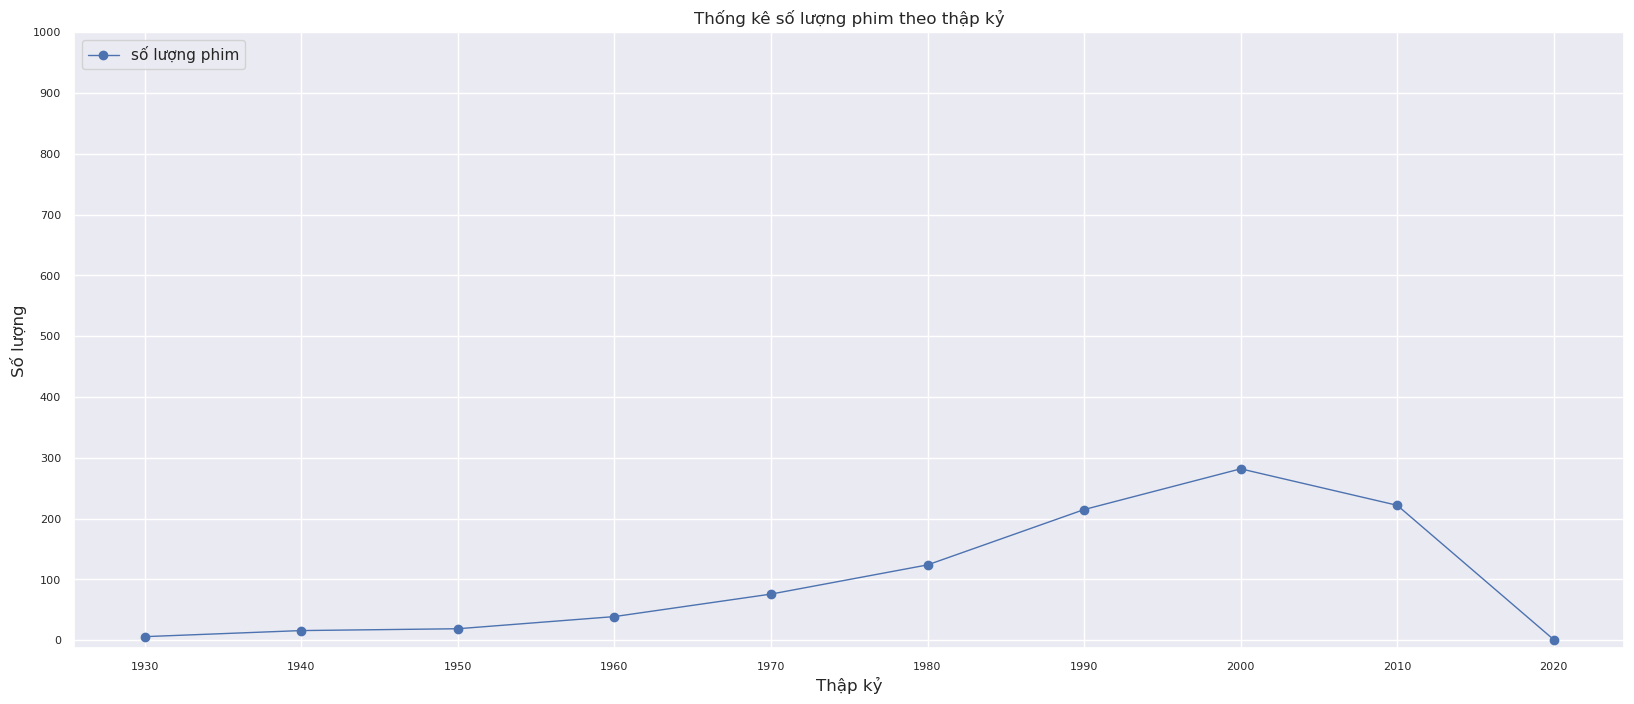

In [39]:
fig =plt.subplots(figsize=(20,8))

decade=np.array(film_decade.keys())
num_film=np.array(film_decade.values)

plt.plot(decade,num_film,marker='o',linestyle='-',linewidth=1,label='số lượng phim')
plt.xlabel('Thập kỷ')
plt.ylabel('Số lượng')
plt.title('Thống kê số lượng phim theo thập kỷ')
plt.xticks(decade,size=8)
plt.yticks(range(0,1001,100),size=8)
plt.legend(loc='upper left')
plt.show()

<h4>Nhận xét:</h4>

- Khi thực hiện đồ án, danh sách tổng hợp cập nhật lần gần nhất là 12/11/2021. Và với tình hình dịch bệnh các năm 2020, 2021 ở trên khắp thế giới, nên ta có thể thấy chỉ có 1 phim [Tenet](https://www.imdb.com/title/tt6723592/) là nằm trong [top 1000 phim](https://www.imdb.com/list/ls006266261/).<br>

- Và ta cũng có thể thấy được sự thay đổi rõ rệt về số lượng phim lọt top từ thập niên 1930 đến thập niên 2000 (tăng dần), tuy nhiên có 1 sự sụt giảm vào thập niên 2010 lúc công nghệ làm phim phát triển hơn hắn những thập niên trước (liệu rằng có yếu tố nào tác động đằng sau, chúng ta sẽ cố trả lời nó vào những phần sau nhé).


**Bước 2**: Thống kê số lượng phim theo thể loại. Ở đây, ta sẽ sử dụng cột `Genres` để tiến hành thống kê.

In [40]:
film_info_df.Genres.explode().unique()

array(['Crime', 'Drama', 'Biography', 'Mystery', 'War', 'History',
       'Thriller', 'Adventure', 'Comedy', 'Sci-Fi', 'Action', 'Sport',
       'Romance', 'Animation', 'Horror', 'Fantasy', 'Western', 'Family',
       'Documentary', 'Music', 'Film-Noir', 'Musical'], dtype=object)

Quan sát trong số các thể loại phim, ta thấy 2 thể loại phim là **Music** và **Musical**. Với 2 cái tên khá giống nhau, liệu rằng có phải dữ liệu đã bị trùng lặp.

Câu trả lời là **không**. Ta sẽ tìm hiểu thêm về 2 thể loại này.

* **Music**: thể loại có liên quan đến âm nhạc ví dụ như một câu chuyện về một bản nhạc, hay đại loại như vậy.</br>
* **Musical**: thể loại nhạc kịch, tràn đầy những bản nhạc, kết hợp với những điệu nhảy cuốn hút người xem.</br>

[Dựa theo](https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG#)


In [41]:
film_genre=film_info_df.Genres.explode().value_counts()
film_genre

Drama          573
Crime          293
Comedy         279
Action         254
Thriller       191
Adventure      181
Mystery        117
Biography      106
Horror          93
Romance         92
Sci-Fi          91
Fantasy         56
Documentary     50
History         34
Animation       34
Music           31
War             24
Sport           23
Family          23
Western         17
Film-Noir        8
Musical          6
Name: Genres, dtype: int64

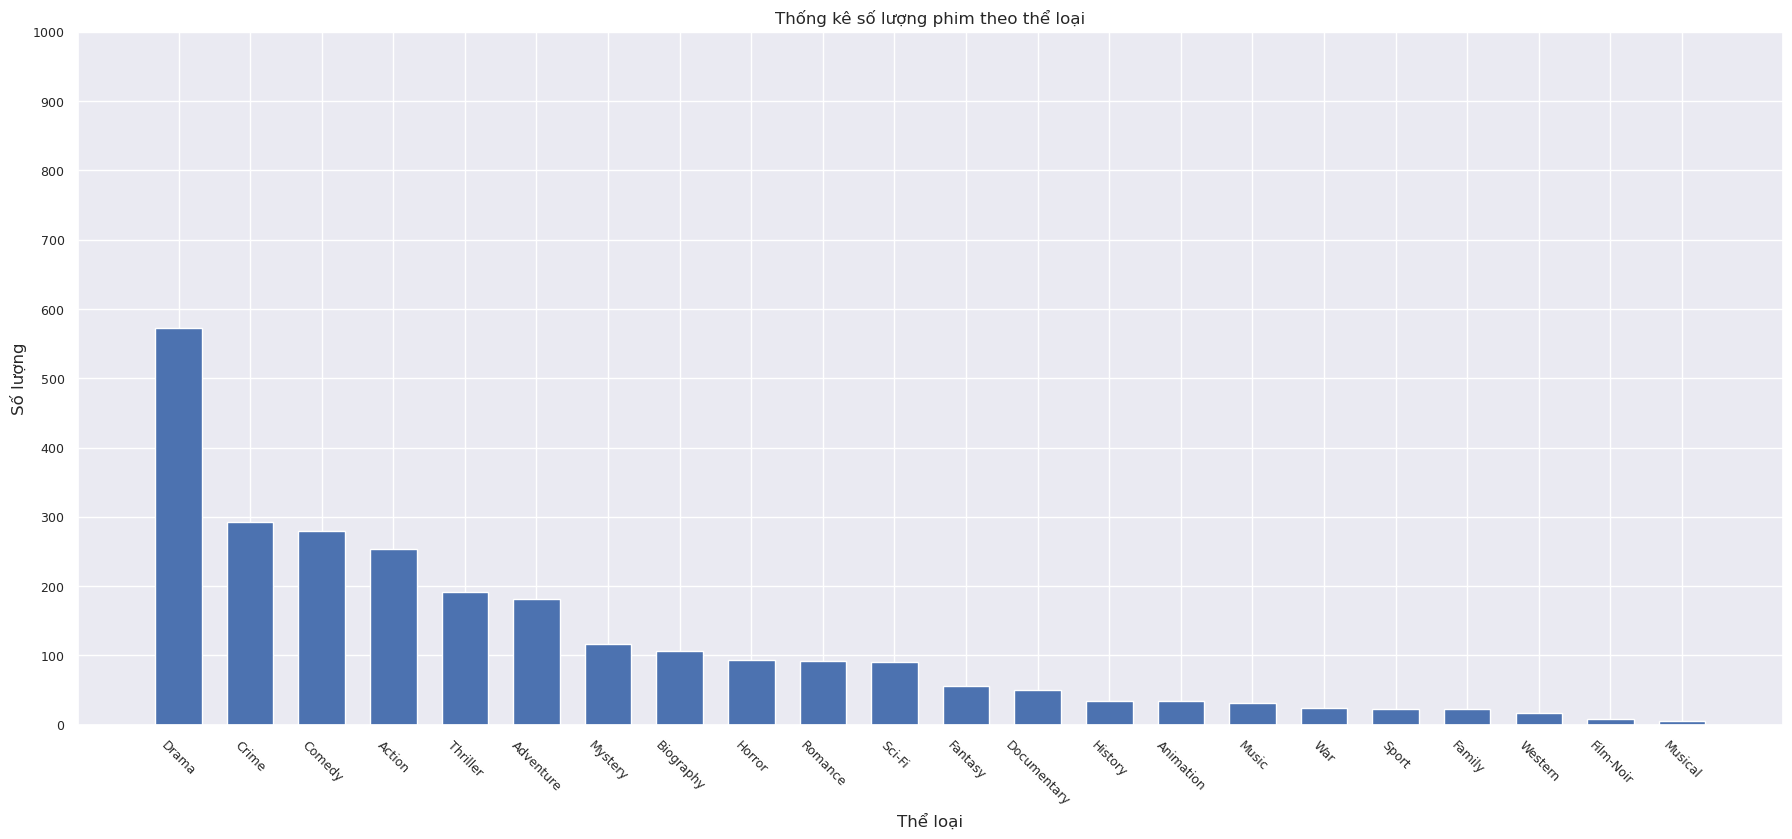

In [42]:
fig =plt.subplots(figsize=(22,9))

genre=np.array(film_genre.keys())
num_film=np.array(film_genre.values)

plt.bar(genre,num_film,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Số lượng')
plt.title('Thống kê số lượng phim theo thể loại')
plt.xticks(genre,size=9)
plt.yticks(range(0,1001,100),size=9)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Ta thấy được xu hướng các phim có thể loại **Drama** chiếm hơn 1 nửa số lượng phim và cũng là thể loại chiếm số lượng cao nhất.
- Tiếp đến là các thể loại phổ biến như: **tội phạm, hài kịch, hành động, giật gân, phiêu lưu** cũng là những thể loại chiếm đa số. Ở đây trừ hài kịch mục đích gây cười, có tính giải trí cao (*điều ai cũng cần*), thì có thể thấy gần như hầu hết đều là những thể loại mạnh mẽ, nhịp độ phim nhanh gây kích thích, hứng thú cho người xem.
- Các thể loại còn lại chỉ chiếm từ 0 đến 10% số lượng phim trong danh sách.

**Bước 3**: Tương quan giữa thể loại phim và các thập niên.

- Không xét thập niên 2020

In [43]:
film_genre_decade=film_info_df[~film_info_df.Decade.isin([2020])].explode('Genres').value_counts(['Decade','Genres']).to_frame().reset_index([0,1])
film_genre_decade

,Decade,Genres,0
0,2000,Drama,169
1,1990,Drama,131
2,2010,Drama,124
3,2000,Crime,82
4,2000,Action,80
...,...,...,...
152,1960,Sport,1
153,1960,Animation,1
154,1960,Fantasy,1
155,1960,History,1


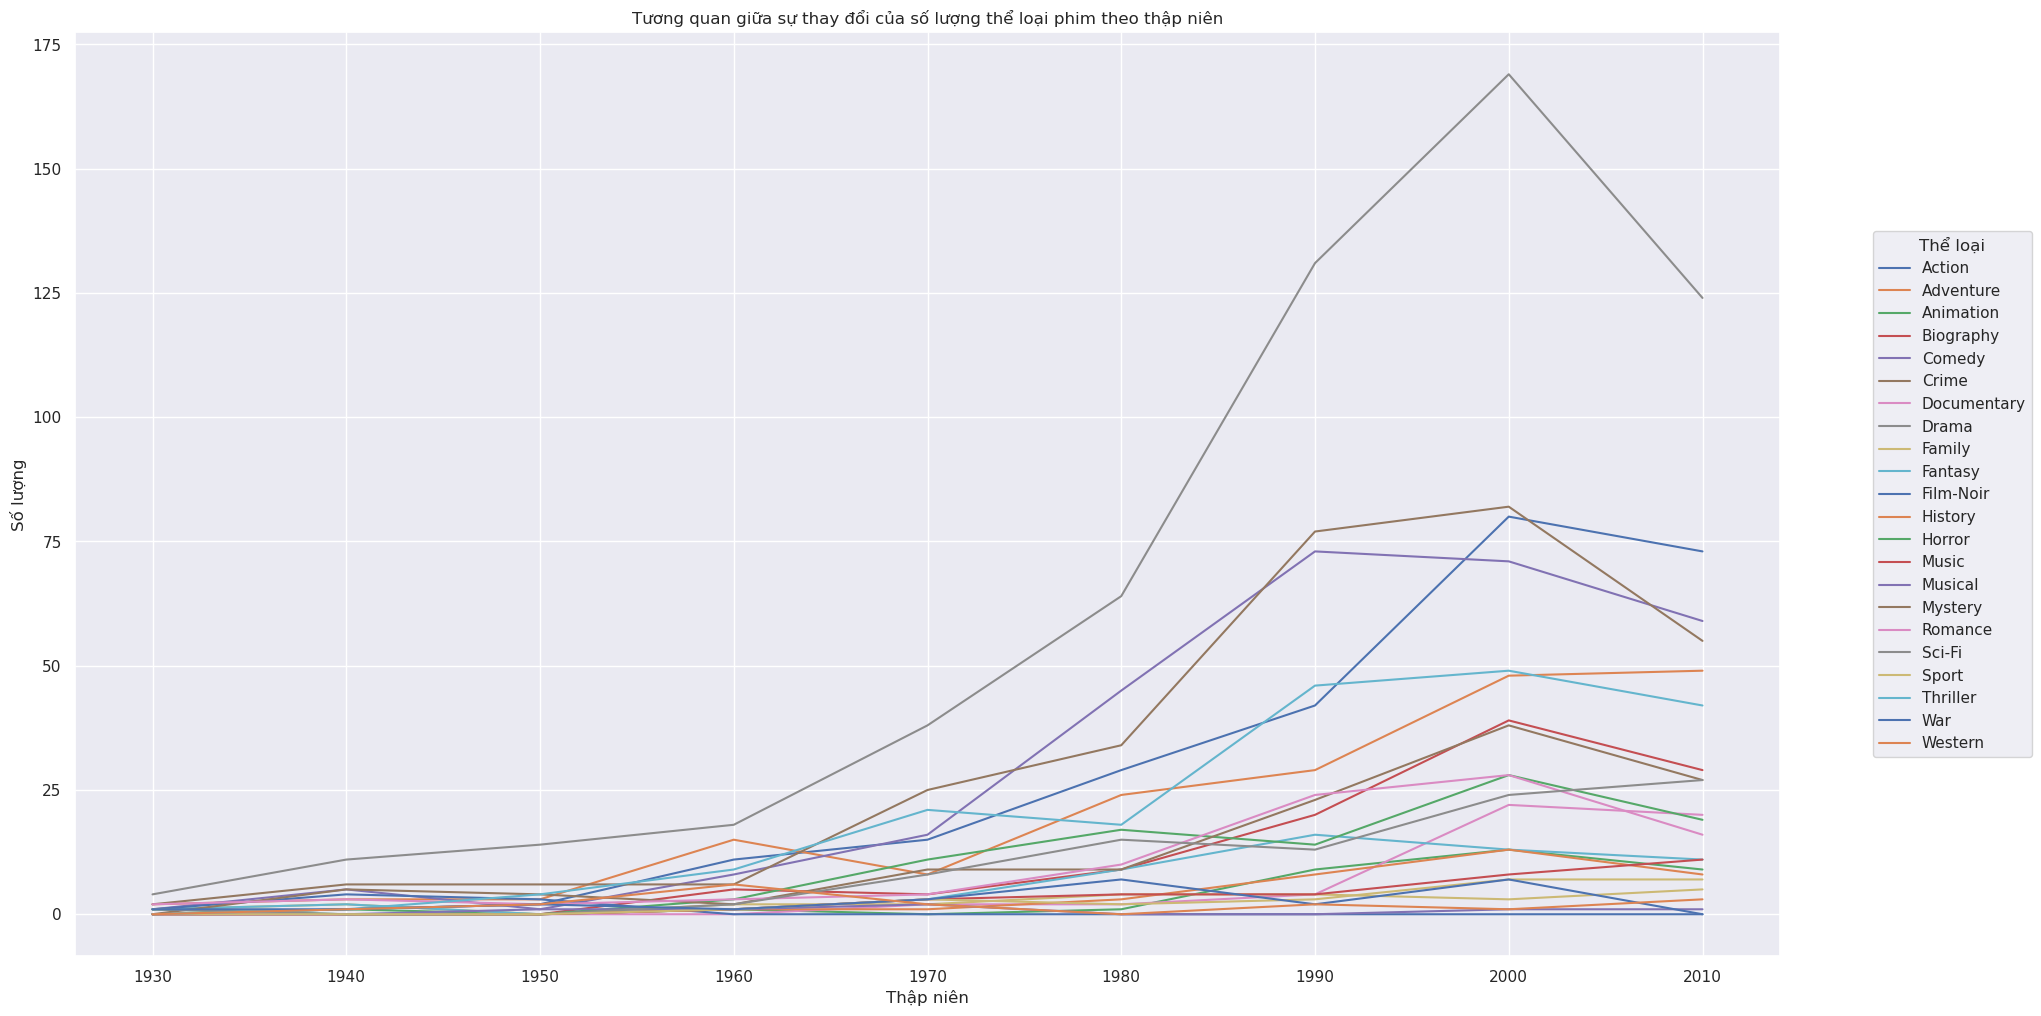

In [44]:
num_film_each_genre=film_genre_decade.pivot('Decade','Genres',0)
num_film_each_genre=num_film_each_genre.sort_index().fillna(0)

fig =plt.subplots(figsize=(22,12))

genre=np.array(film_genre.keys())
num_film=np.array(film_genre.values)

plt.plot(num_film_each_genre)
plt.xlabel('Thập niên')
plt.ylabel('Số lượng')
plt.title('Tương quan giữa sự thay đổi của số lượng thể loại phim theo thập niên')
plt.legend(num_film_each_genre.columns,title='Thể loại',loc='center left',bbox_to_anchor=(1.05,0.5))
plt.show()

<h4>Nhận xét:</h4>

- Ta thấy rằng ở thể loại **Drama** ở mọi thập niên đều đứng đầu trong số lượng phim lọt top.
- Không có sự thay đổi các thể loại: **hành động, hài kịch, phiêu lưu, tội phạm**
- Vì số lượng phim lọt top của thập niên 2010 giảm hơn 1/5 so với thập niên 2000, nên ta có thể thấy rằng chỉ vài thể loại tăng lên. Tuy rằng nhu cầu giải trí mỗi ngày càng cao, số lượng phim sản xuất cũng tăng lên và có nhiều sự khác biệt trong công nghệ làm phim.

**Bước 4**: Tương quan theo những chuẩn khác.

* Xét theo **tổng doanh thu** do thể loại phim đó mang lại

In [45]:
film_info_df.Gross=film_info_df.Gross.replace(np.nan,0)

In [46]:
sum_gross_genres=film_info_df.explode('Genres').groupby('Genres')['Gross'].sum().multiply(10**-7)
sum_gross_genres

Genres
Action         3123.458439
Adventure      2969.915042
Animation       522.219539
Biography       333.077834
Comedy         1795.045785
Crime          1130.544314
Documentary      50.792800
Drama          2736.377711
Family          251.515777
Fantasy         682.477792
Film-Noir         1.705491
History         145.154775
Horror          338.141635
Music           119.770309
Musical          11.823718
Mystery         543.231261
Romance         573.709122
Sci-Fi         1208.727696
Sport            65.319427
Thriller       1067.951572
War             122.148509
Western          81.141154
Name: Gross, dtype: float64

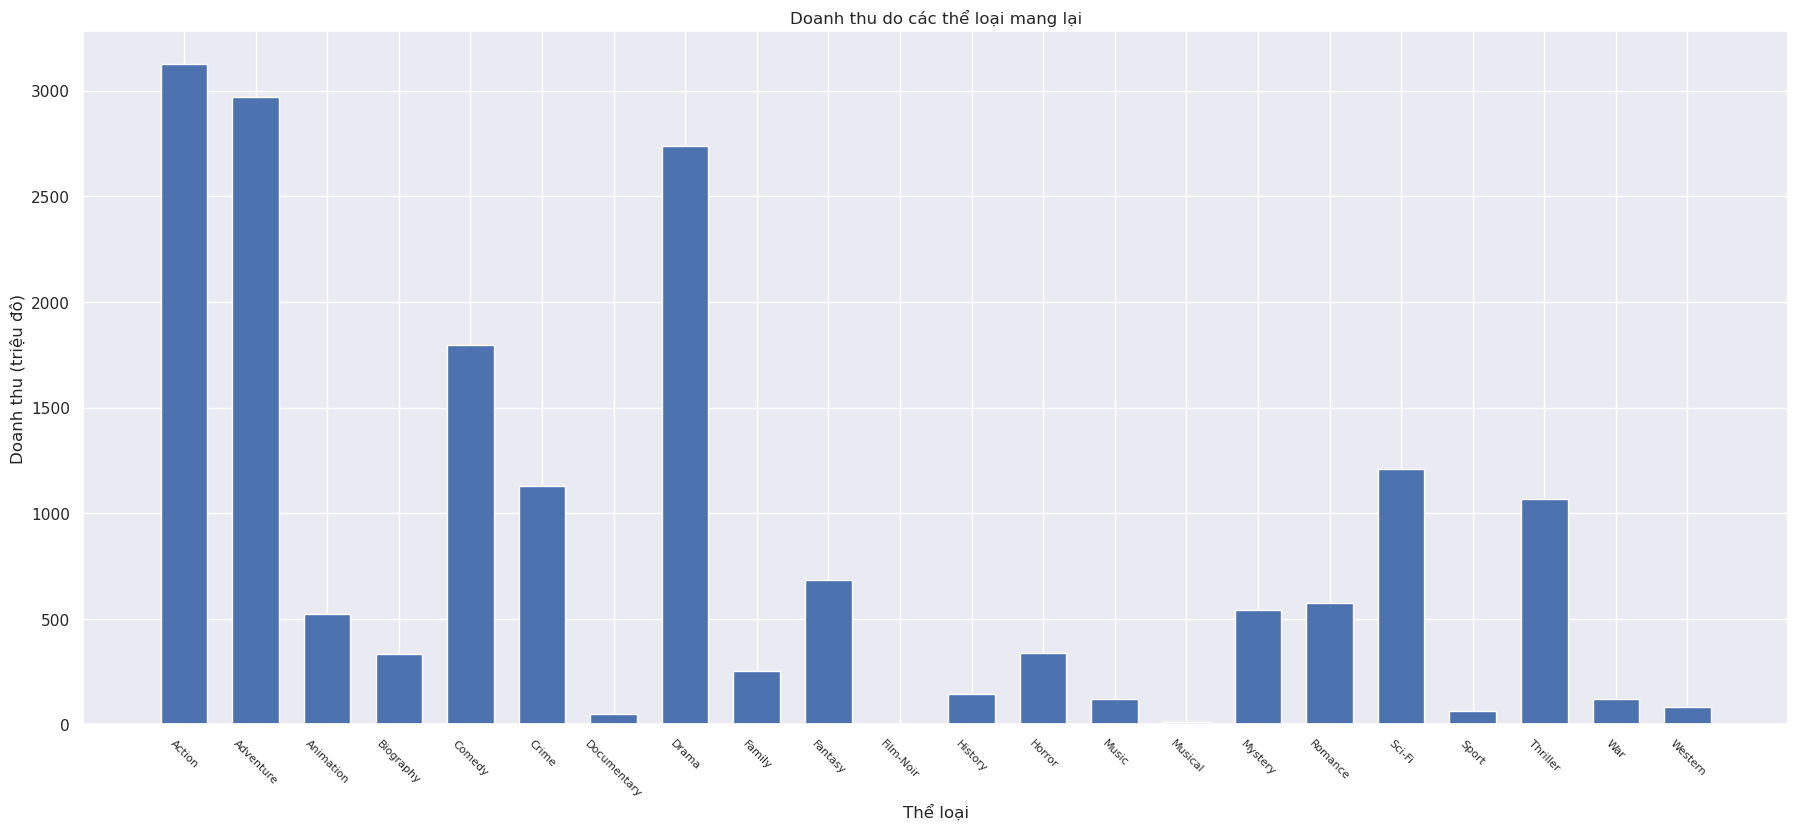

In [47]:
fig =plt.subplots(figsize=(22,9))

genre=np.array(sum_gross_genres.keys())
gross=np.array(sum_gross_genres.values)

plt.bar(genre,gross,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Doanh thu (triệu đô)')
plt.title('Doanh thu do các thể loại mang lại')
plt.xticks(genre,size=8)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Ta thấy được doanh thu mang về của thể loại **Drama** vẫn không cao bằng 2 thể loại cùng đứng top là **Hành động** và **Phiêu lưu**.
- Biểu đồ chỉ mang tính *<b>khách quan</b>* vì có sự thay đổi của tỉ giá tiền tệ theo từng thập niên, và cũng còn một số phim chưa thể tổng hợp được tổng doanh thu.

* Xét theo **số lượng giải thưởng** mà thể loại phim đó đạt được.

In [48]:
film_info_df.Wins.unique()

array(['Won 3 Oscars', 'Won 1 Oscar', 'Won 2 Oscars',
       'Nominated for 1 Oscar', 'Won 7 Oscars', 'Nominated for 3 Oscars',
       'Awards', 'Nominated for 7 Oscars', 'Nominated for 4 Oscars',
       'Won 6 Oscars', 'Won 4 Oscars', 'Won 5 Oscars',
       'Won 2 BAFTA Awards', 'Won 1 BAFTA Award',
       'Nominated for 2 Oscars', 'Won 11 Oscars',
       'Nominated for 1 BAFTA Award', 'Nominated for 5 BAFTA Awards',
       'Nominated for 5 Oscars', 'Won 8 Oscars', 'Nominated for 6 Oscars',
       'Nominated for 2 BAFTA Awards', 'Nominated for 10 Oscars', None,
       'Nominated for 3 BAFTA Awards', 'Nominated for 8 Oscars',
       'Nominated for 2 Primetime Emmys',
       'Nominated for 3 Primetime Emmys', 'Won 2 Primetime Emmys',
       'Nominated for 1 Primetime Emmy'], dtype=object)

In [49]:
film_info_df.Wins.value_counts()

Awards                             421
Nominated for 1 Oscar              116
Won 1 Oscar                        106
Nominated for 2 Oscars              60
Won 2 Oscars                        47
Nominated for 3 Oscars              36
Nominated for 1 BAFTA Award         32
Won 3 Oscars                        26
Won 4 Oscars                        23
Won 1 BAFTA Award                   22
Nominated for 4 Oscars              16
Won 5 Oscars                        16
Nominated for 6 Oscars               9
Nominated for 7 Oscars               8
Nominated for 5 Oscars               7
Won 6 Oscars                         7
Nominated for 2 BAFTA Awards         7
Won 7 Oscars                         5
Won 8 Oscars                         4
Won 11 Oscars                        3
Nominated for 10 Oscars              3
Won 2 BAFTA Awards                   2
Nominated for 3 BAFTA Awards         2
Nominated for 2 Primetime Emmys      1
Nominated for 8 Oscars               1
Nominated for 3 Primetime

Xử lý để tính được tổng số giải mà thể loại đó giành được:
* Ta sẽ chỉ lấy những phim "Won" giải để dễ so sánh
* Với nội dụng trong từng ô của Wins được hiểu như sau: 
    * Ví dụ:
     * **'Won 2 oscars'** là thể loại đó đã thắng được 2 giải.
     * **'Won 11 oscars'** là thể loại đó thắng được 11 giải.

In [50]:
film_won_awards=film_info_df[~film_info_df.Wins.str.findall(r'Won .*').explode().isnull()]
film_won_awards

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,1970,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,1990,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,1990,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,1970,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,978,tt0059742,The Sound of Music,1965,1960,G,172.0,"[Biography, Drama, Family]",[Robert Wise],"[Russel Crouse, Georg Hurdalek, Howard Lindsay]","[Julie Andrews, Eleanor Parker, Christopher Plummer]",8.1,8200000.0,163214286.0,601.0,235440,533.0,134.0,63.0,Won 5 Oscars,/title/tt0059742/
978,979,tt2543164,Arrival,2016,2010,PG-13,116.0,"[Drama, Mystery, Sci-Fi]",[Denis Villeneuve],"[Ted Chiang, Eric Heisserer]","[Forest Whitaker, Jeremy Renner, Amy Adams]",7.9,47000000.0,100546139.0,514.0,694079,2200.0,739.0,81.0,Won 1 Oscar,/title/tt2543164/
980,981,tt4034228,Manchester by the Sea,2016,2010,R,137.0,[Drama],[Kenneth Lonergan],[Kenneth Lonergan],"[Michelle Williams, Casey Affleck, Kyle Chandler]",7.8,9000000.0,47695371.0,1049.0,283474,931.0,515.0,96.0,Won 2 Oscars,/title/tt4034228/
981,982,tt1856101,Blade Runner 2049,2017,2010,R,164.0,"[Action, Drama, Mystery]",[Denis Villeneuve],"[Philip K. Dick, Michael Green, Hampton Fancher]","[Ana de Armas, Ryan Gosling, Harrison Ford]",8.0,150000000.0,92054159.0,150.0,571142,2500.0,564.0,81.0,Won 2 Oscars,/title/tt1856101/


In [51]:
genres_won_awards=film_won_awards.explode('Genres').value_counts(['Genres','Wins']).sort_index().to_frame().reset_index()
print(genres_won_awards)

def sum_awards(vl):
    # num=re.findall(r'\d*',)
    num=int(re.findall(r'\d{1,2}',str(vl))[0])
    return num

temp_count=genres_won_awards.Wins.apply(sum_awards)
genres_won_awards[0]=temp_count*genres_won_awards[0]
genres_won_awards=genres_won_awards.groupby('Genres')[0].sum()
print(genres_won_awards)

      Genres               Wins   0
0     Action  Won 1 BAFTA Award   5
1     Action        Won 1 Oscar  17
2     Action      Won 11 Oscars   1
3     Action       Won 2 Oscars  11
4     Action       Won 3 Oscars   6
..       ...                ...  ..
133      War       Won 8 Oscars   1
134  Western       Won 2 Oscars   1
135  Western       Won 3 Oscars   1
136  Western       Won 4 Oscars   1
137  Western       Won 7 Oscars   1

[138 rows x 3 columns]
Genres
Action         119
Adventure      172
Animation       26
Biography       93
Comedy         107
Crime          117
Documentary     11
Drama          488
Family          30
Fantasy         38
Film-Noir        4
History         36
Horror          11
Music           24
Musical          2
Mystery         32
Romance         92
Sci-Fi          47
Sport           11
Thriller        80
War             41
Western         16
Name: 0, dtype: int64


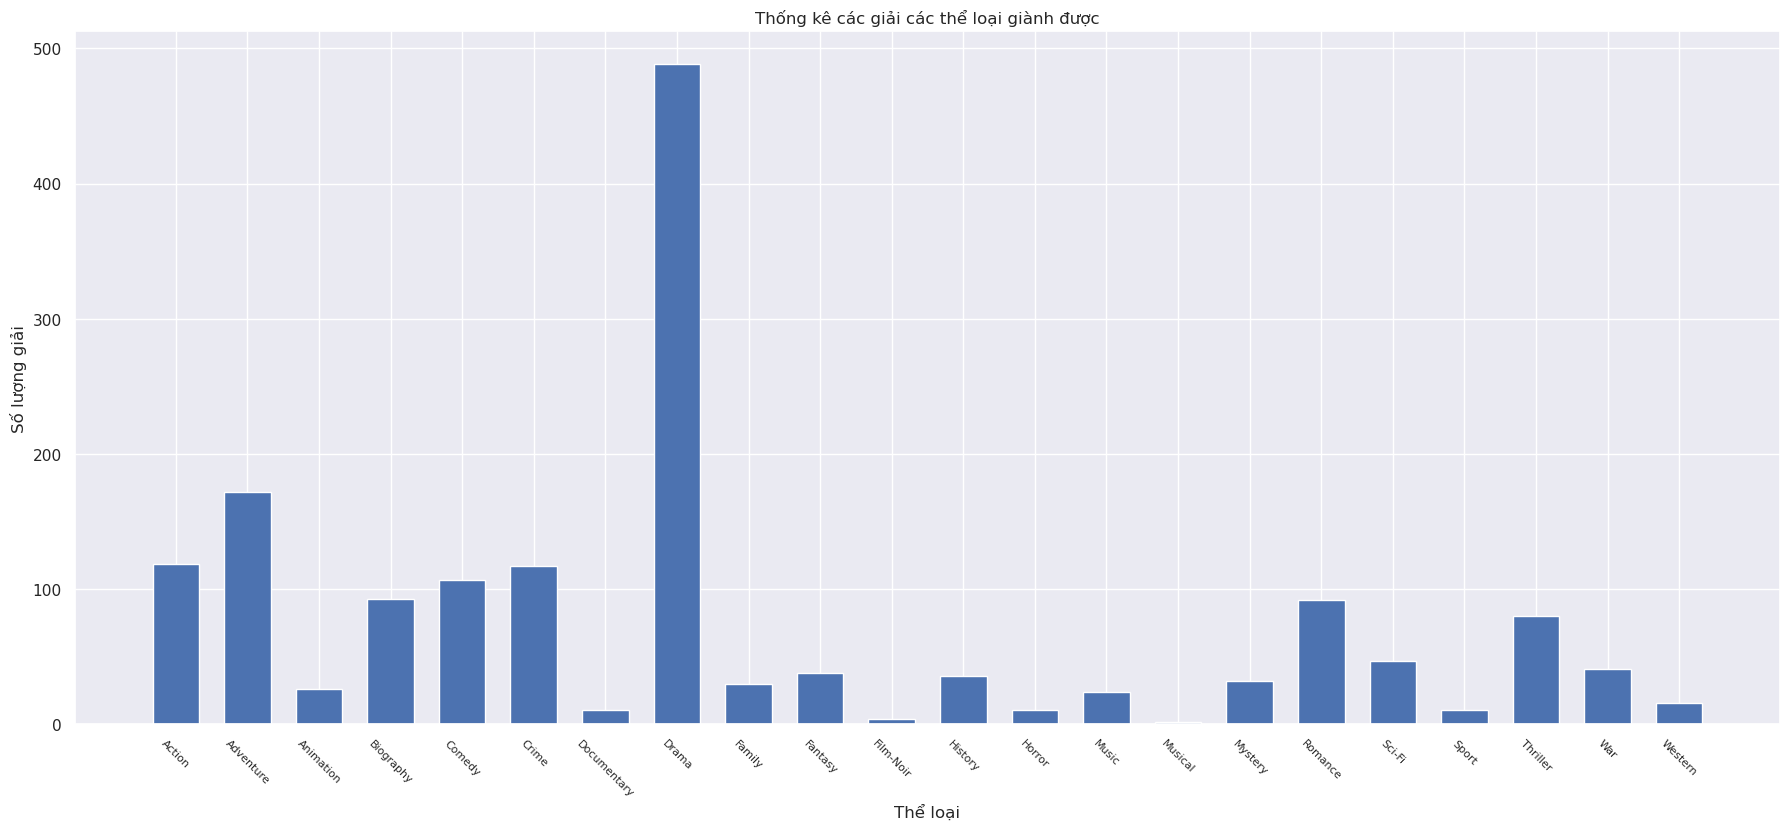

In [52]:
fig =plt.subplots(figsize=(22,9))

genre=np.array(genres_won_awards.keys())
sum_awards=np.array(genres_won_awards.values)

plt.bar(genre,sum_awards,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Số lượng giải')
plt.title('Thống kê các giải các thể loại giành được')
plt.xticks(genre,size=8)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Nhìn vào biểu đồ trên ta đã hoàn toàn thấy sự khác biệt số lần thắng giải của thể loại **Chính kịch** (Drama), gấp hơn 2.5 lần so với các thể loại cùng đứng top trên.

*[Giải thích lý do chính kịch là phim được nhiều người yêu thích](https://filmstutamlang.wordpress.com/2016/11/25/dinh-nghia-ve-phim-chinh-kich/).*

#### **Kết luận:**

- Thể loại được yêu thích nhất mọi thập niên: **Chính kịch** (Drama)
- Top các thể loại yêu thích kế tiếp *(không mang tính thứ tự - Vì mỗi thập niên có sự thay đổi qua lại vị trí giữa những thể loại đó)*: **Phiêu lưu, Tội phạm, Hài kịch, Hành động**.
- Thể loại mang về nhiều giải thưởng nhất: **Chính kịch** (Drama)
</h3>


### **Câu 2: Tìm hiểu xem top 5 đạo diễn xuất hiện nhiều nhất trong Dataset. Xuất hiện nhiều đồng nghĩa với việc họ sở hữu số lượng phim áp đảo những đạo diễn còn lại. Liệu rằng số phim mà các đạo diễn này sản xuất ra có thực sự là một bộ phim chất lượng (đánh giá dựa trên các nhà phê bình có chuyên môn - Meta score).**

**Ý nghĩa khi trả lời câu hỏi:** 
* Ta sẽ biết được về các đạo diễn gạo cội, những người tạo ra những bộ phim để đời.
* Ngoài ra, còn biết thêm việc, liệu những đạo diễn này có thật sự sản xuất ra những bộ phim chất lượng hay không. 


**Nguồn cảm hứng đặt câu hỏi:** 
* Cảm hứng bắt nguồn từ sự tò mò của bản thân, vì em nghĩ, nếu các đạo diễn này tham gia vào nhiều phim thì sẽ có hai hướng suy nghĩ. Một là, đạo diễn này thật sự là một đạo diễn tài năng và việc sản xuất ra được những bộ phim "chất lượng" lọt top là điều hiển nhiên. Hai là, đạo diễn này có được nhiều nguồn đầu tư nên mời được những diễn viên nổi tiếng, gạo cội nhờ đó làm phim được quan tâm nhiều hơn. Do đó tần suất xuất hiện cũng nhiều hơn. Và để làm rõ điều đó. Em mới đặt ra câu hỏi này.

**Để hỗ trợ câu hỏi này, ta sẽ tìm hiểu một số thông tin sau:** 

* Bộ điểm số của Metacritic được gọi là **Metascores**, là những giá trị trung bình có trọng số. Một số xuất bản phẩm nhất định sẽ có trọng số cao hơn "đơn giản chỉ dựa vào việc chúng có tầm cỡ". Metacritic thu thập đánh giá của các nhà phê bình phim và các trang đánh giá phim sau đó cho điểm các đánh giá này từ 0 đến 100 điểm.
* Ở Metacritic, các tác phẩm được đánh giá hiển thị theo 3 màu: đỏ - vàng – xanh lá. Trong đó, màu đỏ dành cho các phim được cho là không hay. Màu vàng dành cho phim ở mức trung bình (có nhiều sạn, có điểm chưa hợp lý, diễn xuất chưa tốt,…). Màu xanh là phim được cho là hay.
* Do sự đánh giá tới từ các chuyên gia uy tín nên nó có sự đáng tin cậy hơn về mặt nhìn nhận nghệ thuật nhưng lại mang tính chủ quan khá nhiều khi không có cái nhìn đa chiều.

|Màu sắc|<center>Đánh giá</center>|Phim/Chương trình TV/Nhạc | 
|--|--|:------:| 
|Xanh lá|Universal acclaim (Hoan nghênh nhiệt liệt)|81-100|
|Xanh lá|Generally favorable (Nhìn chung là ý kiến tán thành)| 61-80|
|Vàng|Mixed or average (Hỗn tạp hoặc trung bình)|40-60
|Đỏ|Generally unfavorable (Nhìn chung là ý kiến không tán thành)|20-39|
|Đỏ|Overwhelming dislike (Hoàn toàn không thích)|0-19|
    
* Tham khảo:
    * https://vi.wikipedia.org/wiki/Metacritic
    * https://spiderum.com/bai-dang/Tieu-chi-cham-diem-cua-IMDb-Rotten-Tomatoes-va-Metacritic-cp3
    
    * https://hoahoctro.tienphong.vn/la-tin-do-dien-anh-nhung-ban-da-hieu-het-ve-quyen-luc-cua-cac-trang-phe-binh-phim-post1208028.tpo

**Bước 1**: Ta sẽ tìm ra top 5 đạo diễn xuất hiện nhiều nhất trong Dataframe `film_info_df` và lưu vào list `top5_director`

In [53]:
top5_director = film_info_df.Director.explode().value_counts()[:5].index.to_list()
top5_director

['Martin Scorsese',
 'Steven Spielberg',
 'Joel Coen',
 'Ethan Coen',
 'Christopher Nolan']

**Bước 2**: Tiếp theo, ta sẽ lọc từ Dataframe những phim mà các đạo diễn này tham gia sản xuất. Sau đó tiếp tục dùng `groupby()` để gom các phim theo đạo diễn sản xuất.

In [54]:
films = film_info_df[['Director', 'Name']].copy()
films = films.explode('Director')
films = films.groupby('Director')['Name'].apply(list).to_frame().reset_index()
films

,Director,Name
0,Aaron Moorhead,[Spring]
1,Aaron Sorkin,[Molly's Game]
2,Abel Ferrara,"[King of New York, Bad Lieutenant, The Funeral, The Addiction]"
3,Adam Elliot,[Mary and Max]
4,Adam McKay,"[Anchorman: The Legend of Ron Burgundy, The Other Guys]"
...,...,...
574,Woody Allen,"[Annie Hall, Love and Death, Manhattan, Midnight in Paris, Sleeper]"
575,Yorgos Lanthimos,[The Lobster]
576,Zach Braff,[Garden State]
577,Zack Snyder,[Watchmen]


**Bước 3**: Ta lọc ra những đạo diễn thuộc top 5 cùng với danh sách tên phim của họ và lưu trữ trong Dataframe `top5dir_films`.

In [55]:
top5dir_films = pd.DataFrame()

# Lọc ra top 5 đạo diễn cùng phim
for i in range(len(top5_director)):
    top5dir_films = top5dir_films.append(films[['Director', 'Name']][films['Director'] == top5_director[i]])

# Xử lý cho dataframe cho dễ quan sát
top5dir_films.reset_index(inplace=True)
top5dir_films.drop('index', inplace=True, axis=1)
top5dir_films

,Director,Name
0,Martin Scorsese,"[Goodfellas, Taxi Driver, Raging Bull, The Departed, Casino, The Color of Money, The Wolf of Wal..."
1,Steven Spielberg,"[Schindler's List, Jaws, Indiana Jones and the Raiders of the Lost Ark, Jurassic Park, Saving Pr..."
2,Joel Coen,"[Fargo, The Big Lebowski, Miller's Crossing, No Country for Old Men, O Brother, Where Art Thou?,..."
3,Ethan Coen,"[Fargo, The Big Lebowski, Miller's Crossing, No Country for Old Men, O Brother, Where Art Thou?,..."
4,Christopher Nolan,"[The Dark Knight, The Prestige, Batman Begins, Memento, Inception, Insomnia, The Dark Knight Ris..."


**Bước 4:** Ta sẽ lấy các phim của từng đạo diễn ra, đồng thời bổ sung thêm thông tin cần thiết là `Meta score` và lưu trữ trong DataFrame mới.

In [56]:
def get_info(name_column, df):
    tmp = list()
    for i in range(len(df)):
        for j in range(len(film_info_df)):
            if (df['Name'][i] == film_info_df['Name'][j]):
                if(film_info_df['Meta score'][j] is not np.nan):
                    tmp.append(film_info_df[name_column][j])
                else:
                    tmp.append(0)
                
    return tmp

In [57]:
def each_director_analysis(name):
    director = top5dir_films['Name'][top5dir_films['Director'] == name]
    director = director.explode().to_frame().reset_index()
    director.drop('index', inplace=True, axis=1)

    # Bổ sung thông tin cột Meta score
    meta_scr = get_info('Meta score', director)
                
    director['Meta score'] = meta_scr
#     director = director.groupby('Decade')['Meta score'].mean()
    return director

In [58]:
Martin_Scorsese = each_director_analysis('Martin Scorsese')
Steven_Spielberg = each_director_analysis('Steven Spielberg')
Joel_Coen = each_director_analysis('Joel Coen')
Ethan_Coen = each_director_analysis('Ethan Coen')
Christopher_Nolan = each_director_analysis('Christopher Nolan') 

# Output mẫu cho phần này
Martin_Scorsese

,Name,Meta score
0,Goodfellas,90.0
1,Taxi Driver,94.0
2,Raging Bull,89.0
3,The Departed,85.0
4,Casino,73.0
5,The Color of Money,77.0
6,The Wolf of Wall Street,75.0
7,Hugo,83.0
8,The Irishman,94.0
9,The Aviator,77.0


**Bước 5**: Ở bước này, ta sẽ tiến hành phân loại điểm Meta score của mỗi phim dựa màu sắc như đã giới thiệu ở phần đầu. Sở dĩ ta cần làm bước này để tiện cho phần visualize phân tích.

In [59]:
def clasify_metascore(df):
    color = list()
    for i in range (len(df)):
        if ((df['Meta score'][i] >= 81 and df['Meta score'][i] <= 100)
            or (df['Meta score'][i] >= 61 and df['Meta score'][i] <= 80)):
                color.append("Green")
        elif (df['Meta score'][i] >= 40 and df['Meta score'][i] <= 60):
                color.append("Yellow")
        else:
                color.append('Red')
    df['Color'] = color
    return df

In [60]:
Martin_Scorsese = clasify_metascore(Martin_Scorsese)
Steven_Spielberg = clasify_metascore(Steven_Spielberg)
Joel_Coen = clasify_metascore(Joel_Coen)
Ethan_Coen = clasify_metascore(Ethan_Coen)
Christopher_Nolan = clasify_metascore(Christopher_Nolan)

# Output mẫu cho phần này
Martin_Scorsese

,Name,Meta score,Color
0,Goodfellas,90.0,Green
1,Taxi Driver,94.0,Green
2,Raging Bull,89.0,Green
3,The Departed,85.0,Green
4,Casino,73.0,Green
5,The Color of Money,77.0,Green
6,The Wolf of Wall Street,75.0,Green
7,Hugo,83.0,Green
8,The Irishman,94.0,Green
9,The Aviator,77.0,Green


**Bước 6**: Ta sẽ tiến hành dùng Bar chart để visualize điểm Meta của các phim của mỗi đạo diễn. Ta sẽ thể hiện các cột theo màu sắc phân loại được từ điểm Meta score. Để vừa quan sát được đánh giá theo Metacritic và vừa quan sát được điểm của phim.

In [61]:
def draw_barchart(df,name):
    fig = plt.subplots(figsize =(25, 10))
    ax = plt.bar(df['Name'], df['Meta score'], color = df['Color'], width = 0.5)

    plt.title('Điểm Metascore của các phim được sản xuất bởi ' + str(name) , fontsize = 15, fontweight="bold")
    plt.xlabel('Tên phim', fontsize = 15)
    plt.ylabel('Điểm', fontsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

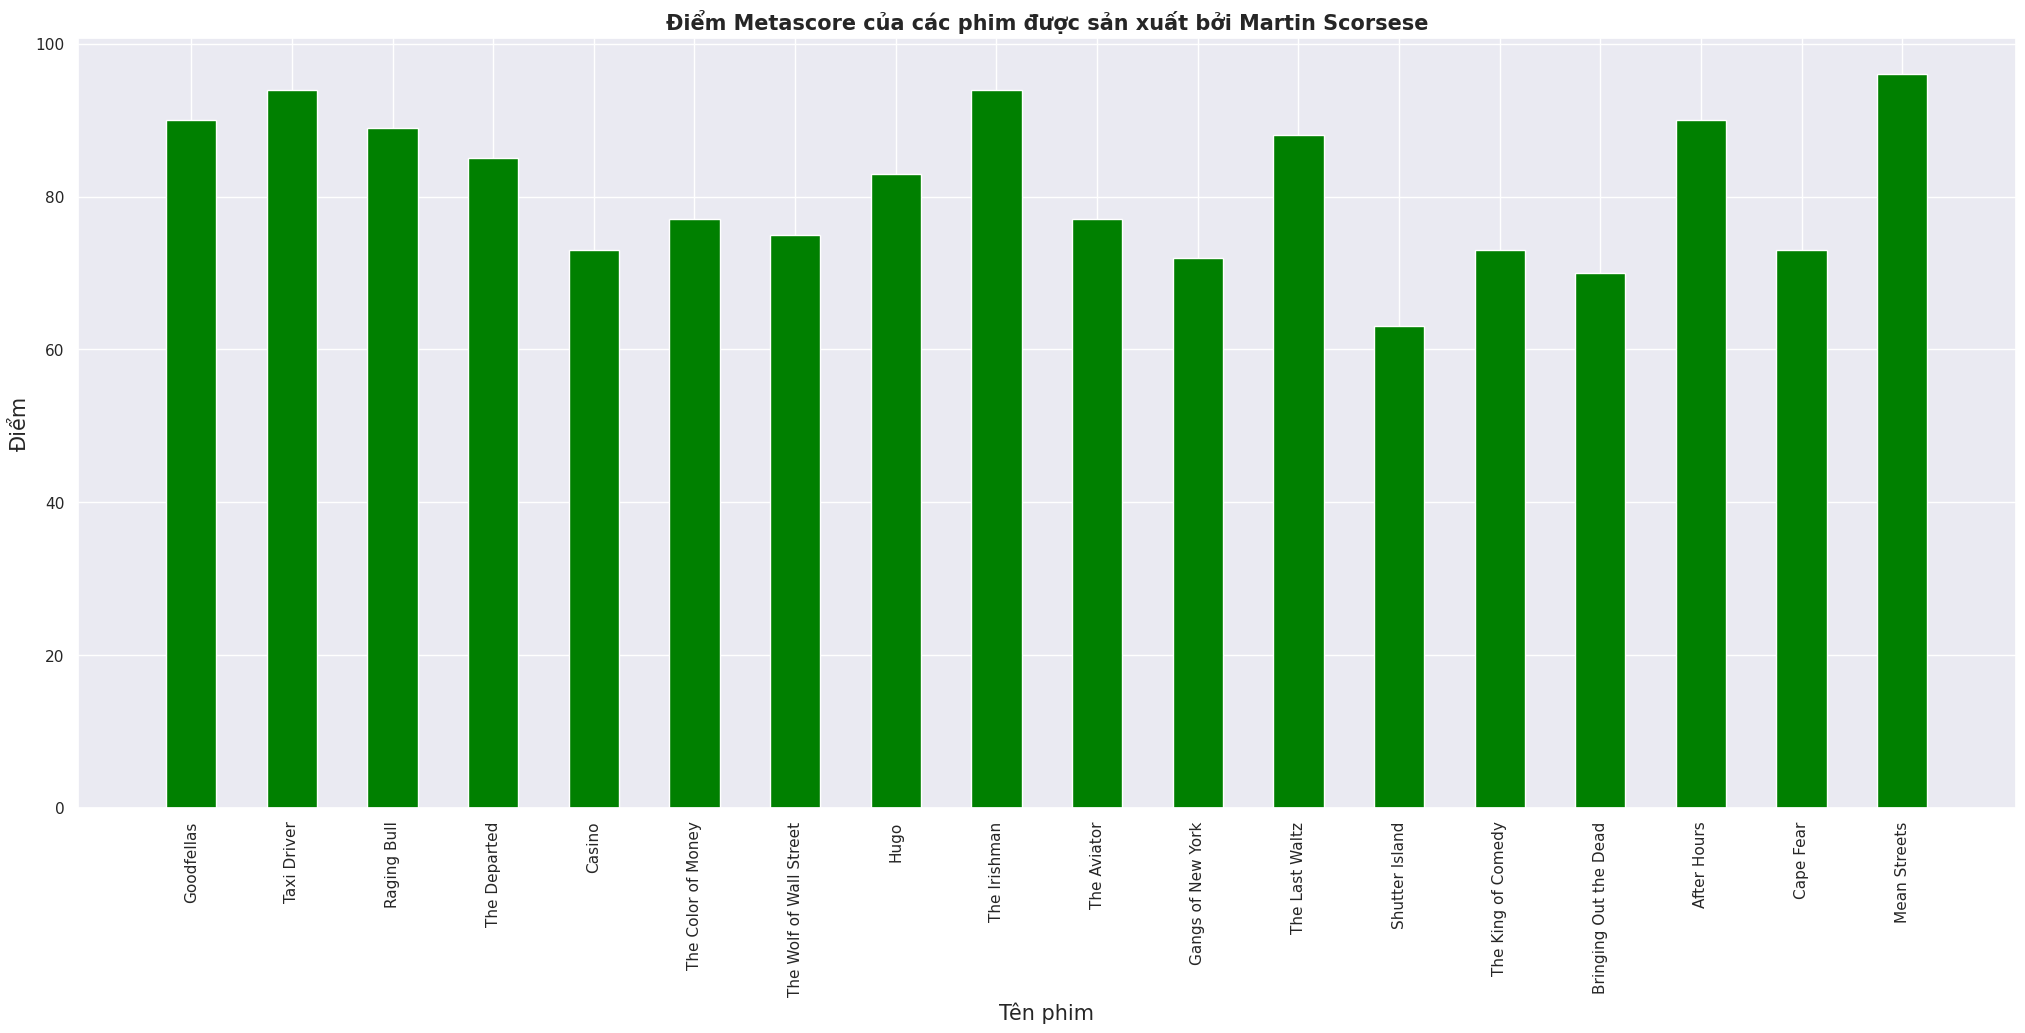

In [62]:
draw_barchart(Martin_Scorsese, 'Martin Scorsese')

#### **Nhận xét:**

* Ta để ý thấy, trong top 5, số phim của đạo diễn Martin Scorsese chiếm áp đảo với 18 phim. 
* Ta thấy, tất cả các cột trong biểu đồ đều là màu xanh, đều đó chứng tỏ những phim mà đạo diễn này sản xuất đều được các chuyên gia đánh giá cao. 
* Đa số các phim của đạo diễn này đều nhận về số điểm trên 70.


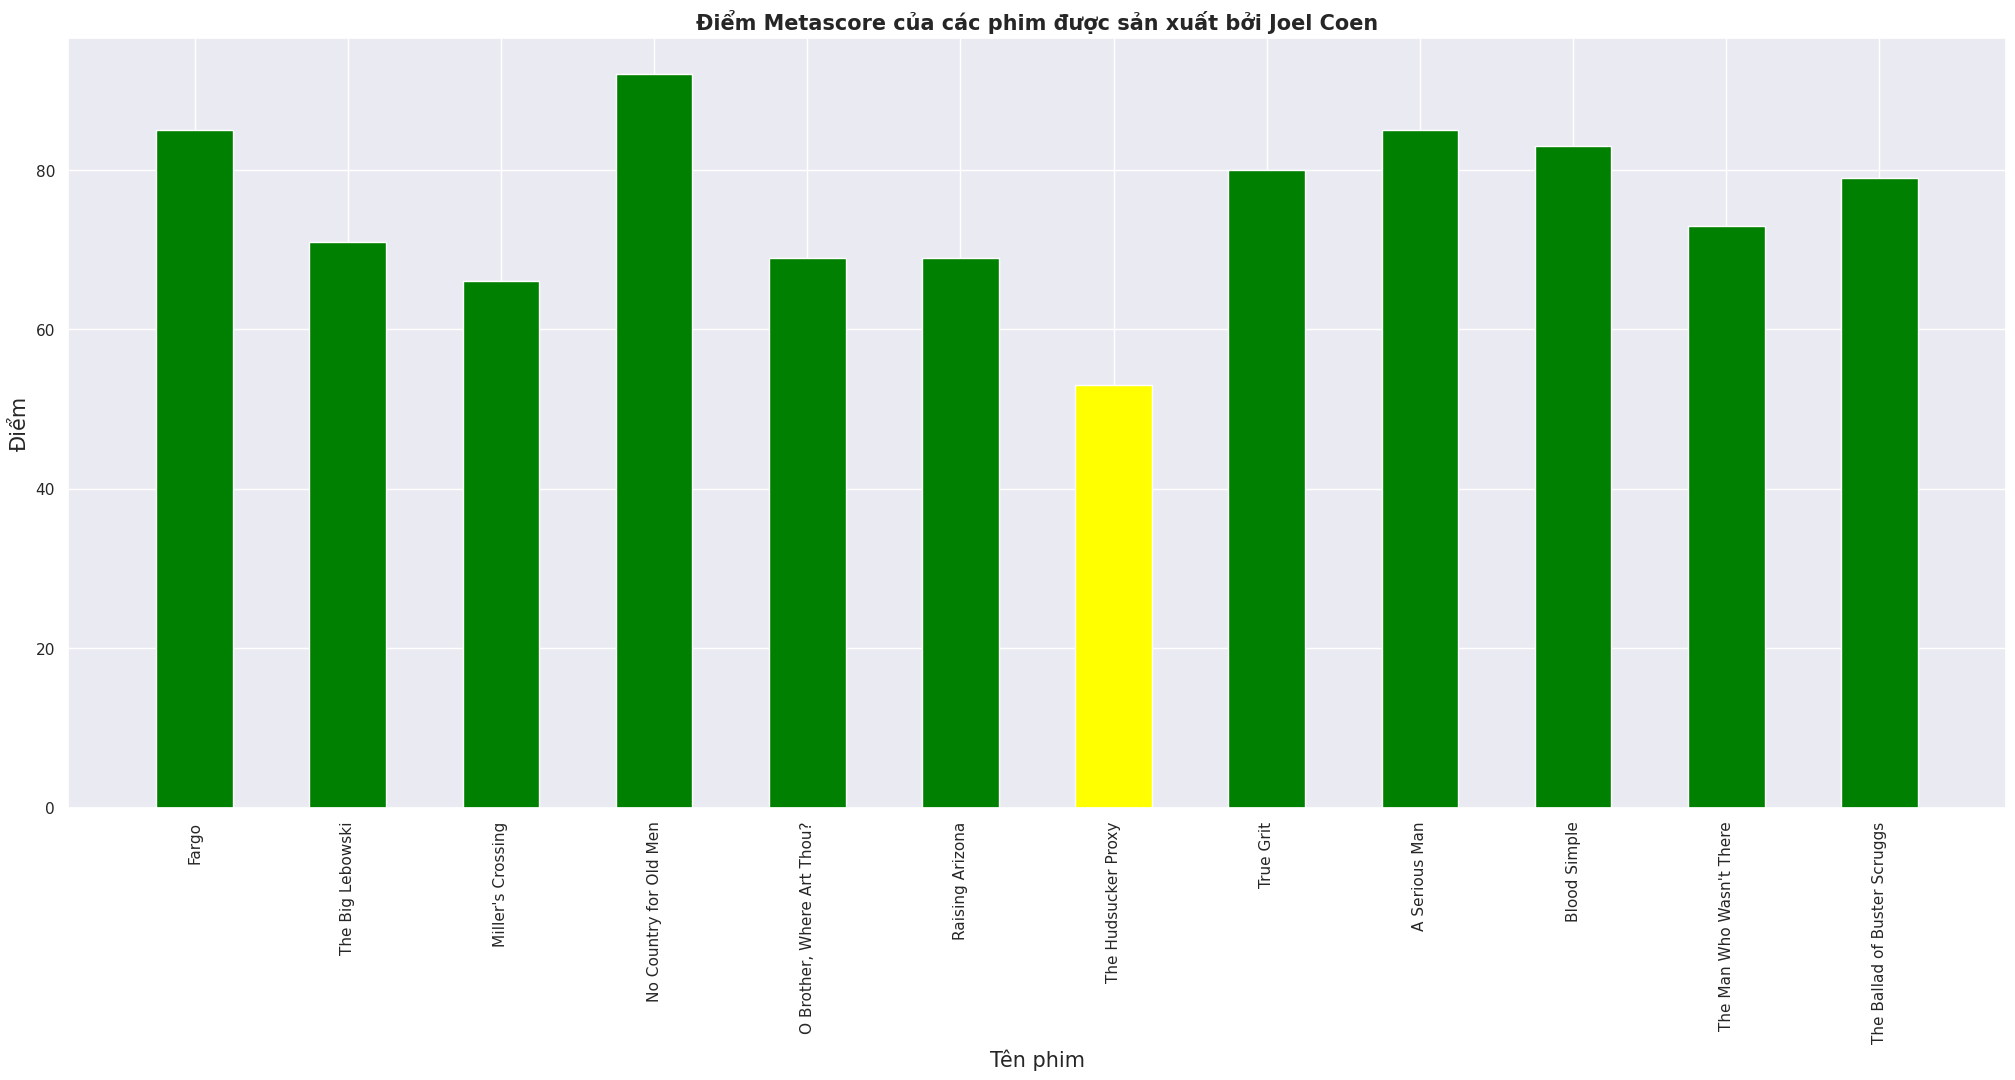

In [63]:
draw_barchart(Joel_Coen, 'Joel Coen')

#### **Nhận xét:**

* Số phim của đạo diễn Joel Coen hầu hết đều đạt được điểm thuộc phân loại xanh lá trừ phim **The Hudsucker Proxy**. Ta sẽ tìm hiểu thêm một chút lí do tại sao phim này lại rớt xuống phân loại điểm vàng.
    * **The Hudsucker Proxy** được sản xuất vào năm 1994.
    * Trên nền tảng Metacritic, phim này được tổng cộng 19 nhà phê bình có chuyên môn nhận xét. Phim đã nhận về 8 phiếu positive (xanh lá), 8 phiếu mixed (vàng) và 3 phiếu negative (đỏ). Và vì tồn tại 3 phiếu negative cộng thêm 8 phiếu mixed đã kéo trung bình của phim này xuống mức điểm trung bình.

* Nhưng đa số, các phim của đạo diễn này đều trên mức 60 điểm, xếp vào hạng được đông đảo các nhà phê bình tán thành.

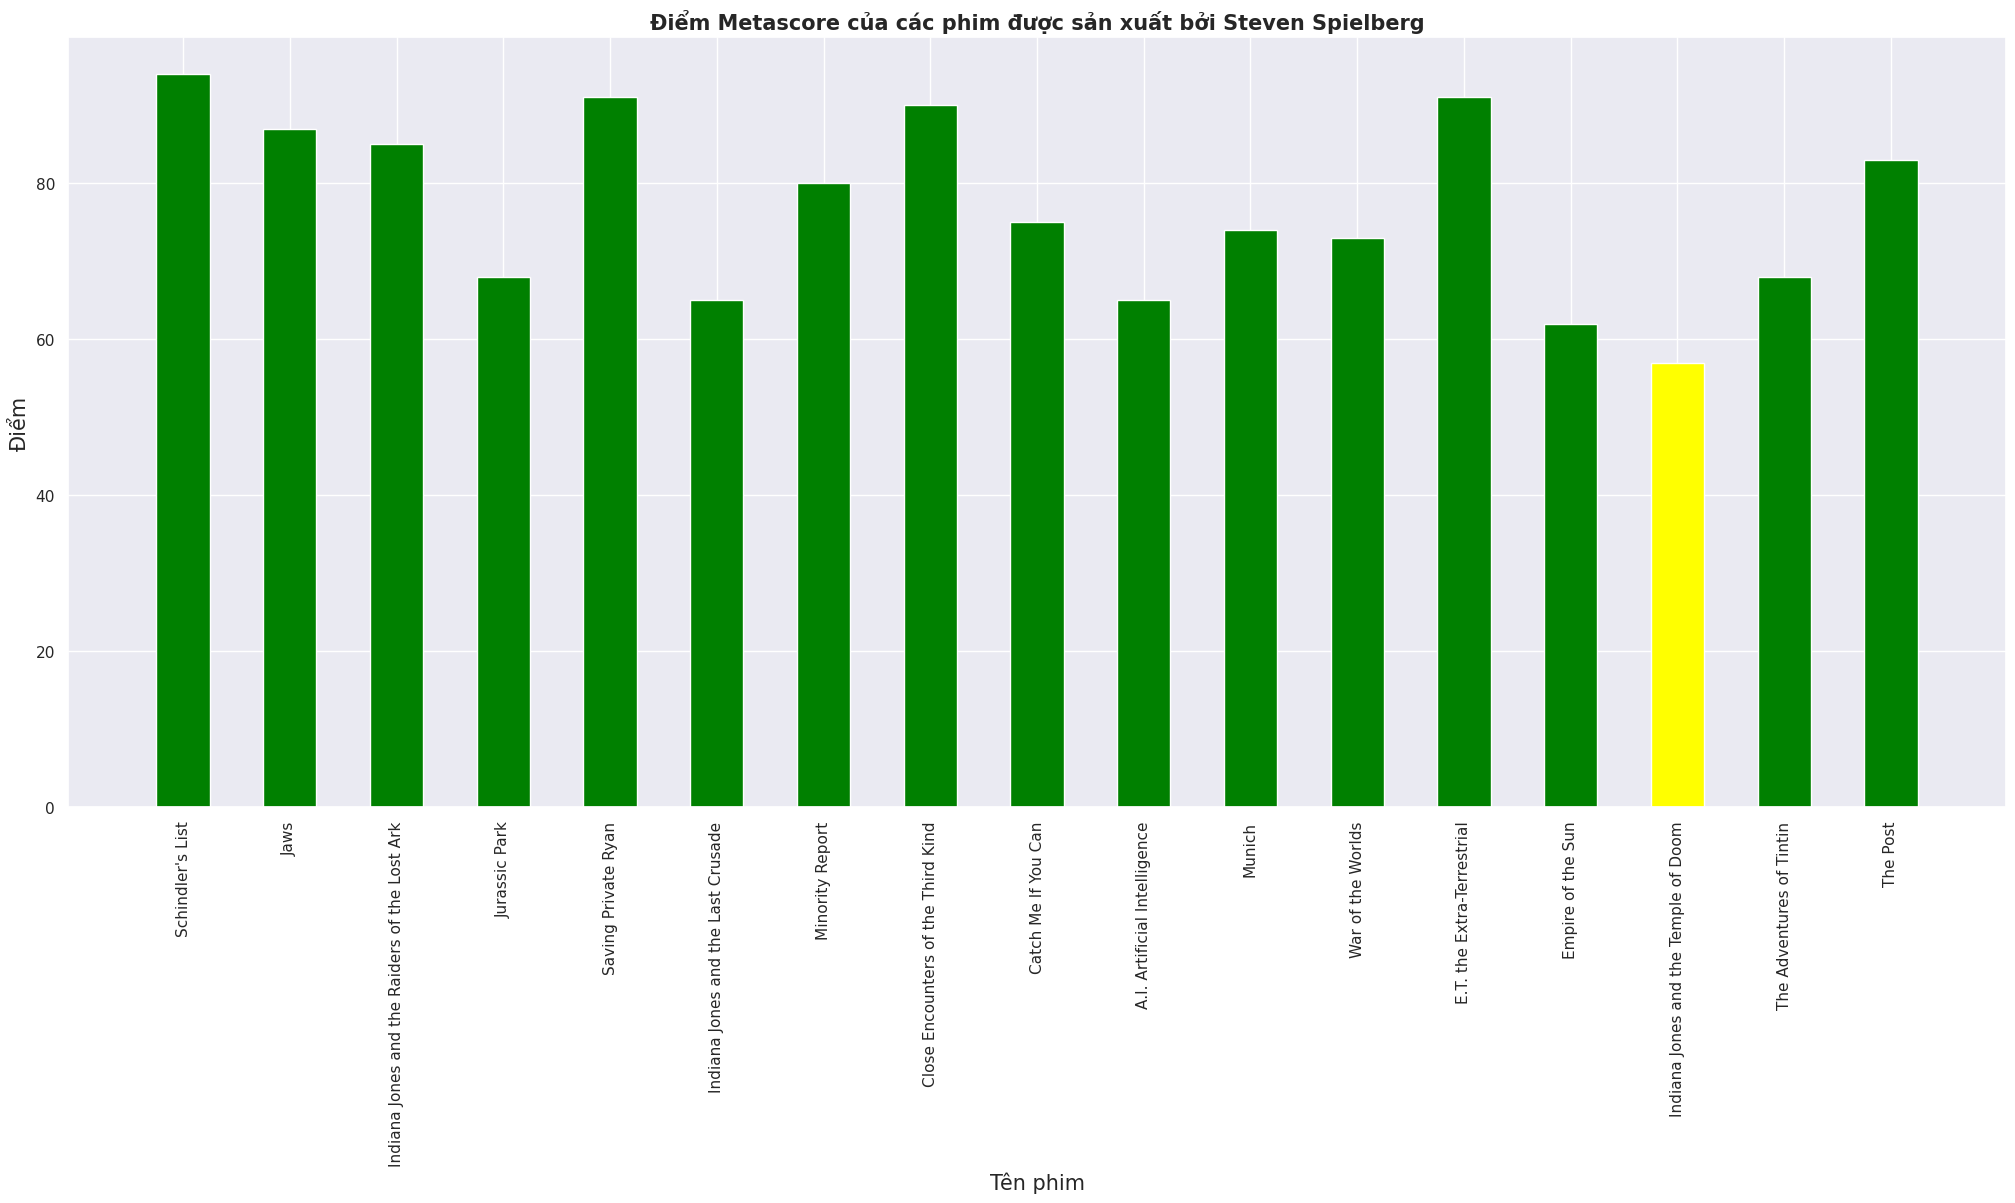

In [64]:
draw_barchart(Steven_Spielberg, 'Steven Spielberg')

#### **Nhận xét:**
* Đạo diễn Steven Spielberg sở hữu 17 phim trong bảng 1000 phim xuất sắc mọi thời đại, tất cả các phim đều nhận được phân loại điểm xanh lá trừ phim **Indiana Jones and the Temple of Doom**. Ta tìm hiểu thử xem, chuyện gì đã xảy ra khiến phim này rớt hạng so với những phim còn lại.
    * **Indiana Jones and the Temple of Doom** thuộc thể loại phim hành động và phiêu lưu, điểm Meta score của phim này là 57 được tổng cộng 14 nhà phê bình có chuyên môn đánh giá, lần lượt nhận được: 7 phiếu positive, 6 phiếu mixed và 1 phiếu negative. Do số lượng mixed và negative ngang bằng với số lượng positive nên đã kéo phim xuống hạng trung bình.

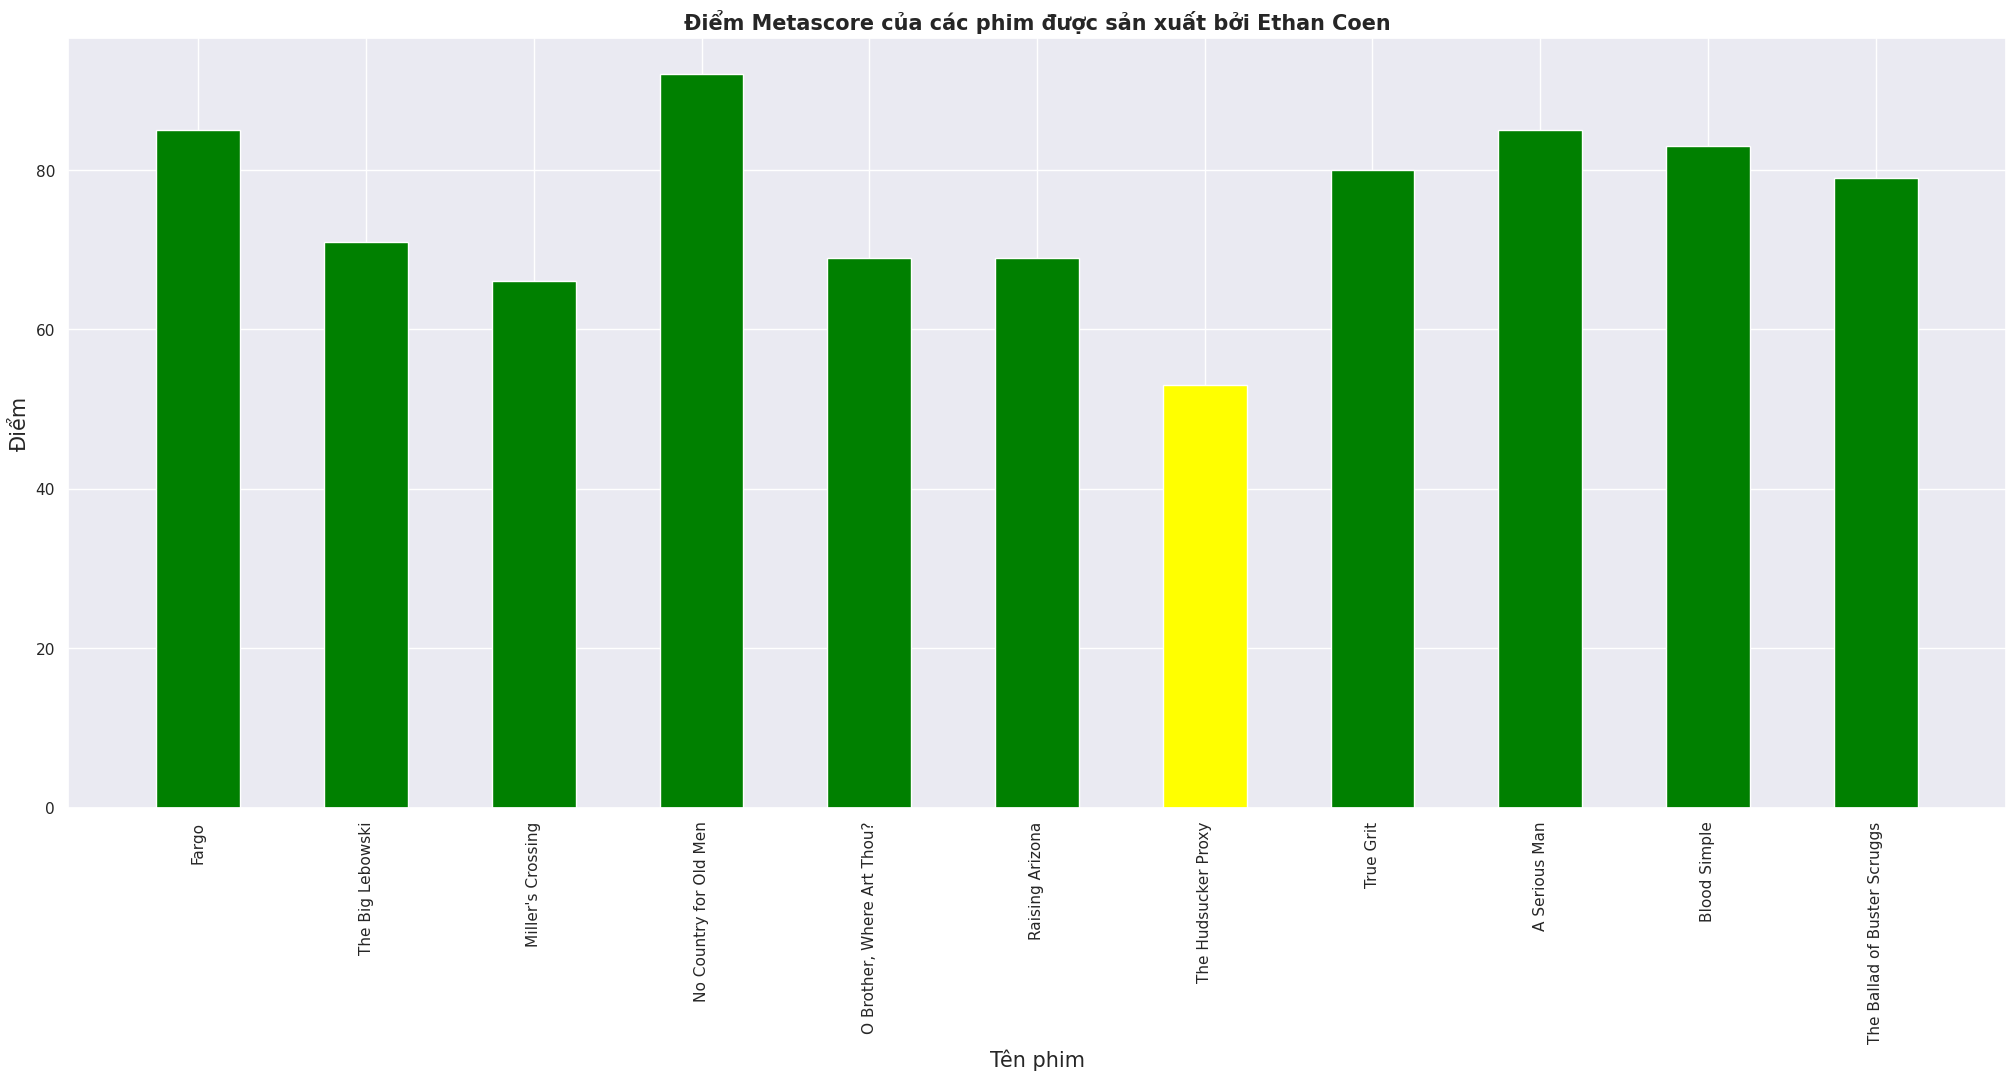

In [65]:
draw_barchart(Ethan_Coen, 'Ethan Coen')

#### **Nhận xét:**
* Đạo diễn Ethan Coen sở hữu các phim với mức điểm Meta score hầu như đều trên 70 điểm, nằm ở mức xanh lá. Nhưng lại ngoại trừ phim **The Hudsucker Proxy**. Trùng hợp, đây là bộ phim được kết hợp bởi 2 đạo diễn là Ethan Coen và Joel Coen. Và lí do tại sao phim này lại nhận trung bình sẽ tương tự như diễn giải ở phần nhận xét của đạo diễn Joel Coen.

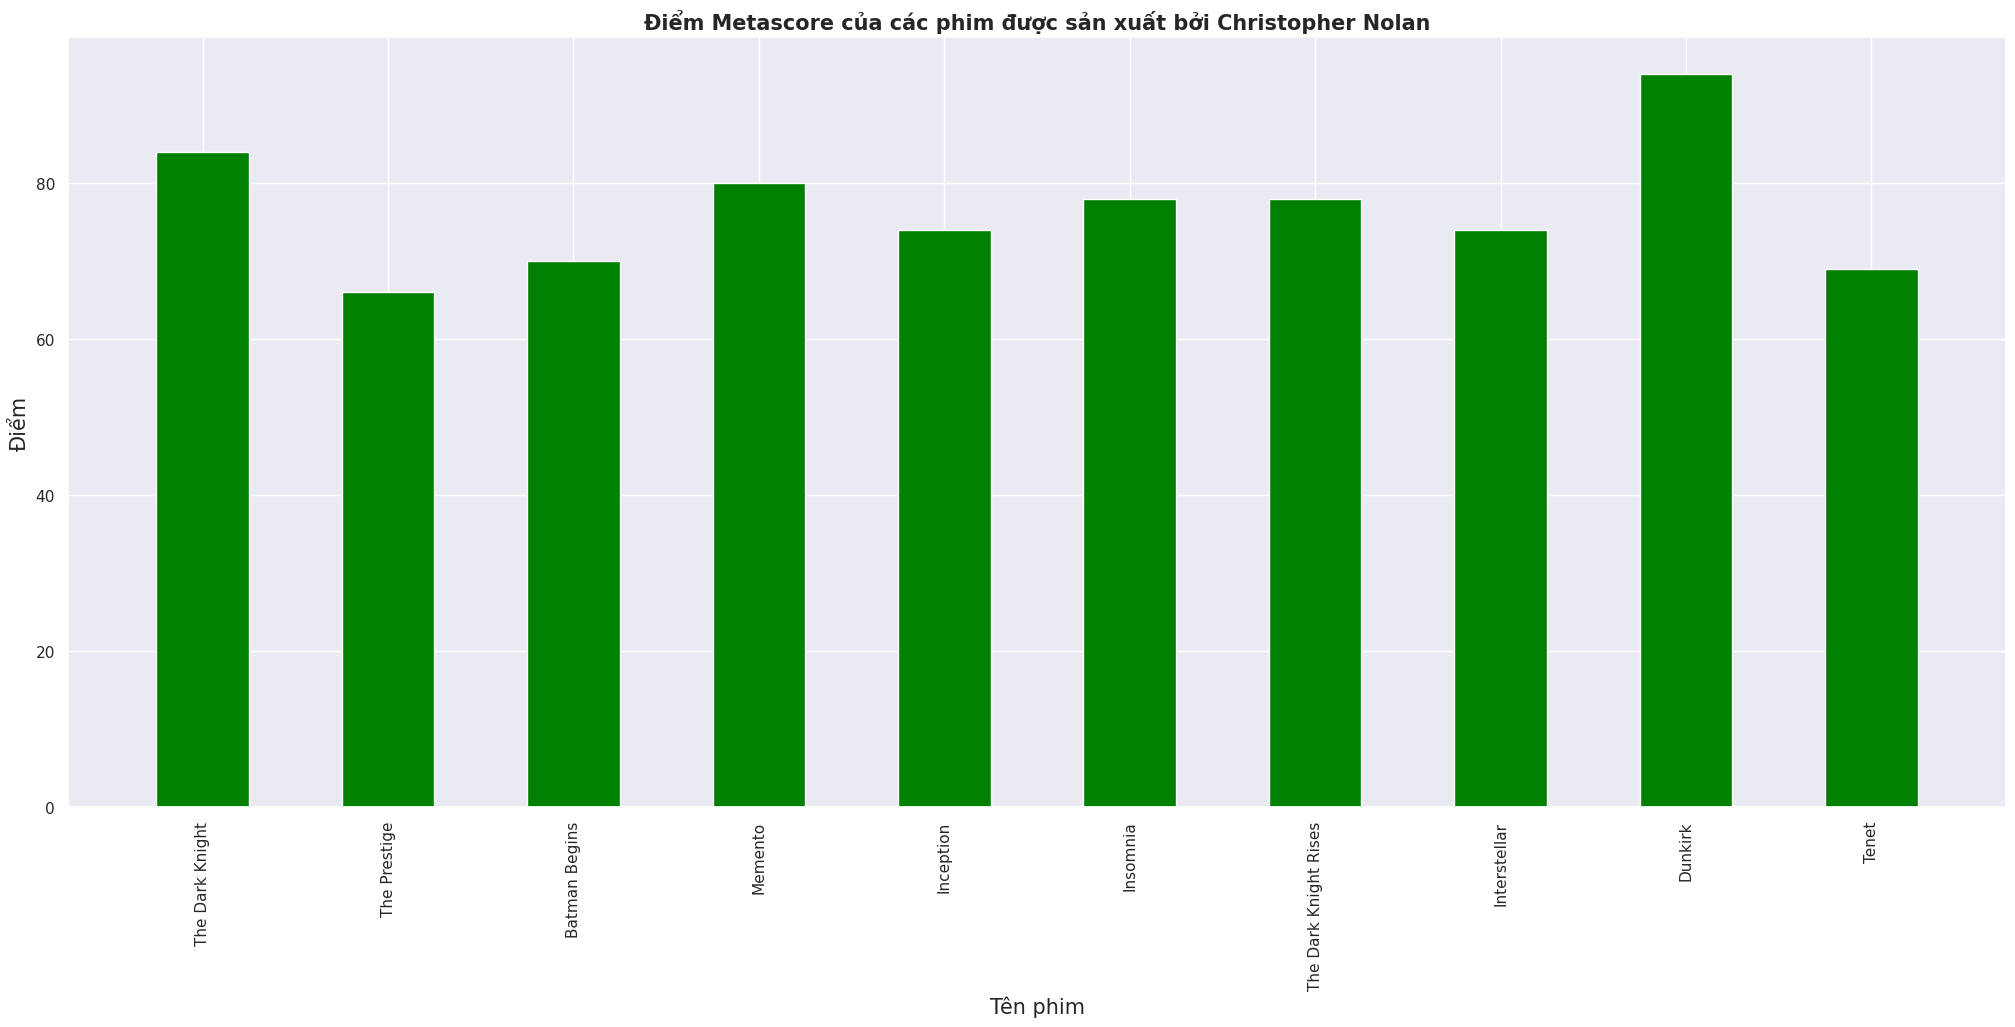

In [66]:
draw_barchart(Christopher_Nolan, 'Christopher Nolan')

#### **Nhận xét:**

* Quan sát trong biểu đồ, tất cả phim được sản xuất bởi đạo diễn Christopher Nolan đều nhận được mức điểm hạng xanh lá (hầu như đều trên 70 điểm). Việc lọt top 1000 phim hay nhất mọi thời đại với số điểm meta score đều ở mức xanh lá đã chứng tỏ rằng đạo diễn Christopher Nolan là một đạo diễn tài hoa khi hầu hết phim ông sản xuất đều được đánh giá cao.

#### **Kết luận**: 
* Việc được xuất hiện trong bảng xếp hạng được dựa vào nhiều yếu tố khác nhau như thể loại phim đang là trend hay những diễn viên của phim đó đang là những diễn viên gạo cội,... Do vậy khi đặt câu hỏi này, em muốn tìm hiểu liệu rằng, trên yếu tố nghệ thuật được đánh giá bởi các nhà phê bình chuyên môn thì các phim này có thật sự đứng vẫn được trên bảng xếp hạng.
* Và qua những gì đã phân tích, ta thấy được rằng theo nhận xét và đánh giá của các chuyên gia, các phim của các đạo diễn trên đều đạt được những đánh gia cao về mặt nghệ thuật. Do đó, ta công nhận những phim này vừa được lòng người xem và các nhà phê về mặt nội dung lẫn nghệ thuật bên trong.
* Ta thấy được rằng theo nhận xét và đánh giá của các chuyên gia, các phim của các đạo diễn trên đều đạt được những đánh gia cao về mặt nghệ thuật. Do đó, ta công nhận những phim này vừa được lòng người xem và các nhà phê về mặt nội dung lẫn nghệ thuật bên trong.
* Ngoài ra, các đạo diễn trên đều xuất hiện rất nhiều lần trong dataset và phim của họ của họ cũng nhận được những đánh giá cao. Do đó, nhìn một cách tổng quan, họ đều là những đạo diễn tài hoa và những sản phẩm mà làm ra đa số đều thật sự "chất lượng".


### **Câu 3: Liệu những phim được đóng bởi diễn viên xuất hiện nhiều trong top phim hay có còn trending ở thời điểm hiện tại không? Nếu không thì có mâu thuẫn gì với điểm IMDb không?**

**Ý nghĩa khi trả lời câu hỏi:** 
* Trả lời câu hỏi sẽ giúp những nhà làm phim xác định được những bộ phim do các diễn viên hạng A đóng có tạo trend và tạo ấn tượng lâu dài cho người xem không. Bởi không ai muốn xem bộ phim bị flop cả, nhà làm phim lẫn đạo diễn cũng không mong điều đó dù là thời gian nào. Điều này sẽ giúp đảm bảo được lợi nhuận nếu gửi gắm nhân vật đúng diễn viên hạng A có thể gánh phim.


**Nguồn cảm hứng đặt câu hỏi:** 
* Hồi trước khi xem phim, người ta thường để ý tới những diễn viên hạng A như một hiện tượng, một sự lôi kéo người ta ra rạp xem, dù chẳng cần biết là về nội dung gì và chất lượng ra sao.
* Nhưng dạo gần đây, cái tên của những diễn viên hạng A dường như không đủ sức nặng và gây ấn tượng với người xem như trước. Người ta dần để ý hơn về đạo diễn phim và chủ đề phim.
* Vậy nên, mình thắc mắc mới thắc mắc những diễn viên đó dù không được như những thập niên 9X thì có còn trending ở hiện tại không.


**Bước 1:** Để trả lời câu hỏi đó, đầu tiên, ta cần tìm xem những diễn viên gạo cội nào xuất hiện nhiều trong top phim hay. 
Kết quả tìm được sẽ lưu vào dataframe `top_star`.

In [67]:
d=copy.deepcopy(film_info_df['Stars'])

list_stars=[]
for i in d:
    list_stars.extend(i)

list_stars=pd.DataFrame(list_stars)
list_stars
count=list_stars.value_counts()
top_star=[]
count
list_stars=count.keys()
list_stars
for i in range(5):
    top_star.append(list_stars[i][0])
top_star=pd.DataFrame(top_star)
top_star=top_star.rename(columns={0:'Actor'})
print('Top 5 diễn viên gạo cội xuất hiện nhiều nhất trong top phim hay:')
top_star

Top 5 diễn viên gạo cội xuất hiện nhiều nhất trong top phim hay:


,Actor
0,Robert De Niro
1,Tom Cruise
2,Tom Hanks
3,Al Pacino
4,Brad Pitt


**Bước 2**: Những diễn viên vừa tìm được đó sẽ giúp ta xác định được tên những bộ phim do từng diễn viên đó đóng. Lưu lại lần lượt những phim của từng diễn viên vào các biến `top_1`,`top_2`,`top_3`,`top_4`,`top_5`.

In [68]:
def findFilm(df,name):
    list_idx=[]
    idx=0
    for stars in df['Stars']:
        # print(stars)
        if name in stars:
            list_idx.append(idx)
        idx+=1
    list_film=[]
    for i in range(len(list_idx)):
        list_film.append(df['Name'][list_idx[i]])
    return list_film
top_1=findFilm(film_info_df,top_star['Actor'][0])
top_2=findFilm(film_info_df,top_star['Actor'][1])
top_3=findFilm(film_info_df,top_star['Actor'][2])
top_4=findFilm(film_info_df,top_star['Actor'][3])
top_5=findFilm(film_info_df,top_star['Actor'][4])
print('Những phim do diễn viên top 1 đóng:')
top_1=pd.DataFrame(top_1)
top_1=top_1.rename(columns={0:'Film'})
display(top_1)

print('\n\nNhững phim do diễn viên top 2 đóng:')
top_2=pd.DataFrame(top_2)
top_2=top_2.rename(columns={0:'Film'})
display(top_2)

print('\n\nNhững phim do diễn viên top 3 đóng:')

top_3=pd.DataFrame(top_3)
top_3=top_3.rename(columns={0:'Film'})
display(top_3)

print('\n\nNhững phim do diễn viên top 4 đóng:')

top_4=pd.DataFrame(top_4)
top_4=top_4.rename(columns={0:'Film'})
display(top_4)

print('\n\nNhững phim do diễn viên top 5 đóng:')
top_5=pd.DataFrame(top_5)
top_5=top_5.rename(columns={0:'Film'})
display(top_5)



Những phim do diễn viên top 1 đóng:


,Film
0,Goodfellas
1,Taxi Driver
2,The Godfather Part II
3,Heat
4,Raging Bull
5,Once Upon a Time in America
6,Casino
7,The Untouchables
8,The Deer Hunter
9,Meet the Parents




Những phim do diễn viên top 2 đóng:


,Film
0,Magnolia
1,Rain Man
2,Minority Report
3,The Color of Money
4,Interview with the Vampire: The Vampire Chronicles
5,Top Gun
6,Jerry Maguire
7,Mission: Impossible - Ghost Protocol
8,Mission: Impossible
9,Collateral




Những phim do diễn viên top 3 đóng:


,Film
0,Toy Story
1,The Green Mile
2,Forrest Gump
3,Toy Story 2
4,Saving Private Ryan
5,Road to Perdition
6,Toy Story 3
7,Catch Me If You Can
8,Big
9,Captain Phillips




Những phim do diễn viên top 4 đóng:


,Film
0,The Godfather
1,The Godfather Part II
2,Scarface
3,Heat
4,Dog Day Afternoon
5,Glengarry Glen Ross
6,Carlito's Way
7,Donnie Brasco
8,The Irishman
9,Insomnia




Những phim do diễn viên top 5 đóng:


,Film
0,Fight Club
1,Se7en
2,Inglourious Basterds
3,12 Monkeys
4,Interview with the Vampire: The Vampire Chronicles
5,Ocean's Eleven
6,Snatch
7,Moneyball
8,The Curious Case of Benjamin Button
9,Sleepers


**Tiền xử lý:** Lúc này, việc tiếp theo là xác định những bộ phim do các diễn viên đó đóng còn trend không, thì ta cần phải dùng tới cột `Popularity`. Nhưng lúc này, ta nhận thấy kiểu dữ liệu ở cột này có xuất hiện giá trị NaN, nên ở đây ta sẽ thay các giá trị NaN thành 0 tiện cho việc xử lý.

In [69]:
popularity = film_info_df[['Popularity', 'Name']].copy()
popularity['Popularity'] = popularity['Popularity'].fillna(0)

**Bước 4:** Tính bình quân điểm `Popularity` và điểm `IMDb` của toàn bộ phim do từng diễn viên hàng đầu đóng. Những hàng dữ liệu sẽ được lưu theo thứ tự từ top 1 đến top 5 của dataframe `average_top`.

Lý do chúng ta dùng 2 điểm `Popularity` và `IMDb` là vì:

- IMDb là thang điểm thể hiện đánh giá của người xem trên nhiều nền tảng Internet.
- Popularity cũng là thang điểm được đánh giá thông qua lượng truy cập của người xem.

Qua đó, ta sẽ biết được phim này có trending không khi tương quan mỗi điểm đó với tổng bình quân phim trong danh sách.

In [70]:
def averagePopularity(df,list_film):
    list_popularity=[]
    for name in list_film:
        temp=df.loc[df['Name']==name]
        temp=temp['Popularity']
        list_popularity.append(temp.values[0])
    return round(sum(list_popularity)/len(list_popularity),1)

def averageIMDb(df,list_film):
    list_IMDb=[]
    for name in list_film:
        temp=df.loc[df['Name']==name]
        temp=temp['IMDb RATING']
        list_IMDb.append(temp.values[0])
    return round(sum(list_IMDb)/len(list_IMDb),1)
average_top=[]
average_top.append([averagePopularity(popularity,top_1['Film']),averageIMDb(film_info_df,top_1['Film'])])
average_top.append([averagePopularity(popularity,top_2['Film']),averageIMDb(film_info_df,top_2['Film'])])
average_top.append([averagePopularity(popularity,top_3['Film']),averageIMDb(film_info_df,top_3['Film'])])
average_top.append([averagePopularity(popularity,top_4['Film']),averageIMDb(film_info_df,top_4['Film'])])
average_top.append([averagePopularity(popularity,top_5['Film']),averageIMDb(film_info_df,top_5['Film'])])
average_top=pd.DataFrame(average_top)
xs=['Top 1','Top 2','Top 3','Top 4', 'Top 5']
xs=pd.DataFrame(xs)
xs=xs.rename(columns={0:'Top'})
average_top=average_top.rename(columns={0:'Average Popularity',1:'Average IMDb'})
average_top.insert(0,'Top',xs['Top'])
average_top


,Top,Average Popularity,Average IMDb
0,Top 1,1520.2,7.7
1,Top 2,1512.8,7.3
2,Top 3,1137.9,8.0
3,Top 4,1316.0,8.0
4,Top 5,886.5,7.9


**Bước 5:** Ta sẽ xét xem những điểm bình quân trên có cao hơn điểm trung bình trong cả danh sách không. Điều này sẽ giúp đánh giá được bình quân mỗi bộ phim của các diễn viên gạo cội có thực sự xuất sắc và treding hơn cả trong thời điểm hiện tại không.

In [71]:
average_popularity=round(film_info_df['Popularity'].sum()/1000,1)
average_IMDb=round(film_info_df['IMDb RATING'].sum()/1000,1)
print('Diễn viễn có bình quân mỗi phim trending cao hơn trung bình:')
display(average_top.loc[average_top['Average Popularity']>average_popularity])
print('\n\nDiễn viễn có bình quân mỗi phim được người xem đánh giá cao hơn trung bình:')
display(average_top.loc[average_top['Average IMDb']>average_IMDb])


Diễn viễn có bình quân mỗi phim trending cao hơn trung bình:


,Top,Average Popularity,Average IMDb
0,Top 1,1520.2,7.7
1,Top 2,1512.8,7.3




Diễn viễn có bình quân mỗi phim được người xem đánh giá cao hơn trung bình:


,Top,Average Popularity,Average IMDb
0,Top 1,1520.2,7.7
2,Top 3,1137.9,8.0
3,Top 4,1316.0,8.0
4,Top 5,886.5,7.9


**Nhận xét:**

- Những bộ phim của những diễn viên gạo cội (xuất hiện nhiều trong top phim hay) không hoàn toàn trending ở hiện tại. Có thể lý giải là vì, theo thời gian, thị hiếu người xem thay đổi, có những phim nhân văn và ý nghĩa dần trở nên kén người xem. Dòng phim nghệ thuật cũng phải cạnh tranh với các dòng phim thương mại "kiểu mì ăn liền", đã không còn hiệu ứng trending như những năm ở thế kỷ trước.
- Đồng thời, những phim do diễn viên đó đóng hầu như sẽ cao hơn bình quân điểm IMDb. Hơi trái ngược với điểm Popularity nhưng có thể hiểu rằng, bởi nếu ai dành thời gian xem những bộ phim đó đều sẽ dành lời khen và đánh giá tích cực, chỉ là ở thời điểm hiện tại, quá nhiều bộ phim tràn lan ngoài kia được quay mỗi ngày và chúng ta ai cũng thích xem những phim mới chứ sẽ thường không đào lại những phim cũ của thế kỷ trước, hoặc mười mấy năm trước. Vậy nên điểm Popularity sẽ rất khác với IMDb.

**Minh hoạ:** Vẽ biểu đồ tương quan sự khác nhau giữa 2 thang điểm. Đưa ra nhận xét và trả lời câu hỏi đã nêu.

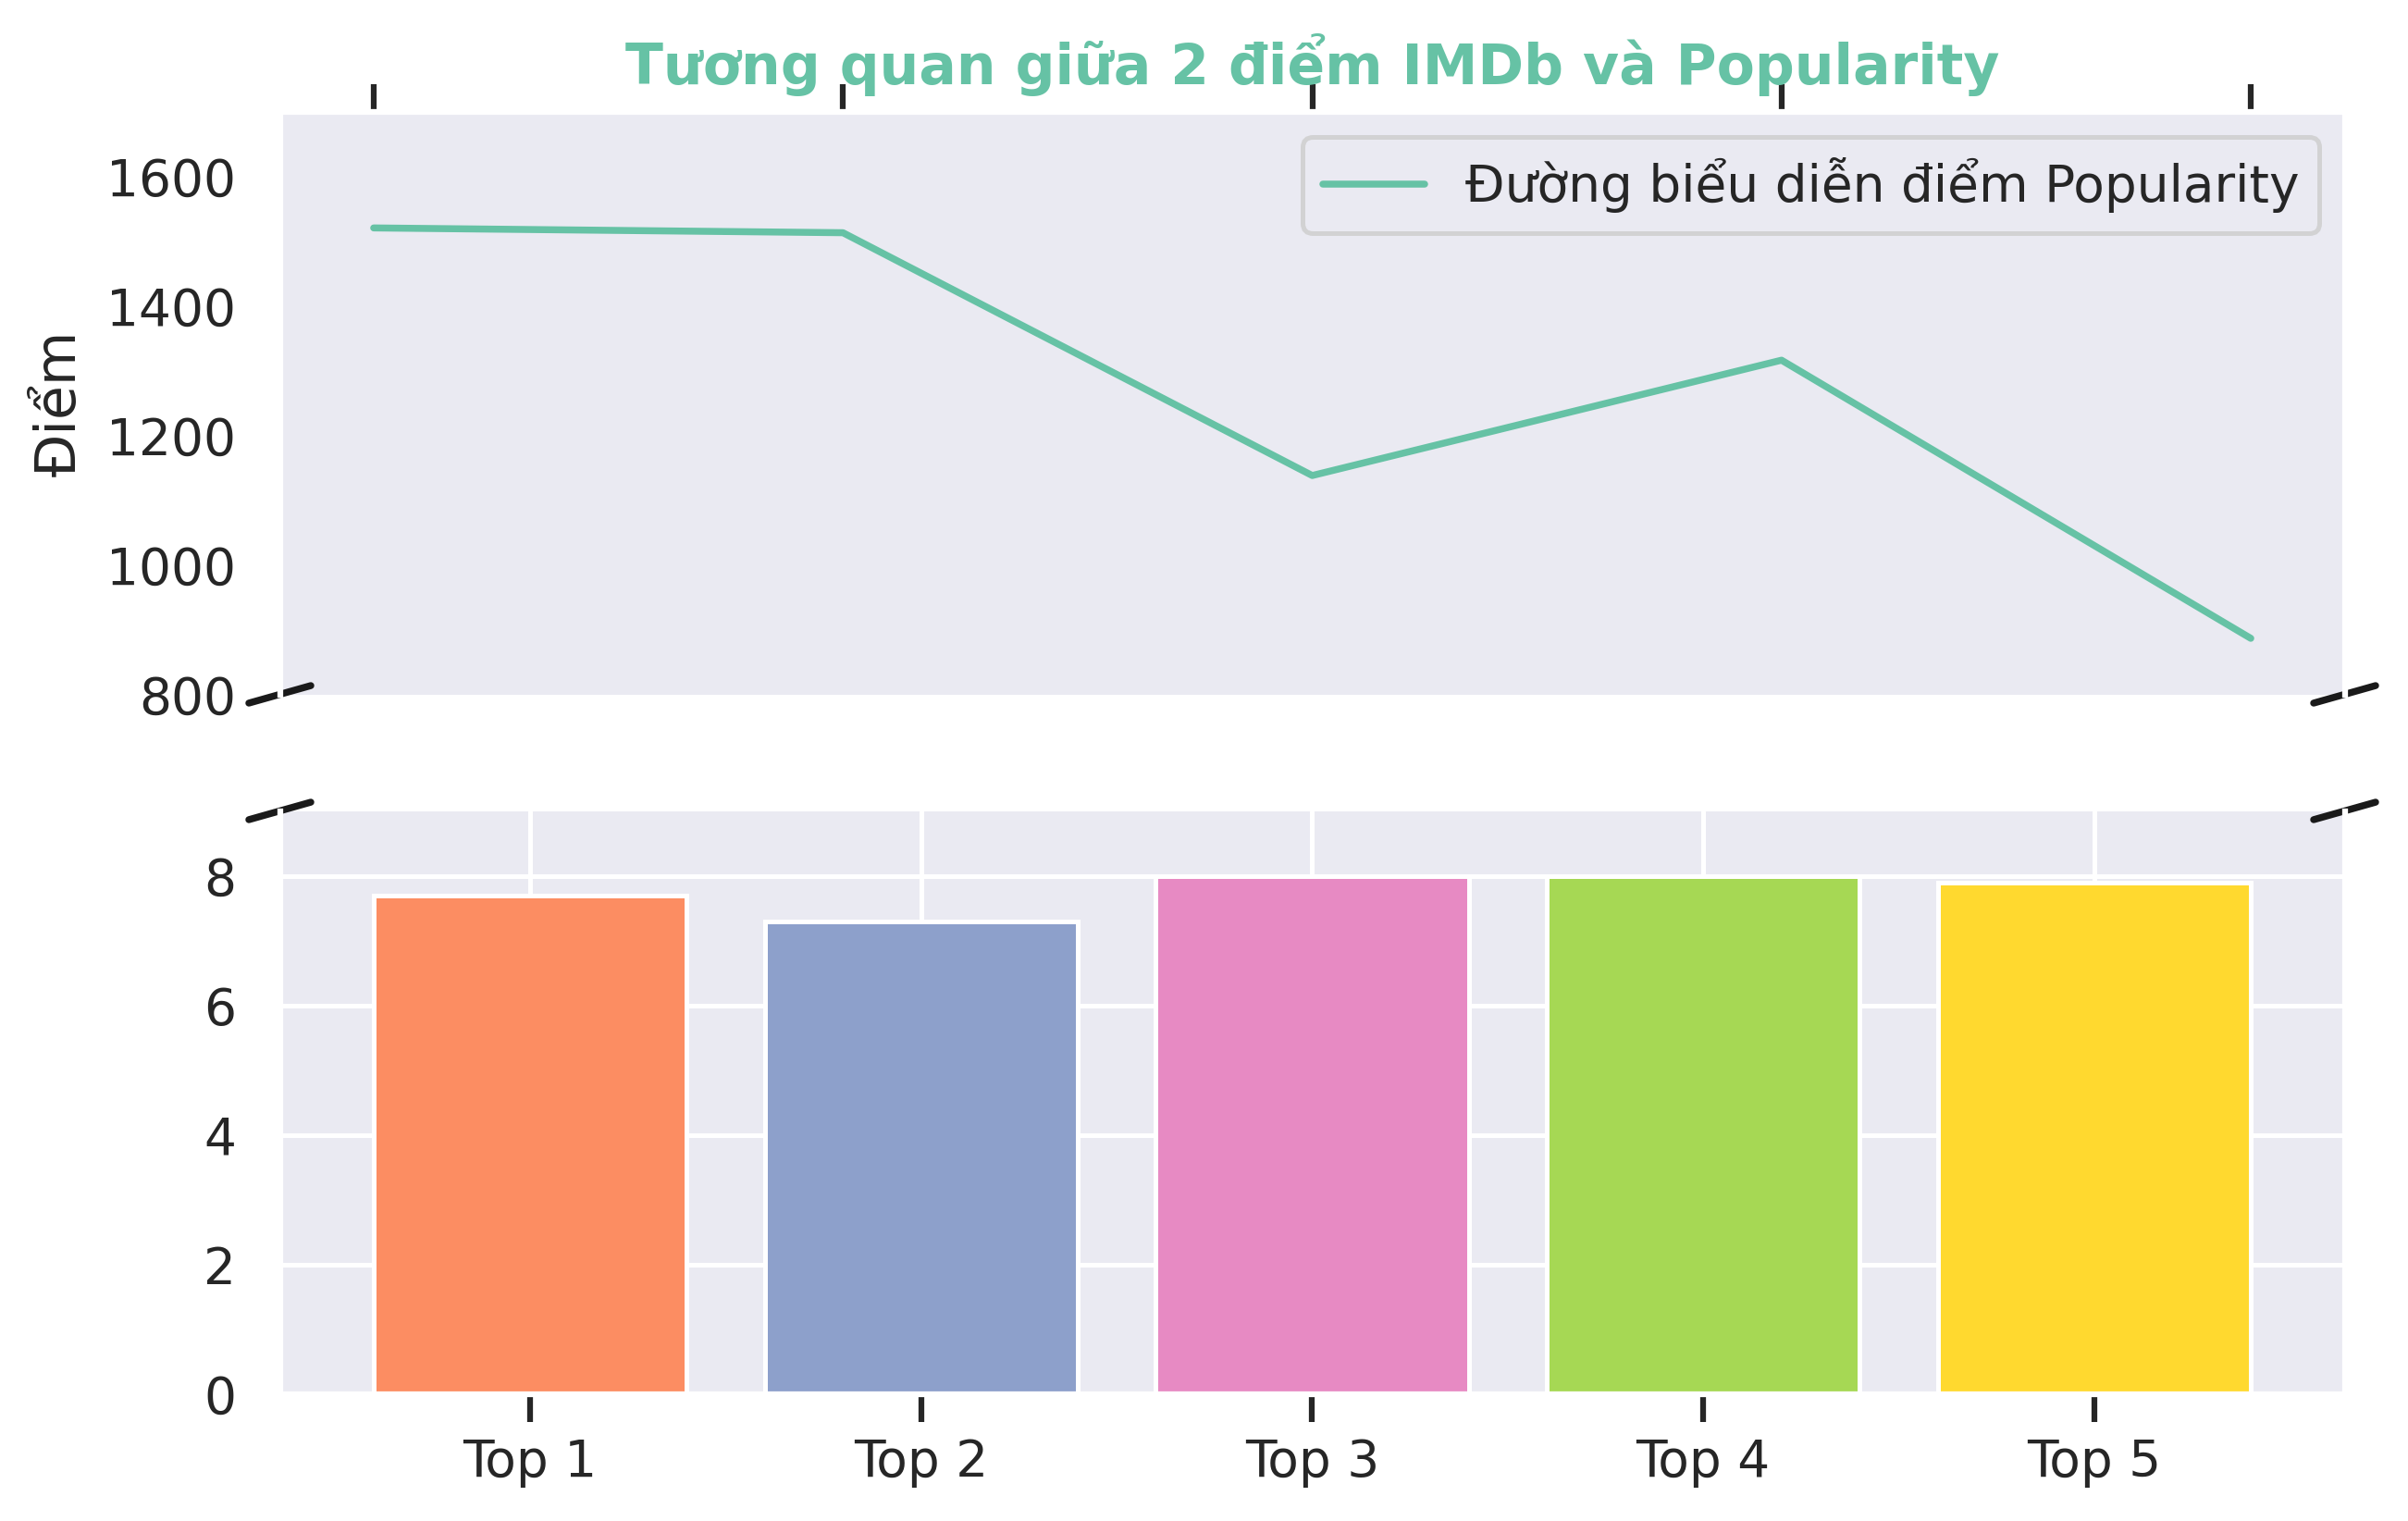

In [72]:
bar_width=0.5
xs=['Top 1','Top 2','Top 3','Top 4', 'Top 5']

plt.rcParams['figure.dpi'] = 360

fig,(ax,ax2) = plt.subplots(2,1,figsize =(8, 5))
colors = sns.color_palette('Set2')

ax.set_title('Tương quan giữa 2 điểm IMDb và Popularity',fontweight='bold',color=colors[0])
ax.set_ylabel('Điểm')
ax.plot(xs,average_top['Average Popularity'],color=colors[0])
ax2.bar(xs,average_top['Average IMDb'],color=colors[1:6])
ax.set_ylim(800,1700)
ax2.set_ylim(0,9)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  
ax2.xaxis.tick_bottom()
d = .015 
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs) 

kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs) 
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs) 
ax.grid()
ax.legend(['Đường biểu diễn điểm Popularity']);

plt.show()

**Nhận xét:**

- Bình quân điểm IMDb rất không chênh lệch quá nhiều ở thang điểm 10 và những điểm này chỉ phân bố từ 7 đến 8. Điều này thể hiện những diễn viên hạng A đóng bộ phim nào thì chất lượng bộ phim đó. Bởi theo thang IMDb, trên 7 đã là một bộ phim hay.
- Bình quân điểm Popularity chênh lệch khá nhiều theo điểm lớn hơn IMDb. Những điểm này phân bố từ khoảng 800 đến hơn 1600. Điều này cho thấy rất khó để giữ trending theo thời gian dù phim đó rất hay tại thời điểm ra mắt. 
- Thông qua 2 biểu đồ, để ý thấy top 3, 4, 5 đang có điểm Popularity thấp hơn top 1 và 2 nhưng lại có bình quân điểm IMDb cao hơn. Như đã giải thích ở nhận xét trước đó, việc điểm Popularity thay đổi sẽ không ảnh hưởng tới điểm IMDb và ngược lại.

**Trả lời câu hỏi:**

- Những phim được đóng bởi diễn viên xuất hiện nhiều trong top phim hay không chắc sẽ trending ở thời điểm hiện tại vì còn tuỳ thuộc vào nhiều yếu tố khác như thị hiếu của người xem ở thời điểm hiện tại sẽ khác ở quá khứ.
- Điều này hầu như không có mâu thuẫn gì với điểm IMDb bởi như 2 nhận xét đã nêu, 2 điểm này không ảnh hưởng tới nhau và có các yếu tố để đánh giá quá khác nhau.

### **Câu 4**: Thể loại phim nào đang chiếm giữ phần trăm về số lượng trong bảng xếp hạng lớn nhất?

**Ý nghĩa khi trả lời câu hỏi:** 
* Ta sẽ biết được về thể loại phim xuất hiện nhiều nhất trên bảng xếp hạng.
* Câu hỏi này giúp chúng ta nhìn ra thông tin cơ bản trong tập dữ liệu, thể loại phim nào chiếm phần lớn trong tập dữ liệu này.

**Nguồn cảm hứng đặt câu hỏi:**
* Thường thì khi tìm phim để xem, ta thường tìm với những từ khóa về thể loại nhiều hơn là tên phim hay các diễn viên trong phim. Do đó, em mới nghĩ ra câu hỏi này.

**Bước 1**: Ta lọc ra từ tập dữ liệu cột thể loại của phim và dùng `explode()` và `value_counts()` để tách các thể loại phim rồi đếm số lượng mỗi loại.

In [73]:
genre_v2 = film_info_df['Genres'].explode().value_counts()
genre_v2 = genre_v2.to_frame().rename(columns = {'Genres': 'Sum each genre'})
genre_v2

,Sum each genre
Drama,573
Crime,293
Comedy,279
Action,254
Thriller,191
Adventure,181
Mystery,117
Biography,106
Horror,93
Romance,92


Ta tiến hành thống kê số lượng mỗi thể loại.Nhưng do ở đây, vì có một số thể loại chỉ chiếm một số lượng nhỏ, gây khó khăn trong việc quan sát sau khi visualize nên ta sẽ quy ước những thể loại có số lượng không đáng kể đó bằng cách:
* Những thể loại nào mà có số lượng dưới 30 sẽ được cộng dồn vào Others. Others sẽ là tổng số lượng các thể loại phim thiểu số đó.

In [74]:
sum_of_others = 0
for i in range(len(genre_v2)):
    if (genre_v2['Sum each genre'][i] <= 30):
        sum_of_others += genre_v2['Sum each genre'][i] 

genre_v2 = genre_v2[genre_v2['Sum each genre'] > 30]

genre_v2.loc['Others'] = [sum_of_others]
genre_v2

/home/echkidieu/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,Sum each genre
Drama,573
Crime,293
Comedy,279
Action,254
Thriller,191
Adventure,181
Mystery,117
Biography,106
Horror,93
Romance,92


**Bước 2**: Ta tiến hành tính phần trăm mỗi thể loại và lưu trữ dưới một DataFrame.

In [75]:
ratios_df = pd.DataFrame(round(genre_v2['Sum each genre'].div(genre_v2['Sum each genre'].sum()
                                                                       , axis=0) * 100, 5))
ratios_df = ratios_df.rename(columns = {'Sum each genre': 'Ratios'})
ratios_df

,Ratios
Drama,22.24379
Crime,11.37422
Comedy,10.83075
Action,9.86025
Thriller,7.41460
Adventure,7.02640
Mystery,4.54193
Biography,4.11491
Horror,3.61025
Romance,3.57143



**Bước 3**: Ta sẽ dùng Pie chart để visualize tỉ lệ phần trăm của mỗi thể loại phim.

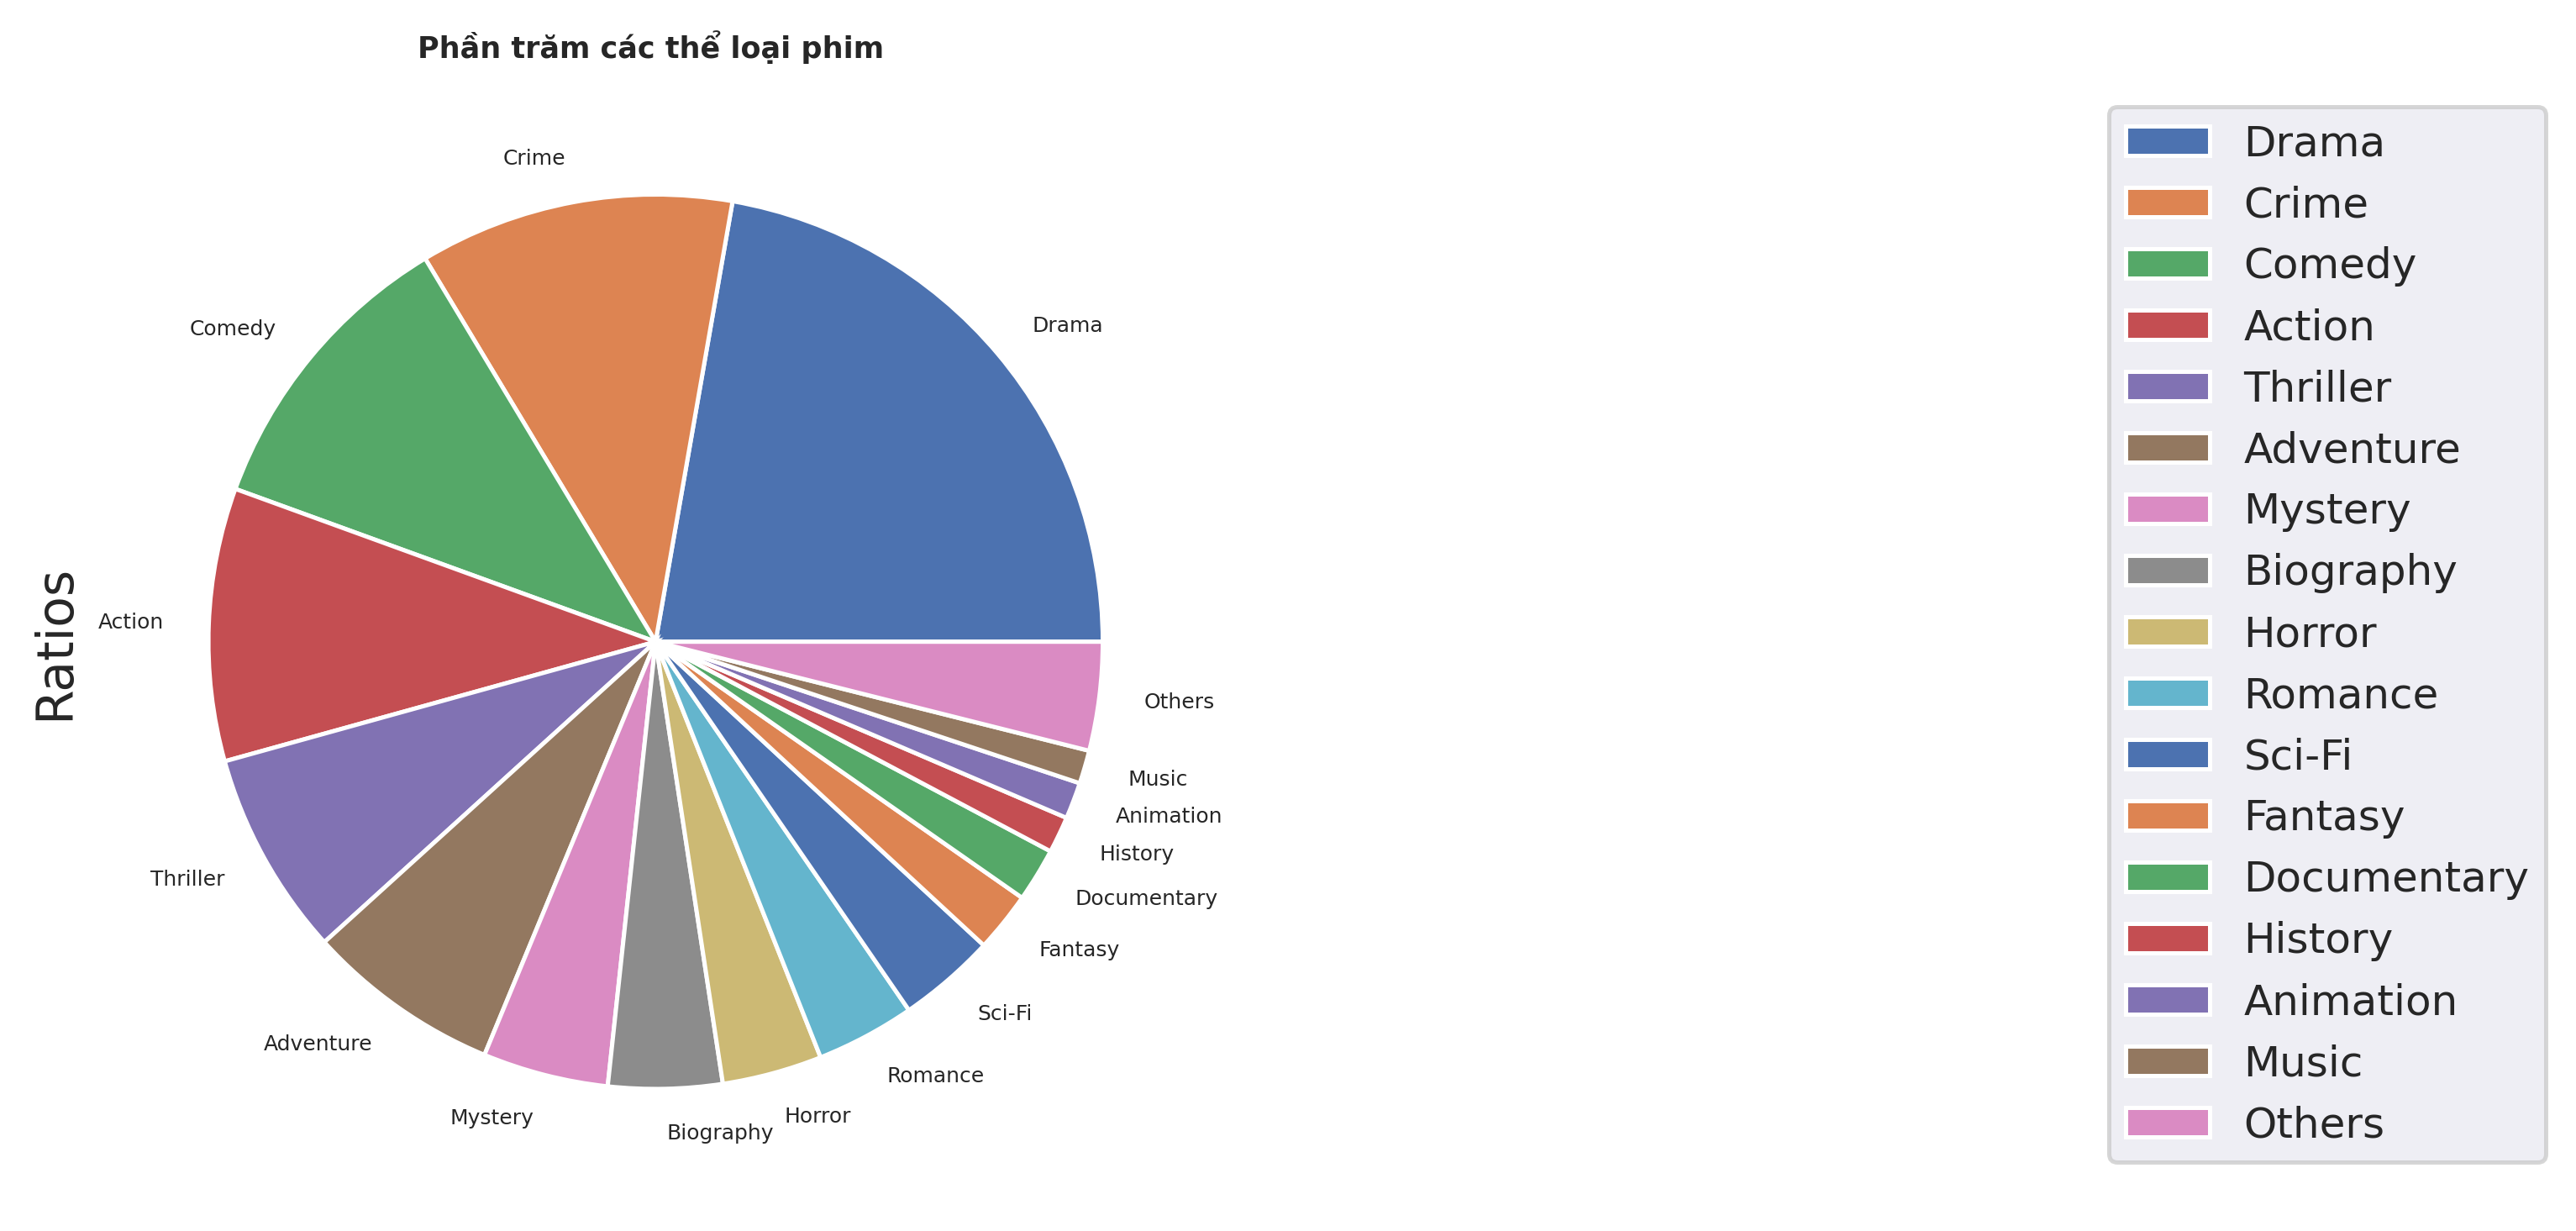

In [76]:
ax = ratios_df.plot.pie(y = 'Ratios',fontsize = 5)
ax.set(xlabel=None)
labels=ratios_df.index.unique()
plt.legend(loc="right", fontsize=10)
plt.legend(labels, bbox_to_anchor=(1.5,0.5), loc="center right", fontsize=10, 
       bbox_transform=plt.gcf().transFigure)
plt.title('Phần trăm các thể loại phim ', fontsize = 7, fontweight='bold')
plt.show()

#### **Nhận xét**: 
* Nhìn vào biểu đồ, ta có thể thấy ngay thể loại chiếm tỉ lệ cao nhất là thể loại Drama (Chính kịch).
* Ngoài ra một số thể loại Action, Comedy, Crime cũng chiếm một phần không nhỏ trong bảng xếp hạng 1000 phim này.

### **Câu 5**: Tương quan giữa doanh thu (Gross) và kinh phí (Budget) với một số vấn đề liên quan về Meta score, User reviews, IMDb RATING, Votes, Popularity để nhận xét: Liệu các phim top có hoàn được vốn (lợi nhuận) hay không?

**Ý nghĩa khi trả lời câu hỏi:** 

* Ta sẽ biết được về thể loại phim xuất hiện nhiều nhất trên bảng xếp hạng.
* Ngoài ra, ta sẽ biết được độ yêu thích của người xem phim đối với thể loại này.

**Nguồn cảm hứng đặt câu hỏi:**
* Thường thì khi tìm phim để xem, ta thường tìm với những từ khóa về thể loại nhiều hơn là tên phim hay các diễn viên trong phim. Do đó, em mới nghĩ ra câu hỏi này.

**Bước 1**: Tiền xử lý một số dữ liệu cần thiết (xử lý các trường hợp NaN)

In [77]:
film_info_df[film_info_df['Popularity'].isnull()]

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
28,29,tt1235166,A Prophet,2009,2000,R,155.0,"[Crime, Drama]",[Jacques Audiard],"[Thomas Bidegain, Abdel Raouf Dafri, Jacques Audiard]","[Tahar Rahim, Niels Arestrup, Adel Bencherif]",7.8,13000000.0,2084637.0,NaN,99084,174.0,264.0,90.0,Nominated for 1 Oscar,/title/tt1235166/
83,84,tt0310793,Bowling for Columbine,2002,2000,R,120.0,"[Documentary, Crime, Drama]",[Michael Moore],[Michael Moore],"[Charlton Heston, Marilyn Manson, Michael Moore]",8.0,4000000.0,21576018.0,NaN,145162,897.0,208.0,72.0,Won 1 Oscar,/title/tt0310793/
125,126,tt0475276,United 93,2006,2000,R,111.0,"[Action, Drama, History]",[Paul Greengrass],[Paul Greengrass],"[Olivia Thirlby, David Alan Basche, Liza Colón-Zayas]",7.6,15000000.0,31567134.0,NaN,107138,892.0,147.0,90.0,Nominated for 2 Oscars,/title/tt0475276/
127,128,tt0120706,The General,1998,1990,R,124.0,"[Biography, Crime, Drama]",[John Boorman],"[Paul Williams, John Boorman]","[Brendan Gleeson, Adrian Dunbar, Sean McGinley]",7.2,NaN,1211865.0,NaN,8862,51.0,54.0,81.0,Awards,/title/tt0120706/
131,132,tt0114660,Things to Do in Denver When You're Dead,1995,1990,R,115.0,"[Crime, Drama, Thriller]",[Gary Fleder],[Scott Rosenberg],"[Christopher Lloyd, Andy Garcia, Christopher Walken]",6.7,7000000.0,529766.0,NaN,28181,165.0,45.0,46.0,Awards,/title/tt0114660/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,970,tt0070707,Sleeper,1973,1970,PG,89.0,"[Comedy, Sci-Fi]",[Woody Allen],"[Woody Allen, Marshall Brickman]","[Woody Allen, Diane Keaton, John Beck]",7.1,2000000.0,2905334.0,NaN,43336,143.0,68.0,77.0,Awards,/title/tt0070707/
971,972,tt2870648,Amy,2015,2010,R,128.0,"[Documentary, Biography, Music]",[Asif Kapadia],[],"[Amy Winehouse, Mitch Winehouse, Mark Ronson]",7.8,NaN,8413144.0,NaN,52575,140.0,258.0,85.0,Won 1 Oscar,/title/tt2870648/
989,990,tt1152758,Dear Zachary: A Letter to a Son About His Father,2008,2000,Not Rated,95.0,"[Documentary, Biography, Crime]",[Kurt Kuenne],[Kurt Kuenne],"[David Bagby, Kurt Kuenne, Andrew Bagby]",8.5,NaN,20834.0,NaN,37353,146.0,73.0,82.0,Awards,/title/tt1152758/
991,992,tt5895028,13th,2016,2010,TV-MA,100.0,"[Documentary, Crime, History]",[Ava DuVernay],"[Ava DuVernay, Spencer Averick]","[Michelle Alexander, Cory Booker, Melina Abdullah]",8.2,NaN,0.0,NaN,35837,120.0,101.0,83.0,Nominated for 1 Oscar,/title/tt5895028/


In [78]:
film_info_df['Popularity']=film_info_df['Popularity'].replace(np.nan, 10000.0,regex=True).astype(float)

In [79]:
film_info_df[film_info_df['Gross'].isnull()]
film_info_df.head(5)

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,1970,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,1990,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,1990,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,1970,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/


In [80]:
film_info_df.Gross=film_info_df.Gross.replace(np.nan,0.0,regex=True).astype(float)

In [81]:
film_info_df[film_info_df['Budget (estimated)'].isnull()]
film_info_df.head(5)

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,1970,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,1990,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,1990,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,1970,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/


**Bước 2**: Sort data tăng dần theo lợi nhuận (Profit), gom thành các khoảng 10 phim theo thứ tự và tính trung bình theo từng yếu tố (Meta score, User reviews, IMDb RATING, Votes, Popularity).

In [82]:
film_info_df_copy = film_info_df
film_info_df_copy['Profit'] = film_info_df_copy['Gross'] - film_info_df_copy['Budget (estimated)']

In [83]:
# Loại các dòng có Gross và Budget (estimated) bằng 0
shape = film_info_df_copy.shape
for i in range(shape[0]):
    if film_info_df_copy['Gross'][i] == 0.0 or film_info_df_copy['Budget (estimated)'][i] == 0.0:
        film_info_df_copy = film_info_df_copy.drop(labels=[i])

In [84]:
# Loại bỏ các dòng không có Meta score
film_info_df_copy = film_info_df_copy.drop(film_info_df_copy[film_info_df_copy['Meta score'].isnull()].index)

In [85]:
# sắp xếp theo lợi nhuận tăng để dễ tương quan với các yêu tố khác 
film_info_df_copy = film_info_df_copy.sort_values(by='Profit')
film_info_df_copy

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL,Profit
246,247,tt1302006,The Irishman,2019,2010,R,209.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Steven Zaillian, Charles Brandt]","[Al Pacino, Robert De Niro, Joe Pesci]",7.8,159000000.0,7000000.0,394.0,388038,2900.0,458.0,94.0,Nominated for 10 Oscars,/title/tt1302006/,-152000000.0
774,775,tt6723592,Tenet,2020,2020,PG-13,150.0,"[Action, Sci-Fi, Thriller]",[Christopher Nolan],[Christopher Nolan],"[John David Washington, Robert Pattinson, Elizabeth Debicki]",7.3,205000000.0,58456624.0,242.0,502061,5500.0,510.0,69.0,Won 1 Oscar,/title/tt6723592/,-146543376.0
754,755,tt1663662,Pacific Rim,2013,2010,PG-13,131.0,"[Action, Adventure, Sci-Fi]",[Guillermo del Toro],"[Travis Beacham, Guillermo del Toro]","[Charlie Hunnam, Rinko Kikuchi, Idris Elba]",6.9,190000000.0,101802906.0,1149.0,503506,1300.0,605.0,65.0,Nominated for 1 BAFTA Award,/title/tt1663662/,-88197094.0
337,338,tt1631867,Edge of Tomorrow,2014,2010,PG-13,113.0,"[Action, Adventure, Sci-Fi]",[Doug Liman],"[John-Henry Butterworth, Jez Butterworth, Christopher McQuarrie]","[Emily Blunt, Tom Cruise, Bill Paxton]",7.9,178000000.0,100206256.0,756.0,678790,1100.0,634.0,71.0,Awards,/title/tt1631867/,-77793744.0
211,212,tt0970179,Hugo,2011,2010,PG,126.0,"[Adventure, Drama, Family]",[Martin Scorsese],"[John Logan, Brian Selznick]","[Christopher Lee, Chloë Grace Moretz, Asa Butterfield]",7.5,150000000.0,73864507.0,1084.0,324299,827.0,700.0,83.0,Won 5 Oscars,/title/tt0970179/,-76135493.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,947,tt0083111,Southern Comfort,1981,1980,R,106.0,"[Action, Thriller]",[Walter Hill],"[David Giler, Michael Kane, Walter Hill]","[Keith Carradine, Powers Boothe, Fred Ward]",7.1,NaN,5000000.0,10000.0,20068,175.0,100.0,63.0,None,/title/tt0083111/,NaN
951,952,tt0069097,"Play It Again, Sam",1972,1970,PG,85.0,"[Comedy, Romance]",[Herbert Ross],[Woody Allen],"[Woody Allen, Diane Keaton, Tony Roberts]",7.6,NaN,2303809.0,10000.0,26738,94.0,47.0,77.0,Awards,/title/tt0069097/,NaN
965,966,tt1456635,Goon,2011,2010,R,92.0,"[Comedy, Drama, Sport]",[Michael Dowse],"[Evan Goldberg, Jay Baruchel, Adam Frattasio]","[Alison Pill, Jay Baruchel, Seann William Scott]",6.8,NaN,4168144.0,10000.0,87629,192.0,152.0,64.0,Awards,/title/tt1456635/,NaN
971,972,tt2870648,Amy,2015,2010,R,128.0,"[Documentary, Biography, Music]",[Asif Kapadia],[],"[Amy Winehouse, Mitch Winehouse, Mark Ronson]",7.8,NaN,8413144.0,10000.0,52575,140.0,258.0,85.0,Won 1 Oscar,/title/tt2870648/,NaN


In [86]:
# Hàm tính toán giá trị trung bình của từng yêu tố theo cụm n phim
def convert_to(col, n):
    sum = 0
    count = 0
    ans = []
    for i in col:
        sum += i
        count += 1
        if count == n:
            count = 0
            ans.append(round(sum/n, 1))
            sum = 0
    if (count !=0 ):
        ans.append(round(sum/count, 1))
    return ans

In [87]:
# Lưu các cụm theo các yếu tố vào data
correlate_profit_with_x = pd.DataFrame()
N = 10

ans = convert_to(film_info_df_copy['Profit'], N)
correlate_profit_with_x['Profit'] = ans

ans = convert_to(film_info_df_copy['Meta score'], N)
correlate_profit_with_x['Meta score'] = ans

ans = convert_to(film_info_df_copy['User reviews'], N)
correlate_profit_with_x['User reviews'] = ans

ans = convert_to(film_info_df_copy['IMDb RATING'], N)
correlate_profit_with_x['IMDb RATING'] = ans

ans = convert_to(film_info_df_copy['Votes'], N)
correlate_profit_with_x['Votes'] = ans

ans = convert_to(film_info_df_copy['Popularity'], N)
correlate_profit_with_x['Popularity'] = ans

In [88]:
correlate_profit_with_x.head()

,Profit,Meta score,User reviews,IMDb RATING,Votes,Popularity
0,-84096863.1,75.5,1659.8,7.4,376482.2,1441.7
1,-41762269.5,67.1,569.8,7.4,151907.0,5783.8
2,-30564143.7,70.4,797.2,7.3,305619.1,2339.6
3,-24877939.4,64.8,1021.4,7.4,411859.2,3538.2
4,-20815091.1,71.3,912.1,7.5,293728.2,3242.2


In [89]:
# Xác định chiều dài trục x tùy vào số khoảng n gán trên
len_x = len(film_info_df_copy['Profit'])
if len_x % N == 0:
    pos = len_x / N
else:
    pos = math.floor(len_x / N) + 1

**Bước 3**: Vẽ các biểu đồ cột lợi nhuận trung bình.

Text(0.5, 1.0, 'Lợi nhuận trung bình trên khoảng 10 phim')

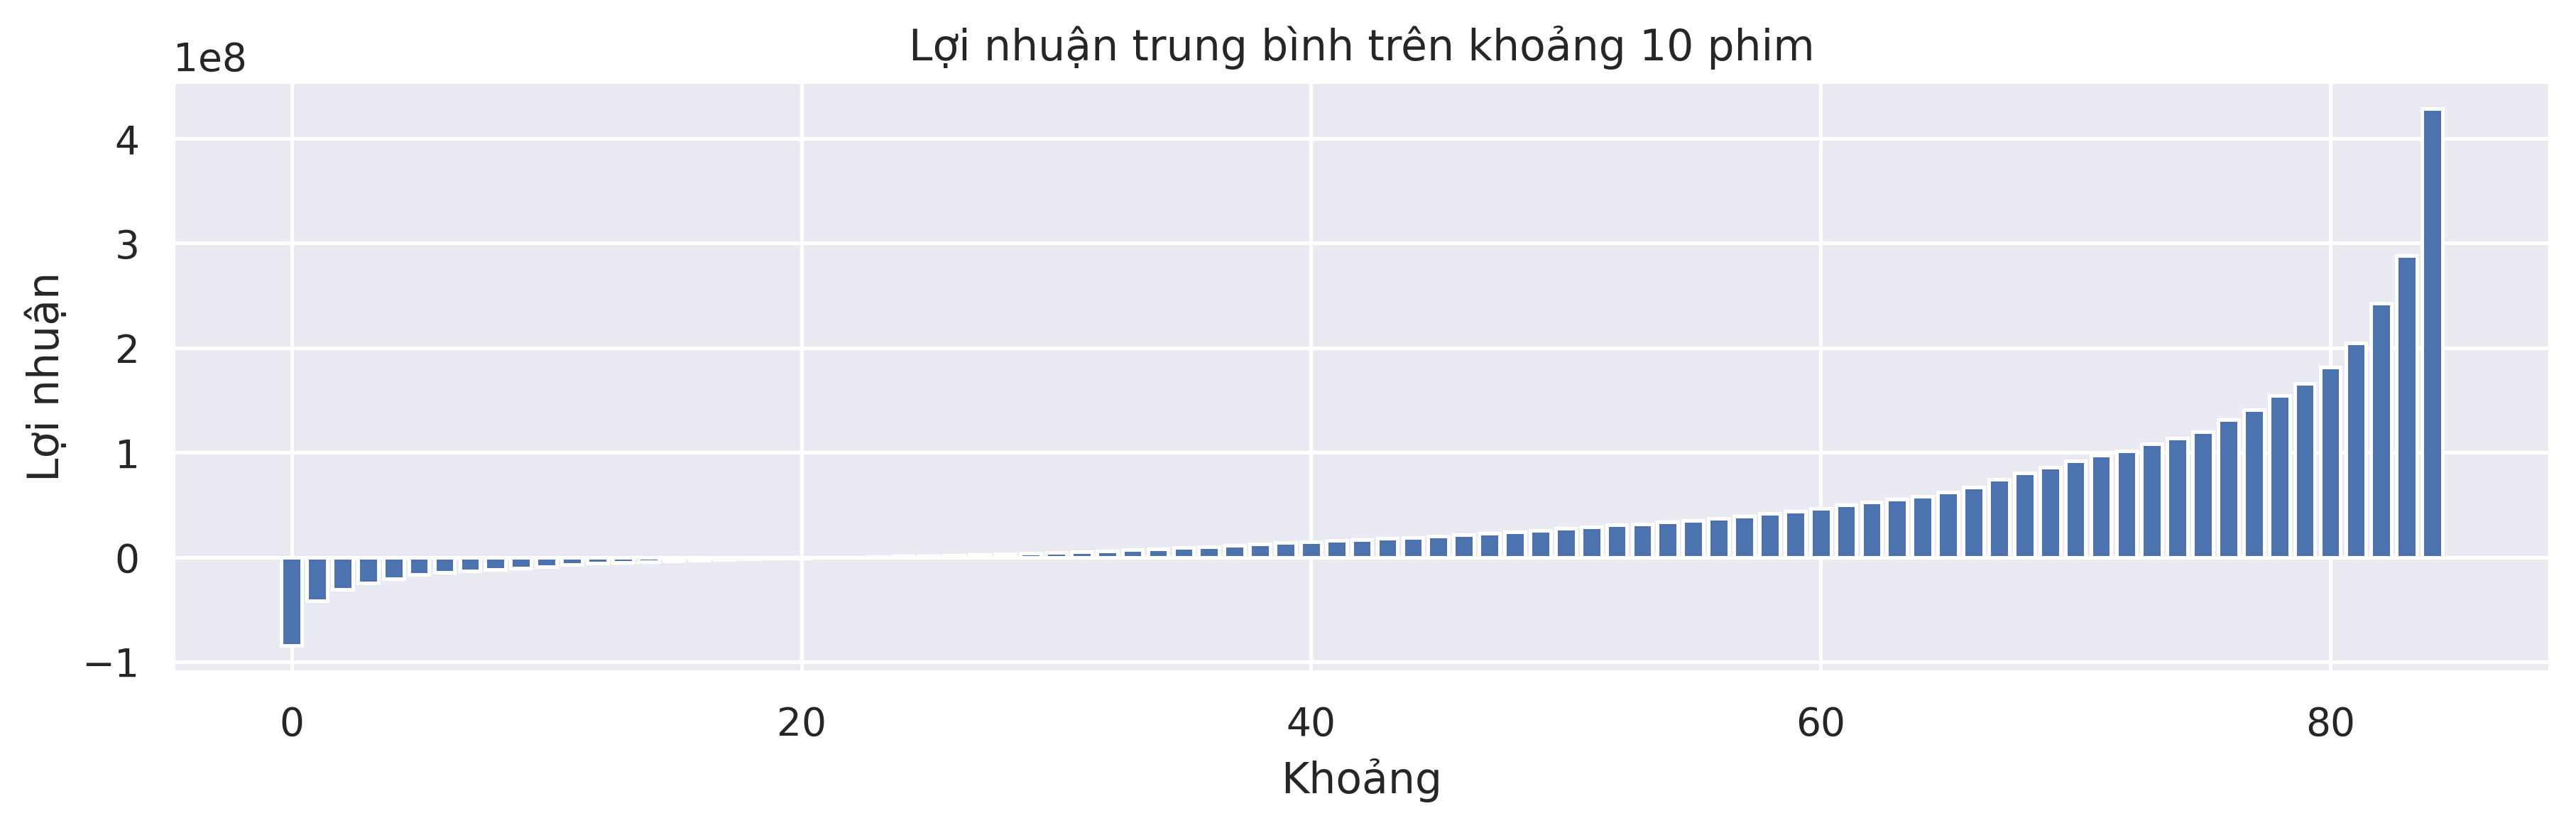

In [90]:
index = np.arange(pos)
fig =plt.subplots(figsize=(12,3))
plt.bar(index, correlate_profit_with_x['Profit'])
plt.xlabel("Khoảng")
plt.ylabel("Lợi nhuận")
plt.title("Lợi nhuận trung bình trên khoảng 10 phim")

#### Nhận xét: 
- Lợi nhuận của các phim vẫn có các trường hợp lỗ từ đó ta phối hợp cùng các yếu tố khác đánh giá phim đạt được các tiêu chí gì thì có khả năng hoàn vốn và sinh lời.

**Bước 4**: Vẽ các biểu đồ cột từng yếu tố từ đó tương quan có tăng theo lợi nhuận không và kết luận.

Text(0.5, 1.0, 'Điểm Meta score trung bình trên khoảng 10 phim')

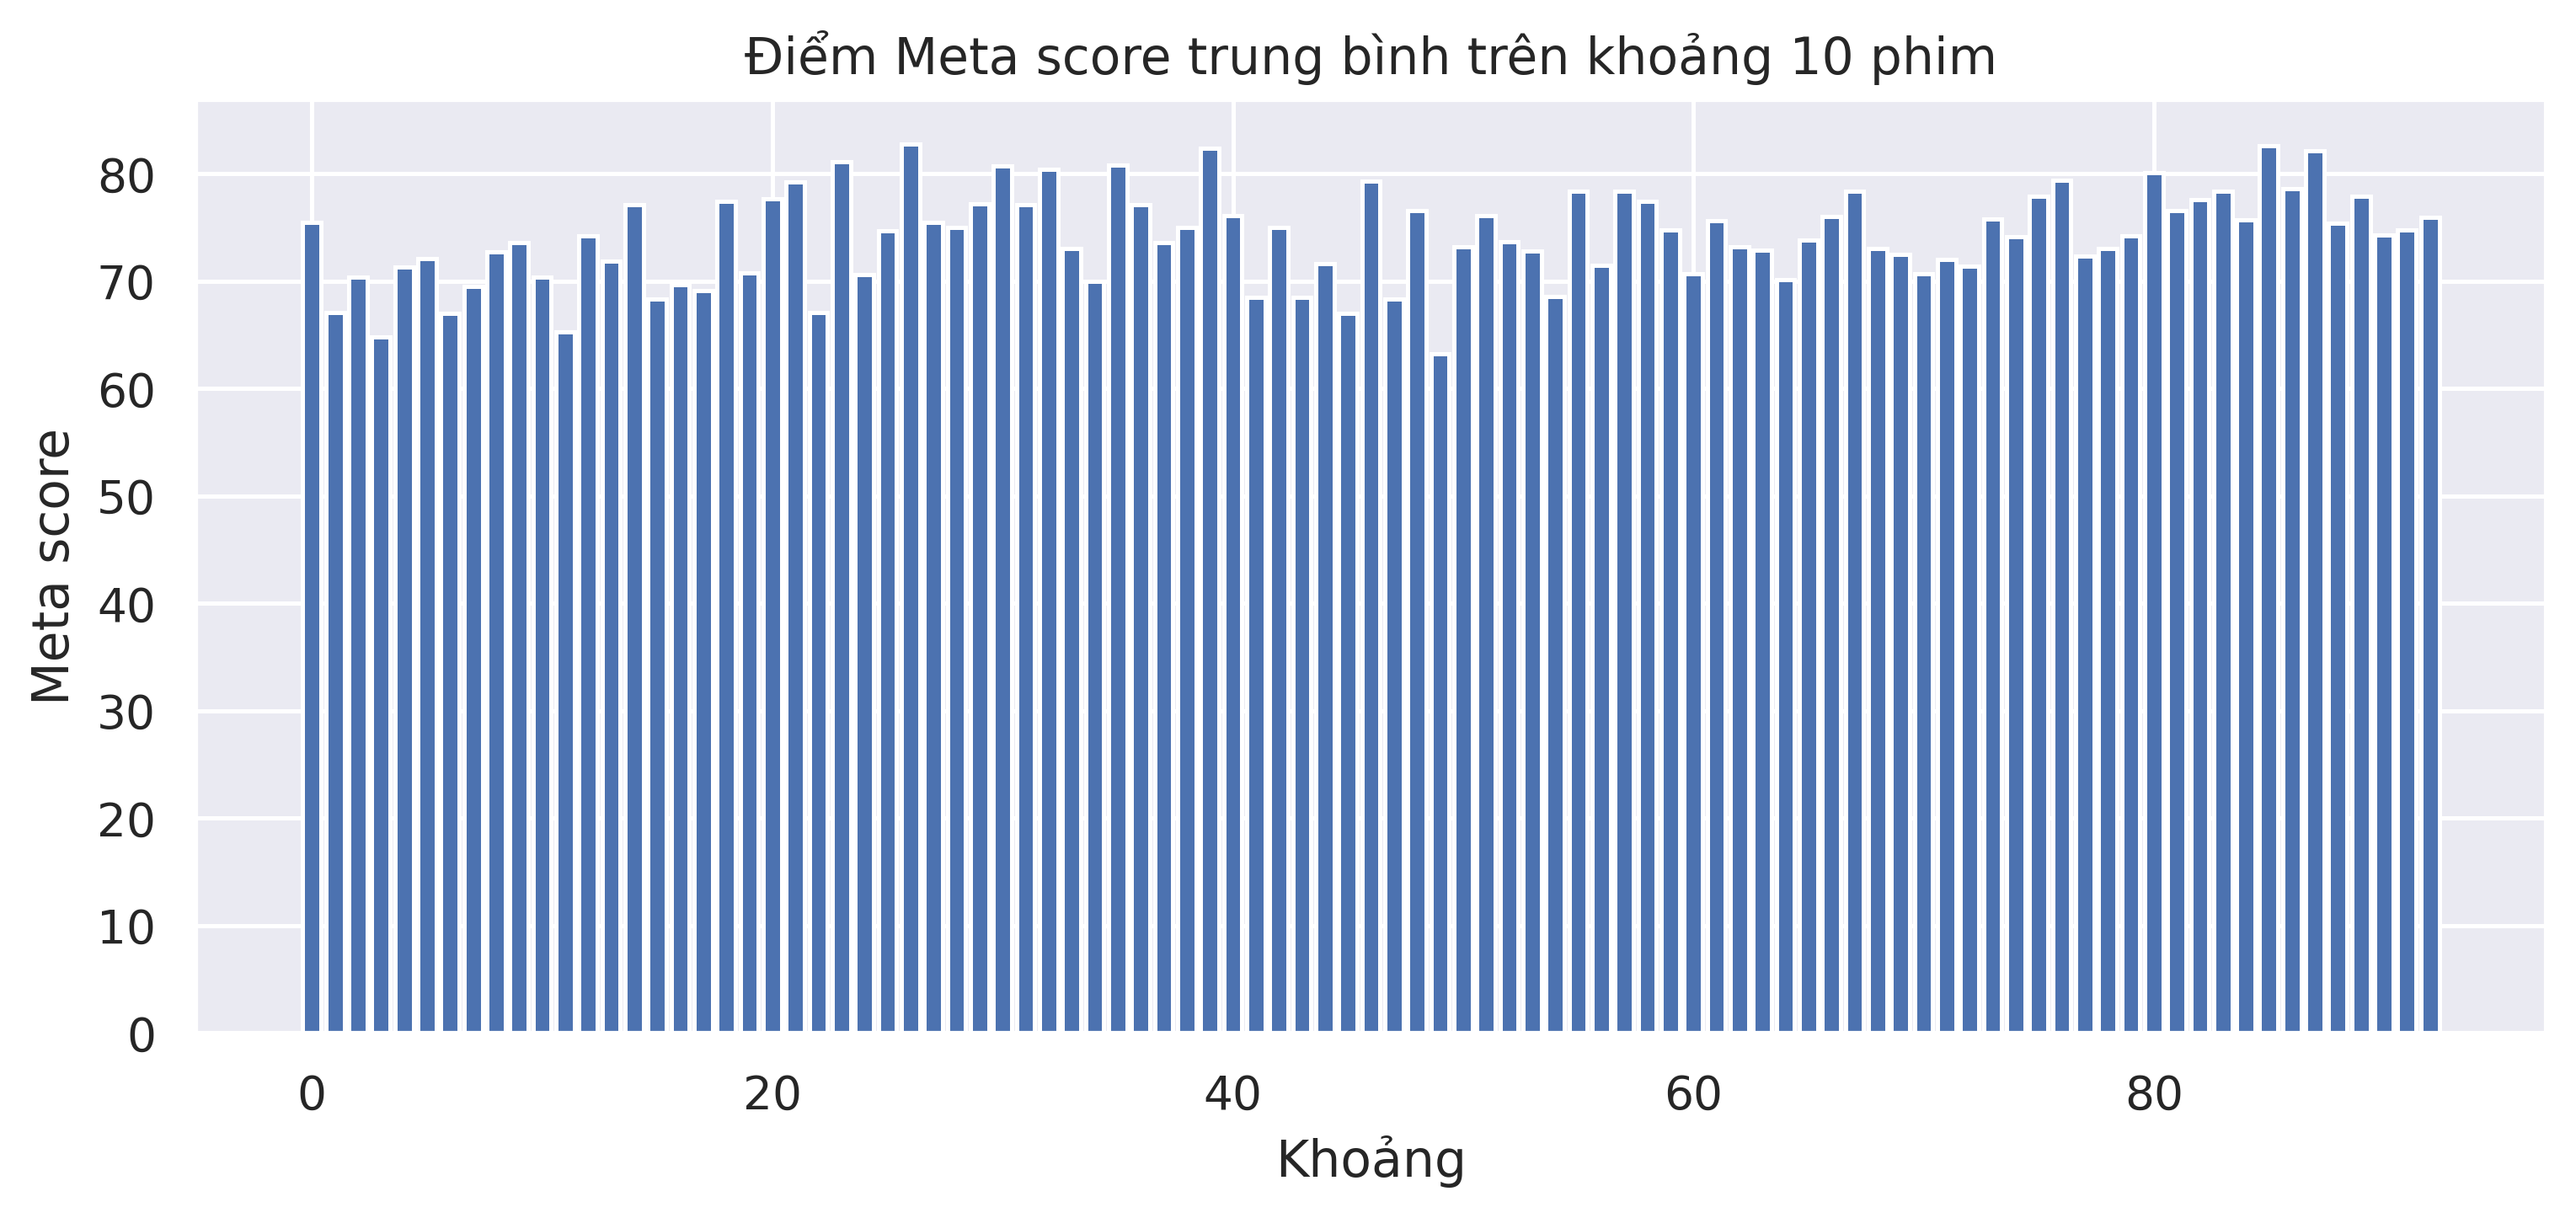

In [91]:
index = np.arange(pos)
fig =plt.subplots(figsize=(10,4))
plt.bar(index, correlate_profit_with_x['Meta score'])
plt.xlabel("Khoảng")
plt.ylabel("Meta score")
plt.title("Điểm Meta score trung bình trên khoảng 10 phim")

#### Nhận xét: 

- Quan sát biểu đồ một cách tỉ mỉ ta thấy rằng từ khoảng y = 55 trở lên yếu tố meta score cao đều đặng ổn định trên mức 70, không còn xảy ra các trường hợp thấp hơn 70 nữa
- Tuy vẫn còn chưa biểu diễn sự ảnh hưởng rõ ràng từ điểm Meta score lên lợi nhuận mang lại vì dưới khoảng thứ 40 vẫn còn các khoảng cao đột biến nhưng không mang tính ổn định vì vẫn còn các cột thấp dưới 70

=> Nhưng biểu đồ vẫn phản ánh được rằng phim có lợi nhuận thường sẽ có điểm meta score cao hơn 70, lợi nhuận càng cao mức cao hơn 70 này càng ổn định

Text(0.5, 1.0, 'Số lượng User reviews trung bình trên khoảng 10 phim')

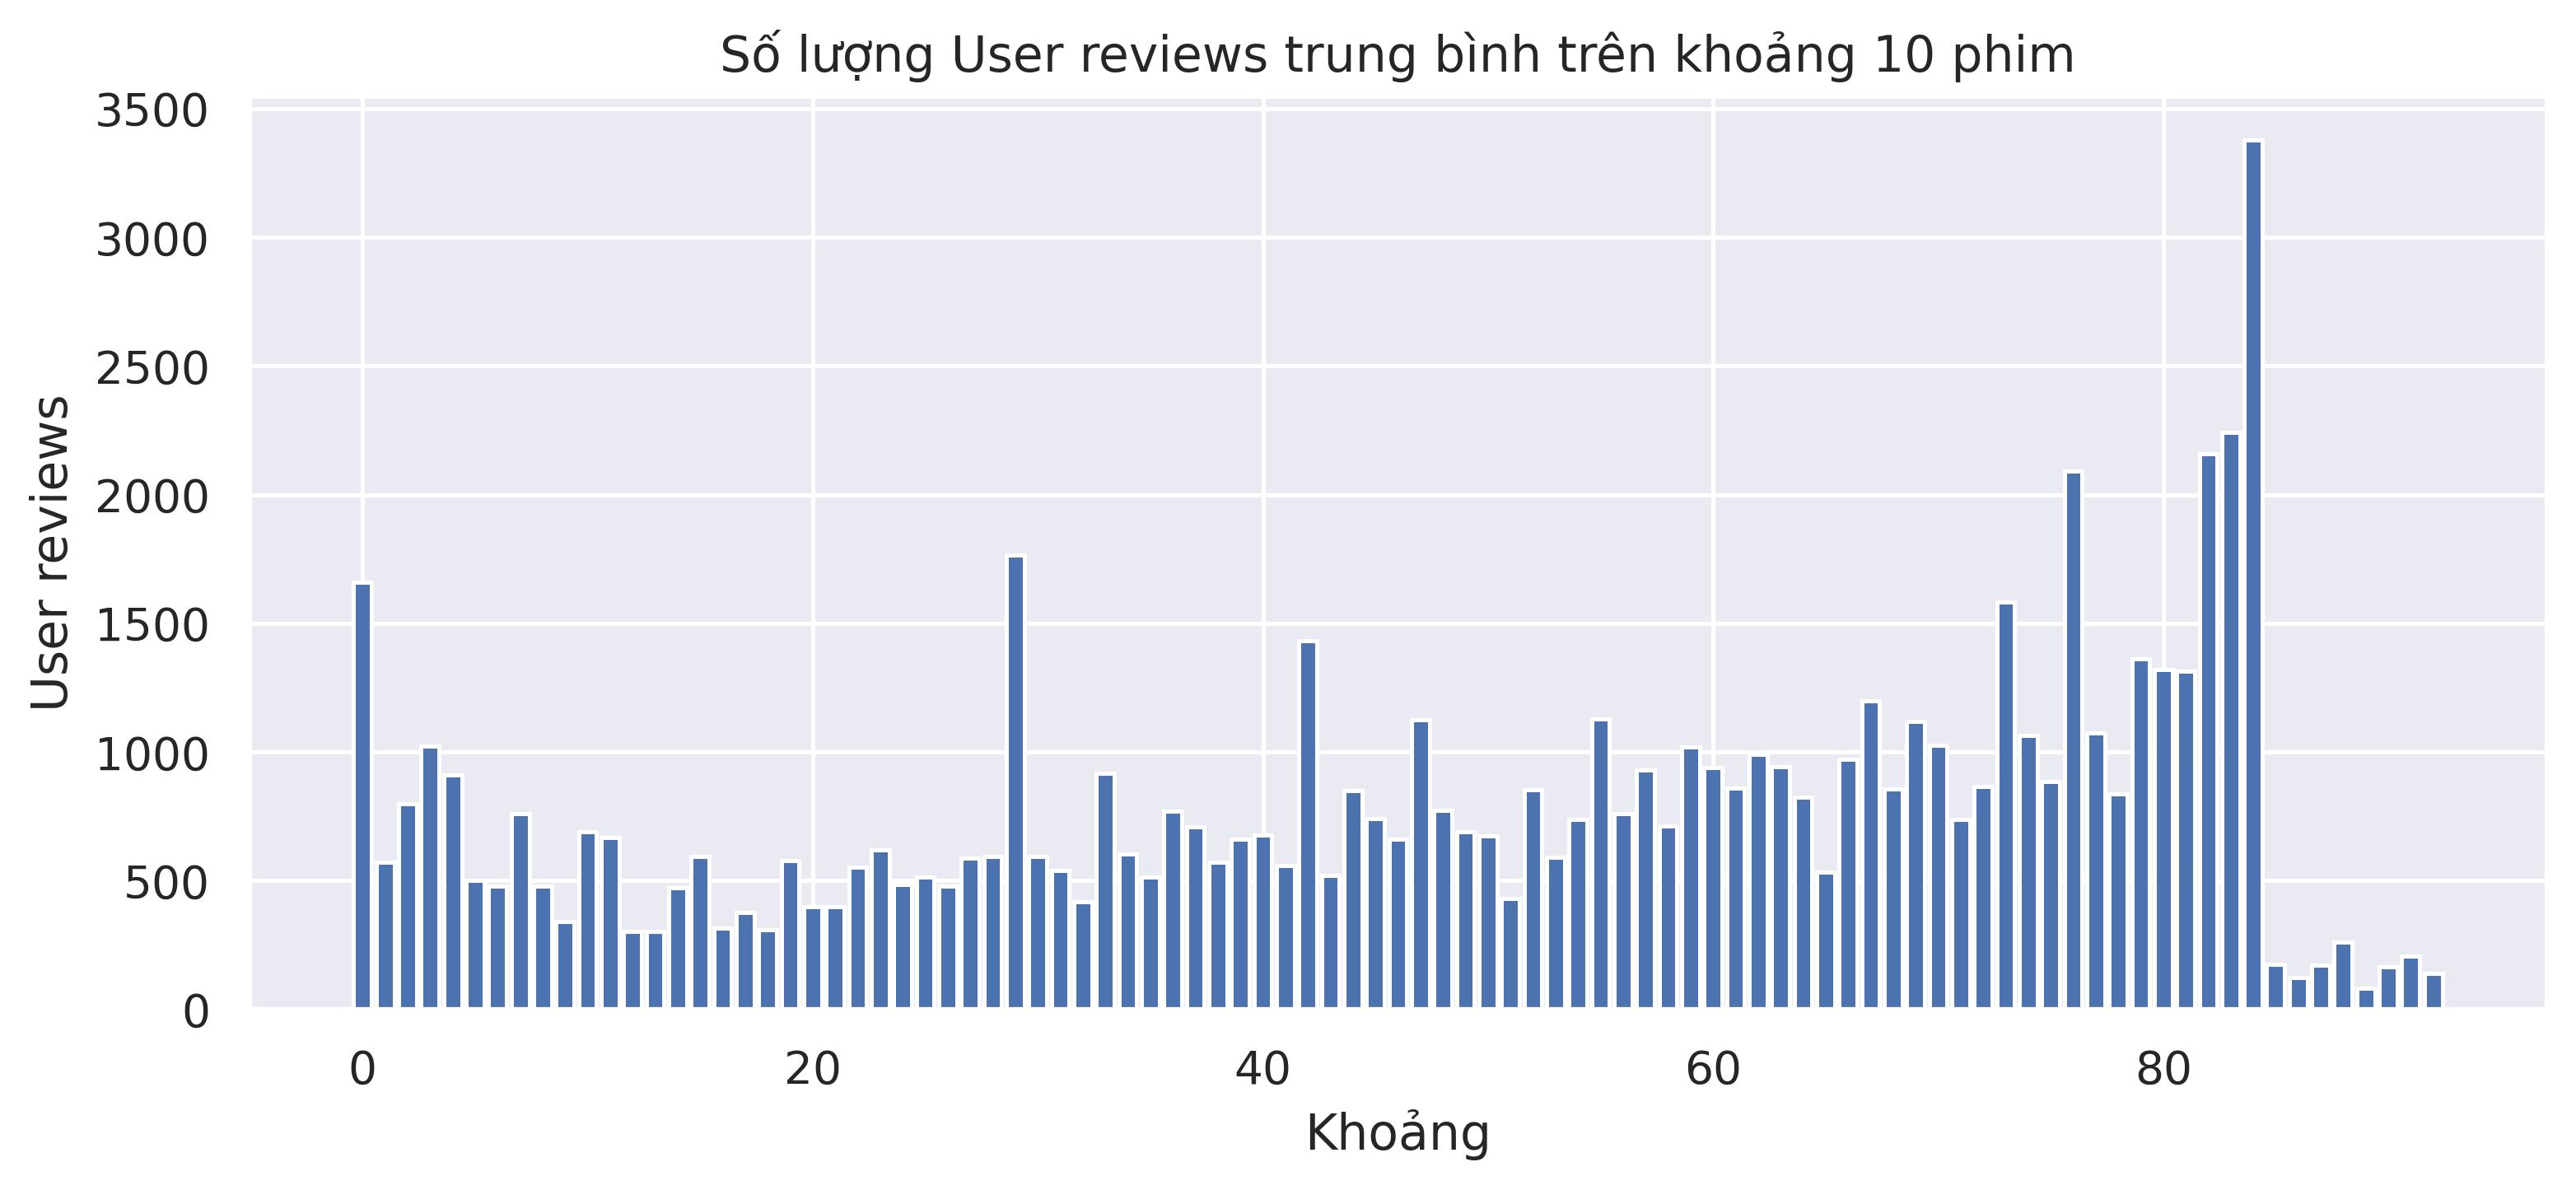

In [92]:
index = np.arange(pos)
fig =plt.subplots(figsize=(10,4))
plt.bar(index, correlate_profit_with_x['User reviews'])
plt.xlabel("Khoảng")
plt.ylabel("User reviews")
plt.title("Số lượng User reviews trung bình trên khoảng 10 phim")

#### Nhận xét: 

- Quan sát biểu đồ ta thấy từ khoảng 20 trở lên số lượng user reviews tăng có phần ổn định cho đến cuối
- Tuy vẫn còn có những giá trị nhiễu cao một cách đột biến nhưng vẫn không ảnh hướng nhiều đến chiều hướng tăng số lượng user reviews khi tắng lượng nhuận

=> số lượng user reviews phản ảnh khá rõ ràng nếu tắng số lượng user reviews thì lợi nhuận sẽ tăng.

Text(0.5, 1.0, 'Điểm IMDb RATING trung bình trên khoảng 10 phim')

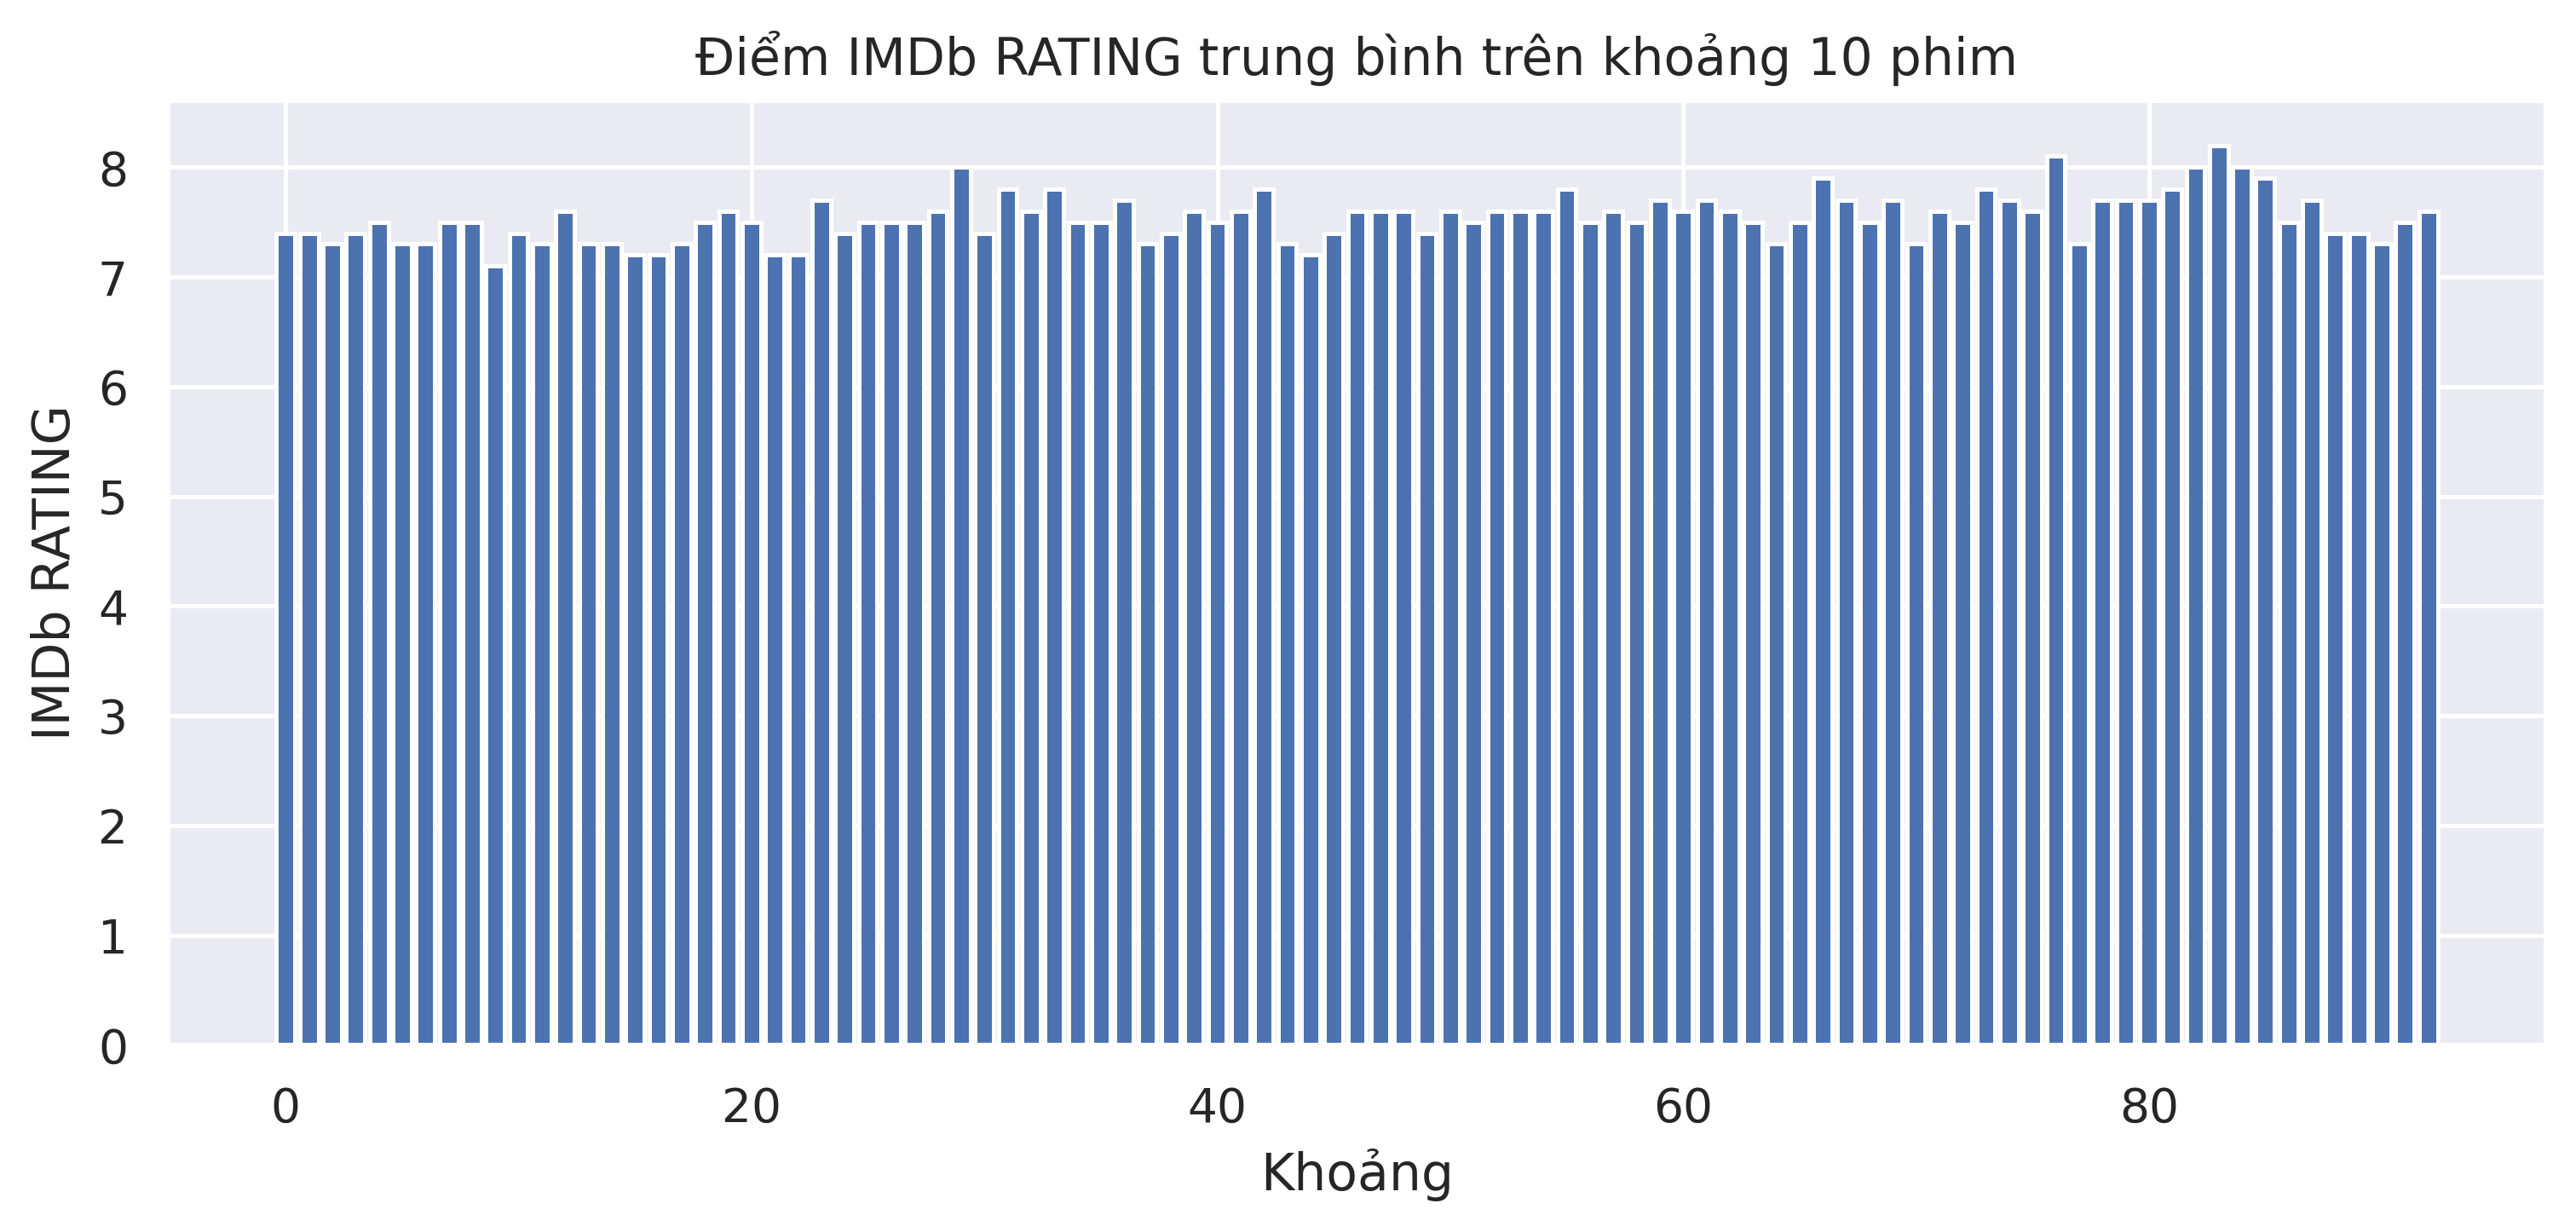

In [93]:
index = np.arange(pos)
fig =plt.subplots(figsize=(10,4))
plt.bar(index, correlate_profit_with_x['IMDb RATING'])
plt.xlabel("Khoảng")
plt.ylabel("IMDb RATING")
plt.title("Điểm IMDb RATING trung bình trên khoảng 10 phim")

#### Nhận xét: 

- Tương tự biển đồ meta score cần quan sát kĩ mới thất điểm IMDb RATING từ sau khoảng thứ 55 có phần cao ổn định hơn 1 tí so với các khoảng đầu 

=> Điểm IMDb RATING nới về chất lượng phim, việc phim được khởi chiếu với mọi người chắc chắn đã đảm bảo được phần nào về chất lượng nên điểm trung bình tất cả phim sẽ đạt ngưỡng trên 7 điểm, khó đánh giá tương quan IMDb RATING với lợi nhuận. Các phim chất lượng nhỉnh hơn một tí có xu hướng lợi nhuận cao hơn. 

Text(0.5, 1.0, 'Số lượng Votes trung bình trên khoảng 10 phim')

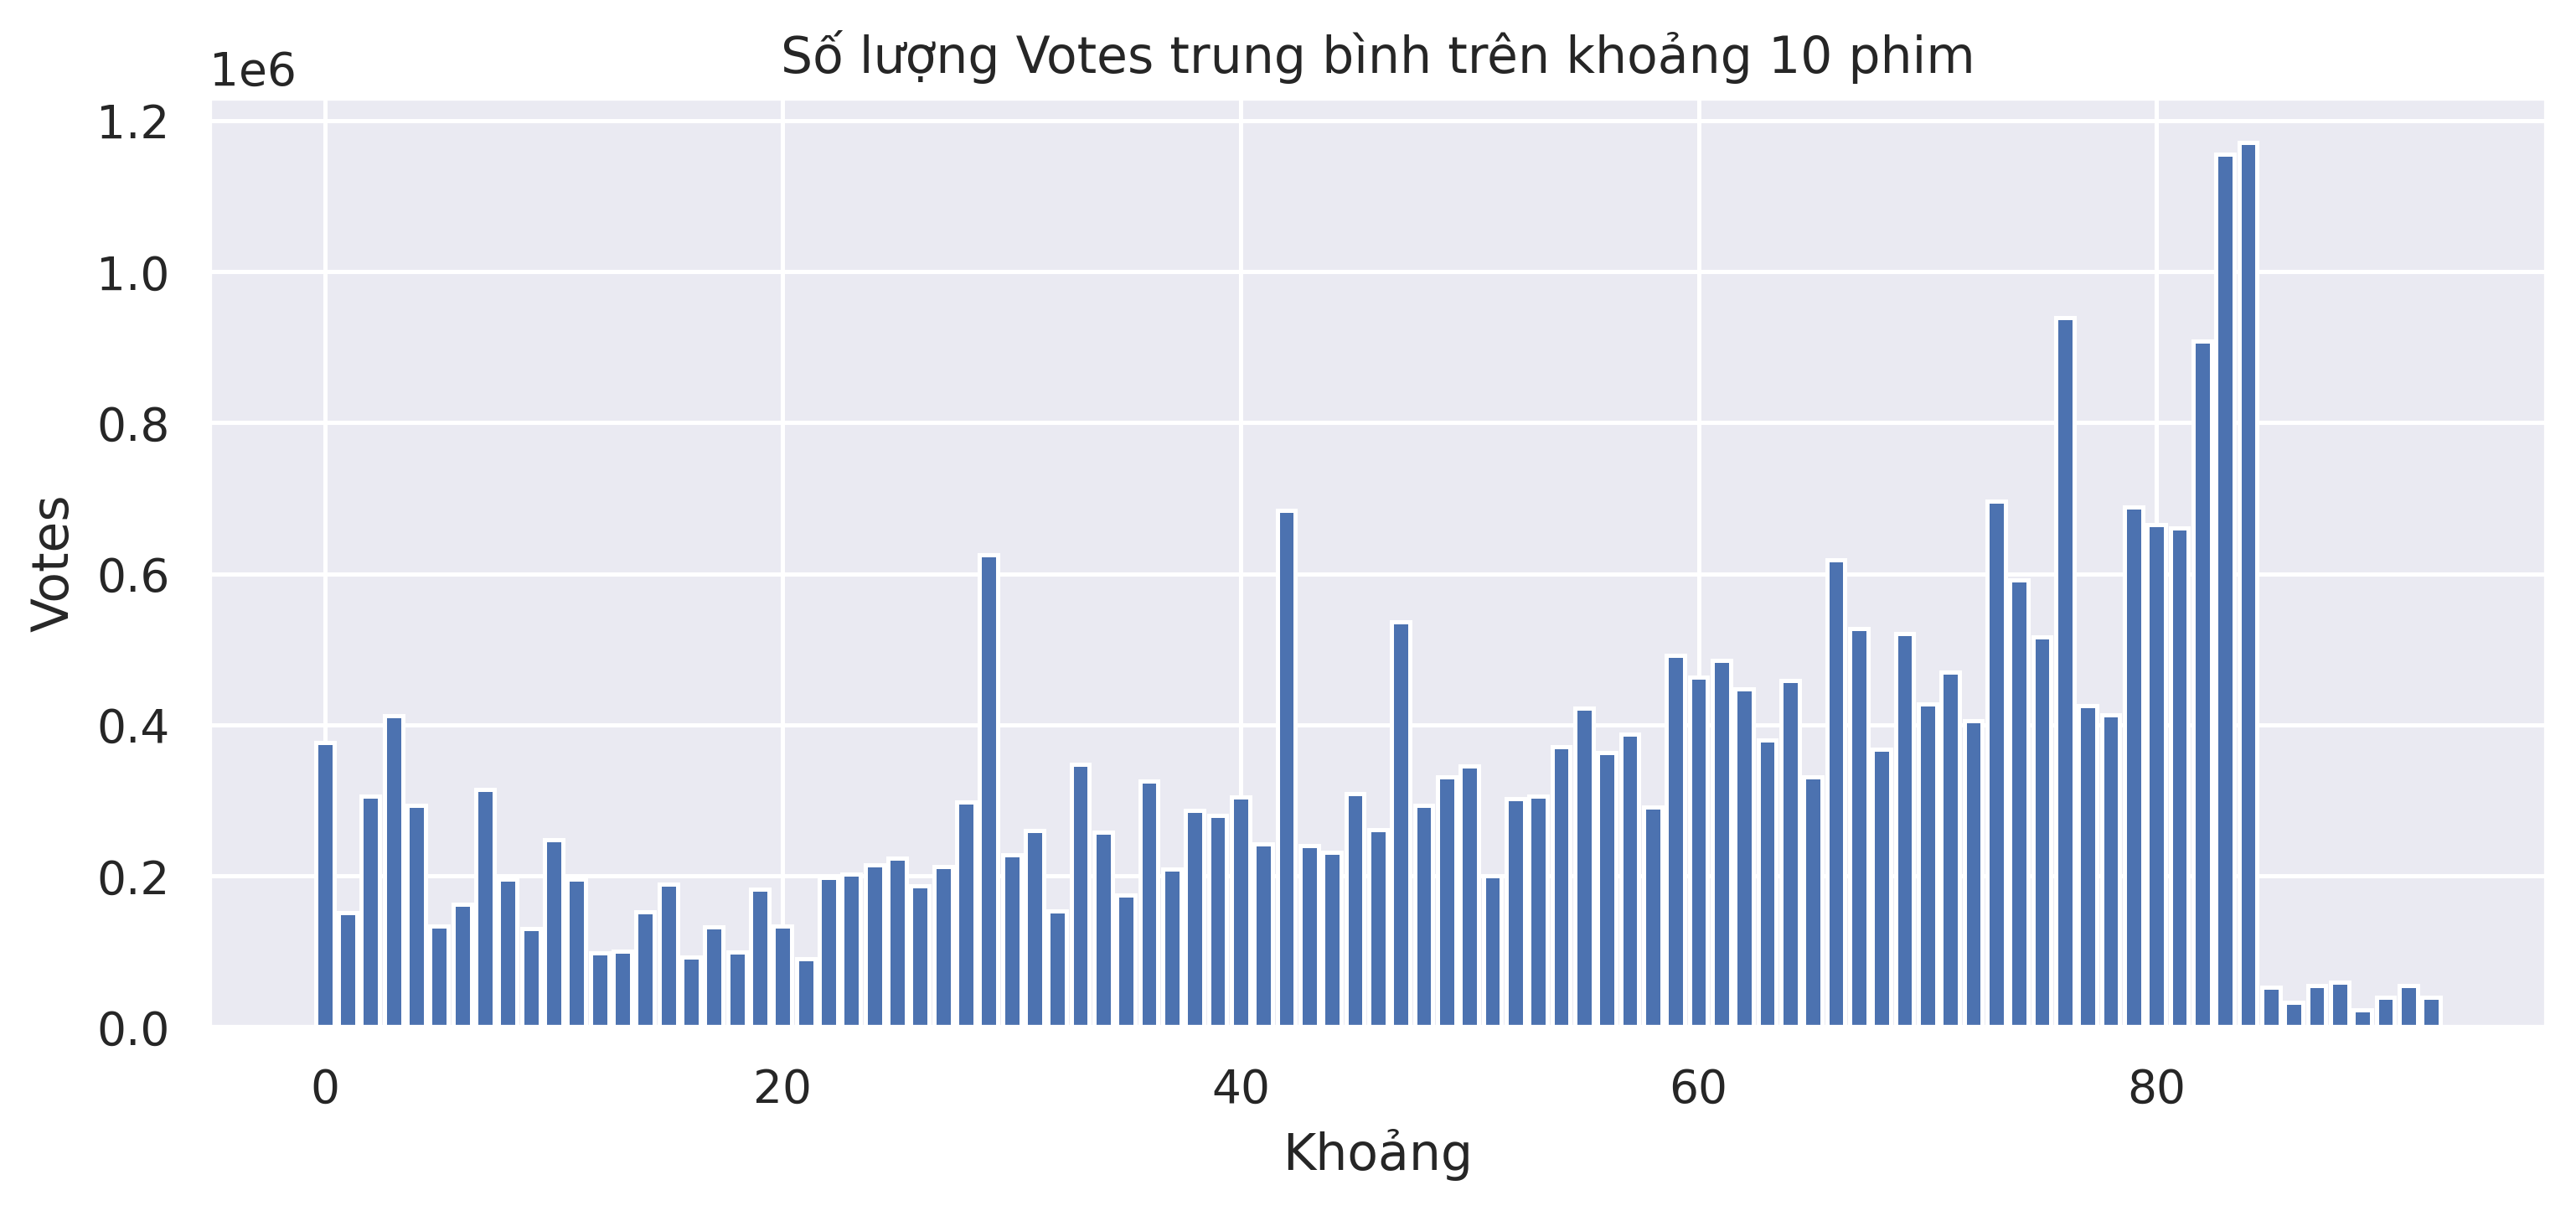

In [94]:
index = np.arange(pos)
fig =plt.subplots(figsize=(10,4))
plt.bar(index, correlate_profit_with_x['Votes'])
plt.xlabel("Khoảng")
plt.ylabel("Votes")
plt.title("Số lượng Votes trung bình trên khoảng 10 phim")

#### Nhận xét: 

- Quan sát biểu đồ tương tự như user reviews ta thấy từ khoảng 20 trở lên số lượng votes tăng có phần ổn định cho đến cuối
- Tuy vẫn còn có những giá trị nhiễu cao một cách đột biến nhưng vẫn không ảnh hướng nhiều đến chiều hướng tăng số lượng votes khi tắng lợi nhuận

=> số lượng votes phản ảnh khá rõ ràng nếu số lượng votes tắng cao thì lợi nhuận sẽ tăng.

Text(0.5, 1.0, 'độ Popularity trung bình trên khoảng 10 phim')

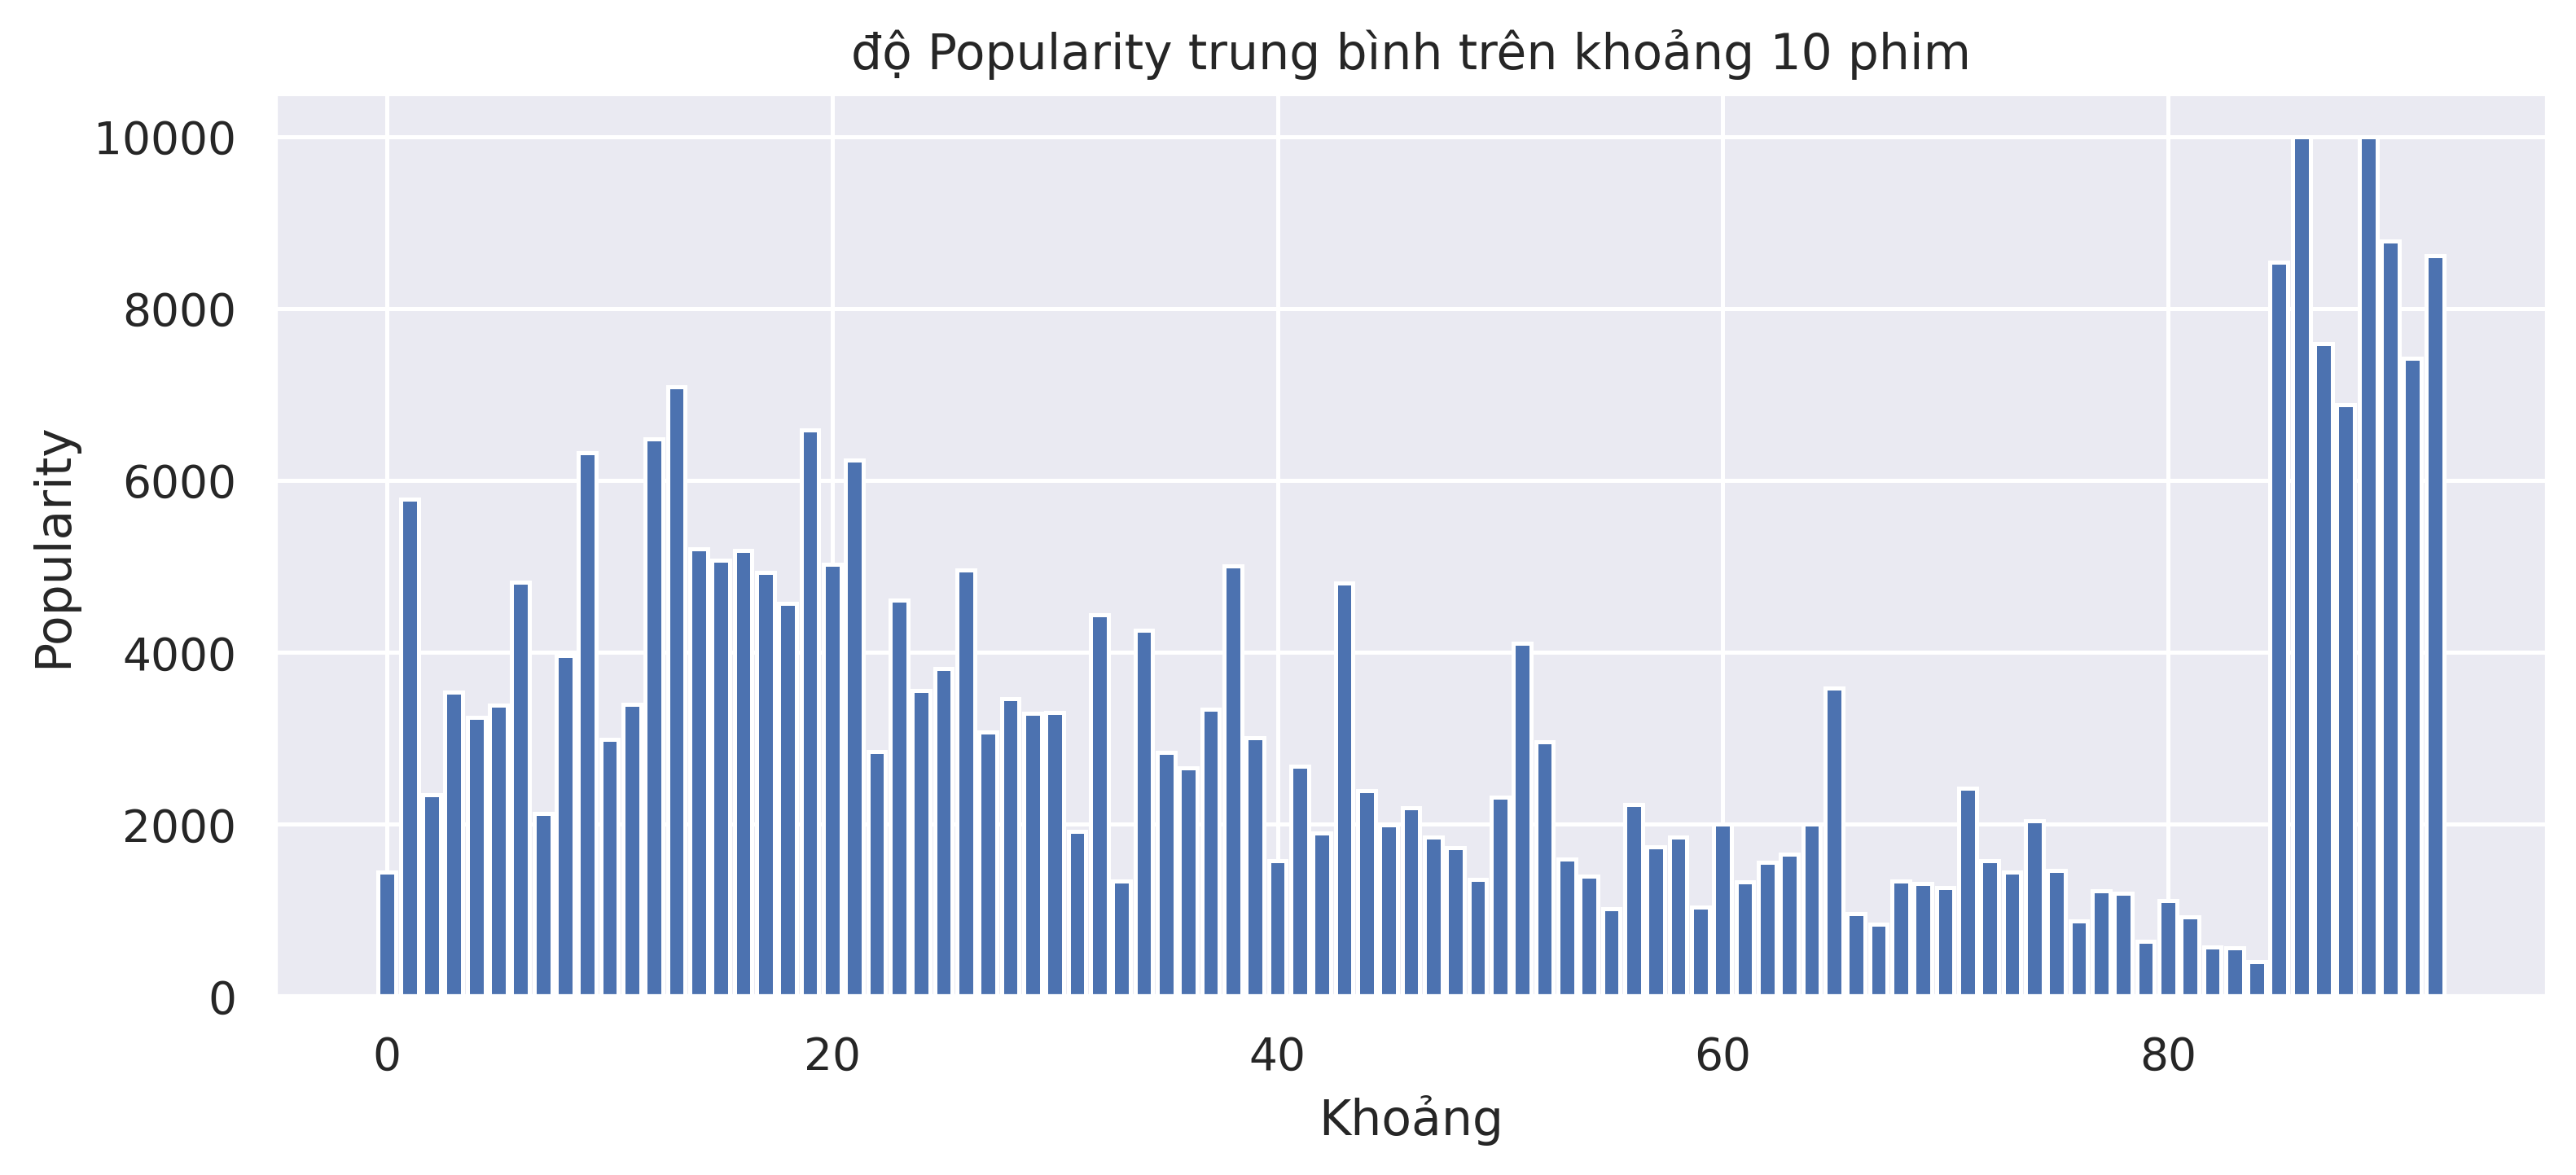

In [95]:
index = np.arange(pos)
fig =plt.subplots(figsize=(10,4))
plt.bar(index, correlate_profit_with_x['Popularity'])
plt.xlabel("Khoảng")
plt.ylabel("Popularity")
plt.title("độ Popularity trung bình trên khoảng 10 phim")

#### Nhận xét: 

* Độ Popularity có thể thay đổi tăng giảm sau khoảng thời gian mà không cố định. Tưởng chừng như vậy nhưng nó vẫn phản ảnh lên được rằng các phim có top cao (càng nhỏ) thì thường lợi nhuận cao.
* Biểu đồ có xu hướng giảm khi đi về cuối giảm dần, tuy vẫn còn dữ liệu nhiễu tăng bất thường trên đường giảm những cũng không quá ảnh hưởng. 

#### Kết luận:
- Ta có thể dựa vào các yếu tố như: User reviews, Votes là các chỉ số phán ánh rõ ràng nhất trược tiếp từ người xem mà suy luận khả năng sinh lợi nhuận của một phim -> từ đó phán đoán phim có đánh vào đại đa số kháng giả không mà mà sản xuất, hay sáu khi khởi chiểu dự đoán danh thu có vao không.
- Song ta cũng có thể dự vào các yếu tố như: IMDb RATING, Meta score là các điểm được chấm từ chuyên gia và chất lượng phim, hình ảnh cũng phản ánh khách quan nếu điểm cao thì lợi nhuận cao nhưng đôi khi chuyên môn cũng không phản ánh chính xác mà chỉ phần nào. 
- Không thể dựa vào các yếu tố có thể biến động tăng giảm như Popularity để đánh giá lợi nhuận.

=> Để phán đoán phim làm ra có đạt lợi nhuận cao hay không phần nào có thể đánh giá dự trên các yếu tố như: User reviews, Votes, IMDb RATING, Meta score,... Nhưng đôi lúc cũng không hoàn toàn chính bởi các yếu tố khách quan hay chủ quan nào đó nên mới có các phim lỗ dù đầu tư cao về nhiều mặt. 

---

<h1 style="color:orange">PHẦN 2: MÔ HÌNH HÓA DỮ LIỆU</h1>

<h2 style="color:orange">Mô hình hóa dữ liệu</h2>

<h2>Bài toán đặt ra:</h2> 

- Chúng ta đã biết rằng, có rất nhiều kiểu để phân loại một bộ phim. Ví dụ như, phân loại theo thể loại: Hành động, Phiêu lưu, Chính kịch,... , theo độ tuổi xem, R, PG, G,... Hay cũng có xếp hạng theo điểm IMDb, theo độ nổi tiếng. Vậy liệu rắng chúng ta có thể dựa trên các thông tin ở trên để đáng giá một bộ phim thành công nhiều hay ít không.

<h2>Hướng giải quyết:</h2>

- Để giải quyết vấn đề trên nhóm quyết định dựa trên các thuật toán hỗ trợ trong `Sklearn` để cố phân cụm các phim, nhằm đánh giá mức thành công của bộ phim đó.
    
- Dựa trên nhưng giá trị ở các cột để phân cụm:
    - IMDb RATING
    - Popularity
    - Meta score
    - Budget
    - Gross
    - Wins

- Thuật toán sử dụng:
    - K-Means + One hot encoding
    - K-Prototypes: là thuật toán kệt hợp giữa K-Means và K-Modes
    - K-Means: Tự xử lý thông tin 
    
- Giải thích sử dụng thuật toán:
    - Có 2 kiểu dữ liệu numerical và category.

    hyperparameters of clustering BDSCAN

<h3>Tiền xử lý cho dữ liệu mô hình (tiếp tục)</h3>

In [96]:
cluster_df=cluster_full_info_df.loc[:,['IMDb RATING','Popularity','Meta score','Budget (estimated)','Gross','Wins']]
cluster_df.head(10)

,IMDb RATING,Popularity,Meta score,Budget (estimated),Gross,Wins
0,9.2,92.0,100.0,6000000.0,134966411.0,Won 3 Oscars
1,8.7,194.0,90.0,25000000.0,46836394.0,Won 1 Oscar
2,8.9,115.0,94.0,8000000.0,107928762.0,Won 1 Oscar
3,8.5,425.0,77.0,6000000.0,23341568.0,Won 2 Oscars
4,8.5,307.0,94.0,31500000.0,83471511.0,Won 2 Oscars
5,8.1,784.0,83.0,1830000.0,16501785.0,Nominated for 1 Oscar
6,8.8,139.0,66.0,63000000.0,37030102.0,Nominated for 1 Oscar
7,9.0,219.0,94.0,22000000.0,96898818.0,Won 7 Oscars
8,7.9,462.0,85.0,15000000.0,26400640.0,Nominated for 3 Oscars
9,8.3,381.0,79.0,1200000.0,2832029.0,Awards


In [97]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IMDb RATING         1000 non-null   float64
 1   Popularity          782 non-null    float64
 2   Meta score          963 non-null    float64
 3   Budget (estimated)  895 non-null    float64
 4   Gross               937 non-null    float64
 5   Wins                984 non-null    object 
dtypes: float64(5), object(1)
memory usage: 87.0+ KB


Text(0.5, 1.0, 'Percent missing data by feature')

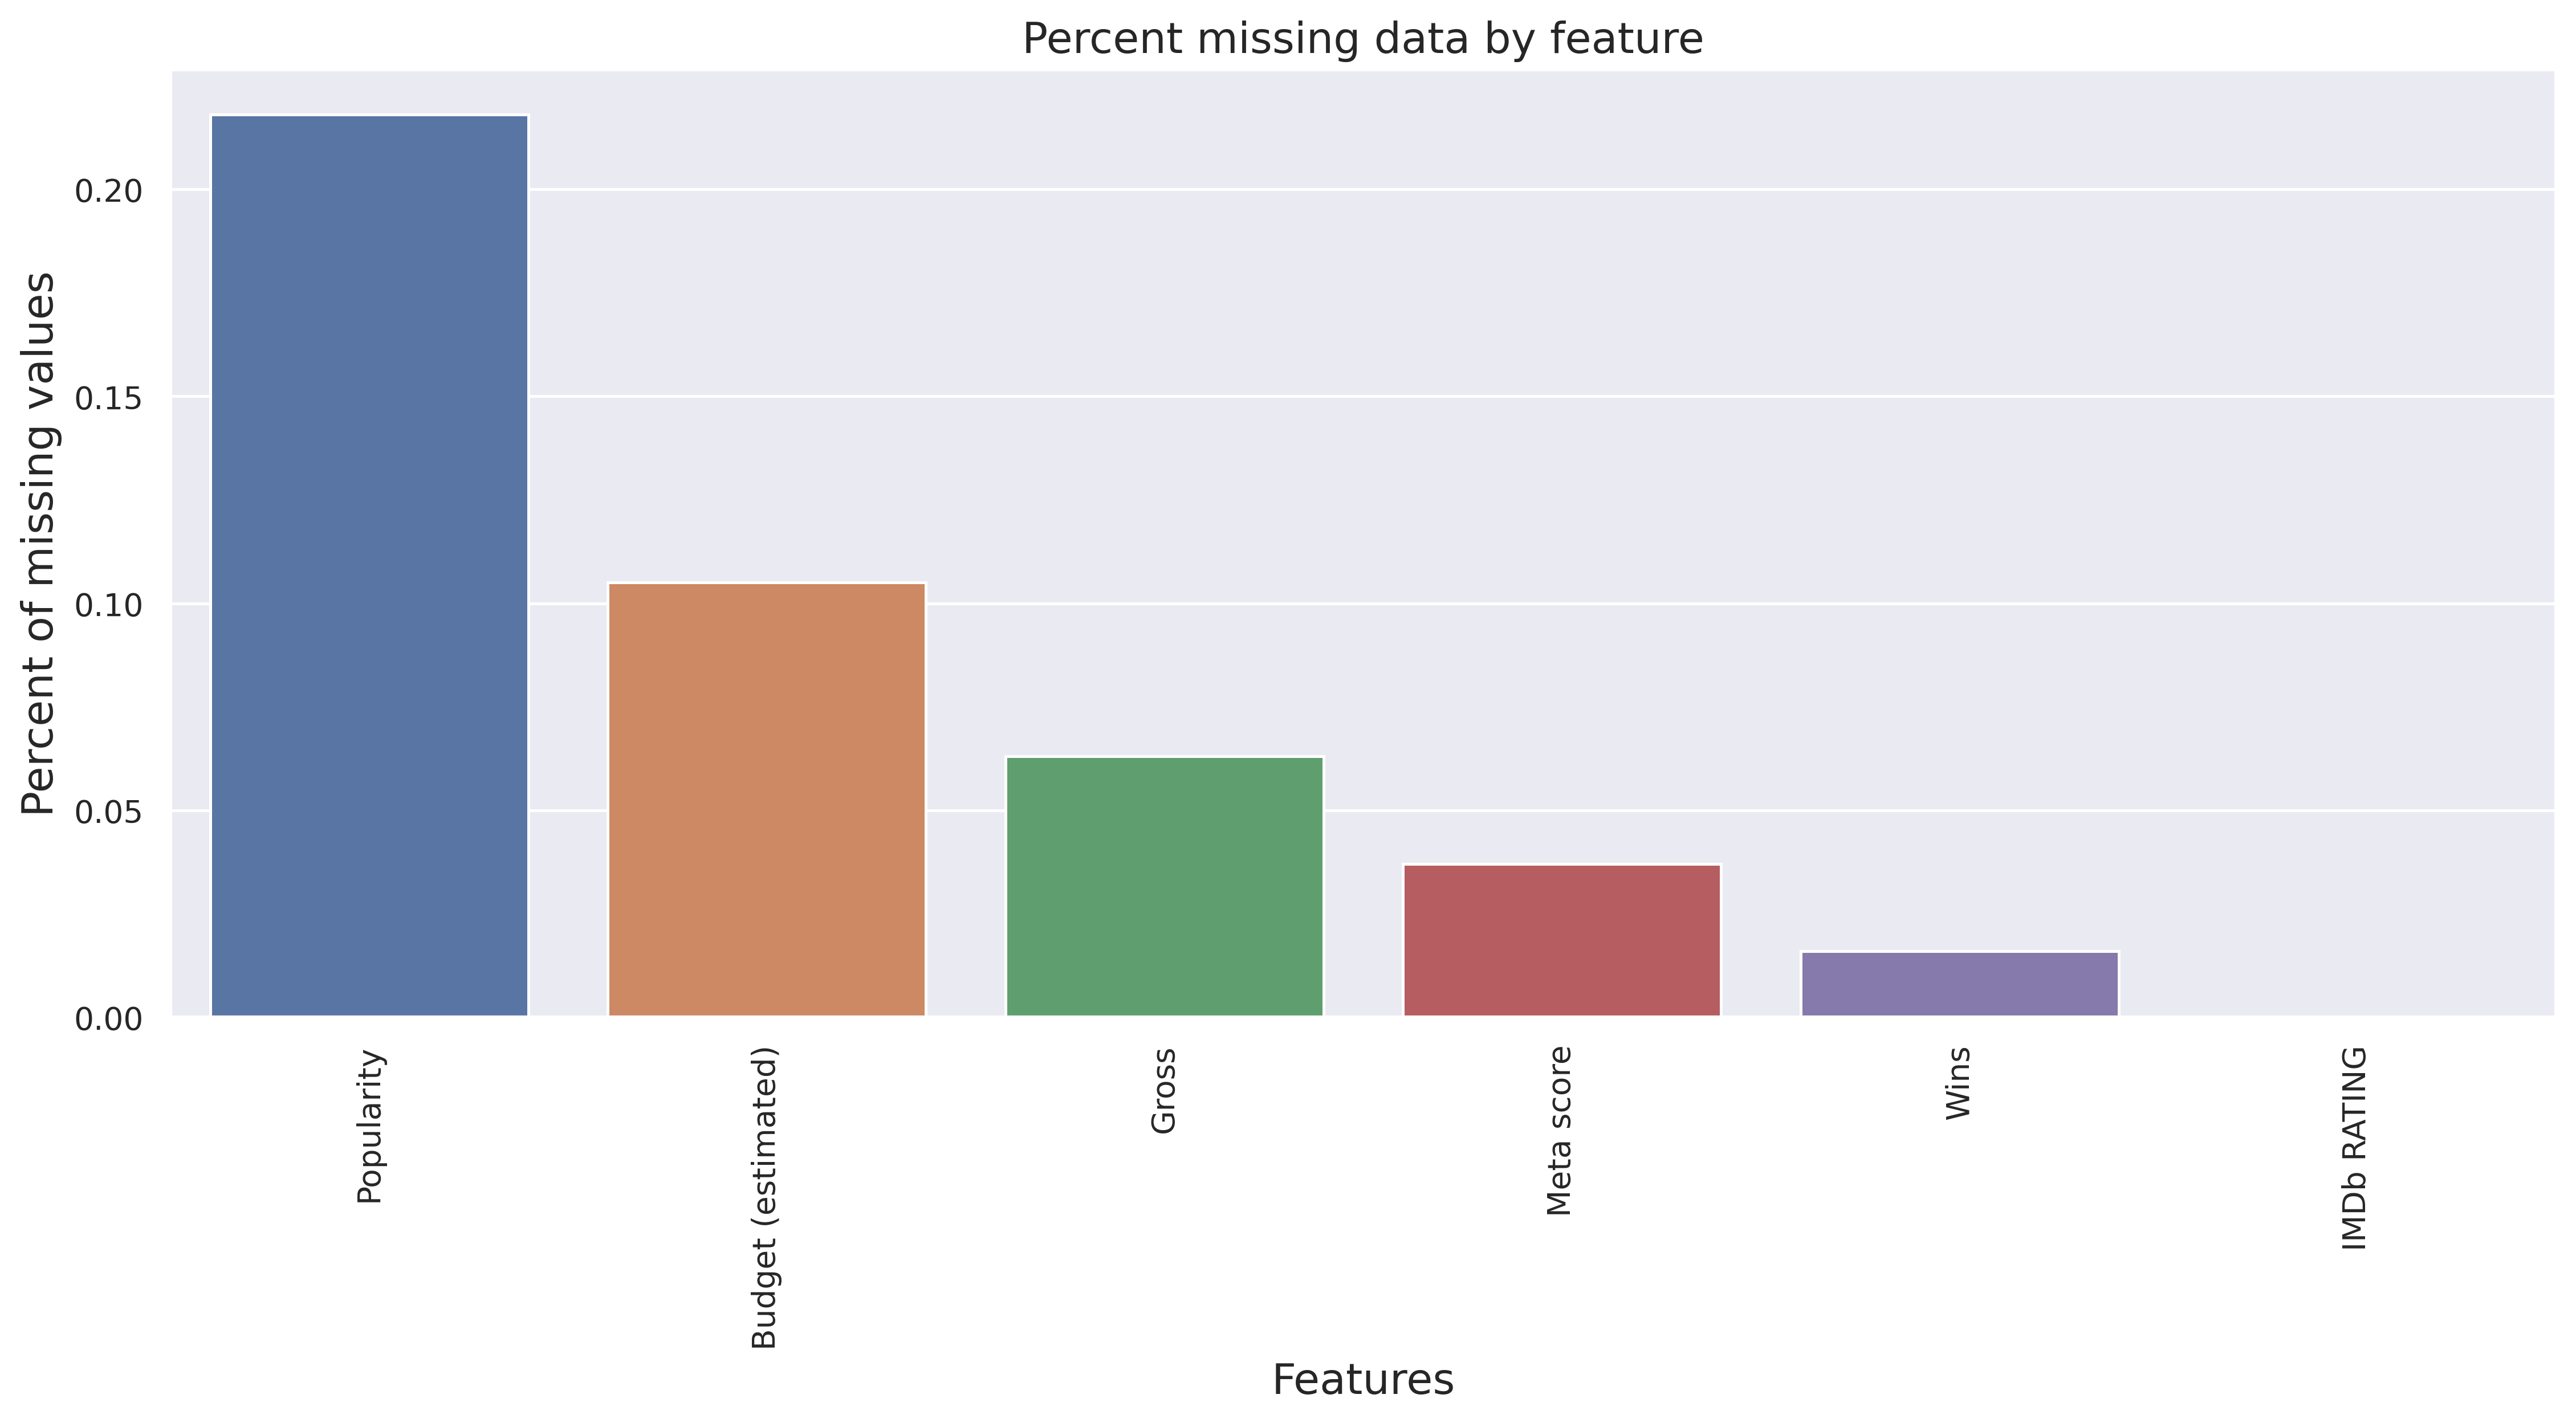

In [98]:
total = cluster_df.isnull().sum().sort_values(ascending=False)
percent = (cluster_df.isnull().sum()/cluster_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

<h4>Xóa các dòng thiếu hơn 2 ô dữ liệu</h4>

In [99]:
cluster_df.dropna(thresh=4,axis=0,inplace=True)
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IMDb RATING         964 non-null    float64
 1   Popularity          779 non-null    float64
 2   Meta score          954 non-null    float64
 3   Budget (estimated)  885 non-null    float64
 4   Gross               931 non-null    float64
 5   Wins                953 non-null    object 
dtypes: float64(5), object(1)
memory usage: 52.7+ KB


<h4>Thực hiện điền giá trị <b>mean</b> vào các ô của các cột dữ liệu numerical</h4>

In [100]:
mean=cluster_df.mean()
mean

IMDb RATING           7.542635e+00
Popularity            1.729376e+03
Meta score            7.436792e+01
Budget (estimated)    3.451354e+07
Gross                 7.106062e+07
dtype: float64

In [101]:
cluster_df['IMDb RATING']=cluster_df['IMDb RATING'].replace(np.nan,mean[0])
cluster_df.Popularity=cluster_df.Popularity.replace(np.nan,mean[1])
cluster_df['Meta score']=cluster_df['Meta score'].replace(np.nan,mean[2])
cluster_df['Budget (estimated)']=cluster_df['Budget (estimated)'].replace(np.nan,mean[3])
cluster_df.Gross=cluster_df.Gross.replace(np.nan,mean[4])

#### Trong dữ liệu ta thấy `Budget` và `Gross` là 2 cột có giá trị trái nhau
- Thực hiện lấy `Gross` \- `Budget`

In [102]:
balance=cluster_df['Gross']-cluster_df['Budget (estimated)']
cluster_df.insert(3,"Balance",np.array(balance.values))
cluster_df

,IMDb RATING,Popularity,Meta score,Balance,Budget (estimated),Gross,Wins
0,9.2,92.0,100.0,128966411.0,6000000.0,134966411.0,Won 3 Oscars
1,8.7,194.0,90.0,21836394.0,25000000.0,46836394.0,Won 1 Oscar
2,8.9,115.0,94.0,99928762.0,8000000.0,107928762.0,Won 1 Oscar
3,8.5,425.0,77.0,17341568.0,6000000.0,23341568.0,Won 2 Oscars
4,8.5,307.0,94.0,51971511.0,31500000.0,83471511.0,Won 2 Oscars
...,...,...,...,...,...,...,...
995,6.7,2463.0,52.0,28348319.0,54000000.0,82348319.0,Awards
996,7.6,1362.0,56.0,15903593.0,25000000.0,40903593.0,Awards
997,7.5,206.0,68.0,-9308792.0,65000000.0,55691208.0,Awards
998,7.2,1207.0,63.0,23722567.0,8500000.0,32222567.0,Awards


In [103]:
cluster_df.drop(['Budget (estimated)','Gross'], axis=1, inplace=True)

In [104]:
cluster_full_info_df.Wins.unique()

array(['Won 3 Oscars', 'Won 1 Oscar', 'Won 2 Oscars',
       'Nominated for 1 Oscar', 'Won 7 Oscars', 'Nominated for 3 Oscars',
       'Awards', 'Nominated for 7 Oscars', 'Nominated for 4 Oscars',
       'Won 6 Oscars', 'Won 4 Oscars', 'Won 5 Oscars',
       'Won 2 BAFTA Awards', 'Won 1 BAFTA Award',
       'Nominated for 2 Oscars', 'Won 11 Oscars',
       'Nominated for 1 BAFTA Award', 'Nominated for 5 BAFTA Awards',
       'Nominated for 5 Oscars', 'Won 8 Oscars', 'Nominated for 6 Oscars',
       'Nominated for 2 BAFTA Awards', 'Nominated for 10 Oscars', None,
       'Nominated for 3 BAFTA Awards', 'Nominated for 8 Oscars',
       'Nominated for 2 Primetime Emmys',
       'Nominated for 3 Primetime Emmys', 'Won 2 Primetime Emmys',
       'Nominated for 1 Primetime Emmy'], dtype=object)

<h2>Method 1: K-Means</h2>

#### Xử lý giá cột `Wins`:

- Theo như tìm hiểu trên mạng, nhóm thấy 1 phim trung bình sẽ có thể nhận đến [tối đa 40 đề cử Oscar](https://www.quora.com/How-many-oscar-nominations-can-be-made-for-one-movie-at-maximum), và trong 1 nội dung thắng, thì trung bình có 5 đề cứ. Nên ở đây nhóm mình sẽ cố gắng quy đổi thông tin các giải thưởng mà phim nhận được thành dạng numerical.
- Xem như các giải thưởng thắng được là như ngang nhau trong thứ bậc, và đề cử có đồng giá trị như nhau. Ở đây:
    - 1 Win = 5 Nominations
    - 1 Nomination = 1 Award
    - None = 0
- Mặt khác nhóm còn muốn cột `Wins` đóng vai trò lớn nhất trong phần quyết định rằng phim đó thành công ra sao (Do không có quy ước nào 1 giải sẽ tương ứng với bao nhiêu USD :p, nên nhóm sẽ lấy mean của Balance làm hệ số chung dể nhân lên)


In [105]:
mean_blc=cluster_df.Balance.mean()
def calc_wins(st):
    if st!=None:
        num=re.findall(r'\d{1,2}',str(st))
        if len(num)==0:
            return mean_blc
        if len(re.findall(r'Won',str(st)))>0:
            return 5*int(num[0])*mean_blc
        return int(num[0])*mean_blc
    return 0
    
cluster_df.Wins=cluster_df.Wins.apply(calc_wins)
cluster_df.Wins.unique()

array([5.48206163e+08, 1.82735388e+08, 3.65470775e+08, 3.65470775e+07,
       1.27914771e+09, 1.09641233e+08, 2.55829543e+08, 1.46188310e+08,
       1.09641233e+09, 7.30941551e+08, 9.13676939e+08, 7.30941551e+07,
       2.01008926e+09, 1.46188310e+09, 2.19282465e+08, 0.00000000e+00,
       2.92376620e+08])

<h3>Chạy mô hình</h3>

In [106]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [107]:
X=cluster_df.iloc[:,:5]
X

,IMDb RATING,Popularity,Meta score,Balance,Wins
0,9.2,92.0,100.0,128966411.0,5.482062e+08
1,8.7,194.0,90.0,21836394.0,1.827354e+08
2,8.9,115.0,94.0,99928762.0,1.827354e+08
3,8.5,425.0,77.0,17341568.0,3.654708e+08
4,8.5,307.0,94.0,51971511.0,3.654708e+08
...,...,...,...,...,...
995,6.7,2463.0,52.0,28348319.0,3.654708e+07
996,7.6,1362.0,56.0,15903593.0,3.654708e+07
997,7.5,206.0,68.0,-9308792.0,3.654708e+07
998,7.2,1207.0,63.0,23722567.0,3.654708e+07


<h4>Những siêu tham số cần xác định trong mô hình phân cụm theo K-Means:</h4>

- n_nit: Số lần khởi tạo tâm và chọn giá trị hội tụ phù hợp nhất **(default=10)**, Nhóm muốn tăng số lần khởi tạo để có thể quét được nhiều nhất không gian của đối tượng đó. Chọn `n_nit=50`
- max_iter: Với n_init lần chạy và mỗi lần chạy lặp lại max_iter lần **(default=300)**, được hiểu trong một lần chạy, điểm sẽ được gán cho các cụm khác nhau và chi phí được tính cho max_iter lần. Với max_iter ở giá trị cao, thì ta được đảm bảo rằng sẽ khám phá toàn bộ không gian đối tượng, nhưng đồng nghĩa với chi phí sẽ tăng lên. Chọn `max_iter=500`
- nit: tọa độ tâm của cụm: với lượng dữ liệu lớn, khó để xác định được đúng tâm, nên ở đây nhóm để ở `nit='random'`
- random_state: là hạt giống sinh số ngẫu nhiên, nhằm tránh việc mỗi lần cho ra kết quả khác nhau. Ta có thể chọn bất kỳ giá trị nào, ở đây nhóm chọn `random_state=2020` 
- n_clusters: đóng vai trò **quan trọng nhất**, số cụm, ở đây ngoài cách thử và sai ra thì, khó có thể chọn được siêu tham số này một cách phù hợp nhất. Thử và sai `n_clusters=[2,10]`

In [108]:
for i in range(2,11,1):
    kmean=KMeans(n_clusters=i,init='random',n_init=50,max_iter=500, random_state=2020)
    cluster_df['Clusters']=kmean.fit_predict(X)
    kmean.fit(X)

<h2 style="color:orange">Đánh giá mô hình</h2>

#### Dựa trên SSE do hàm kmeans.inertia trả về ta thực hiện vẽ biểu đồ và chọn `n_clusters` phù hợp nhất.

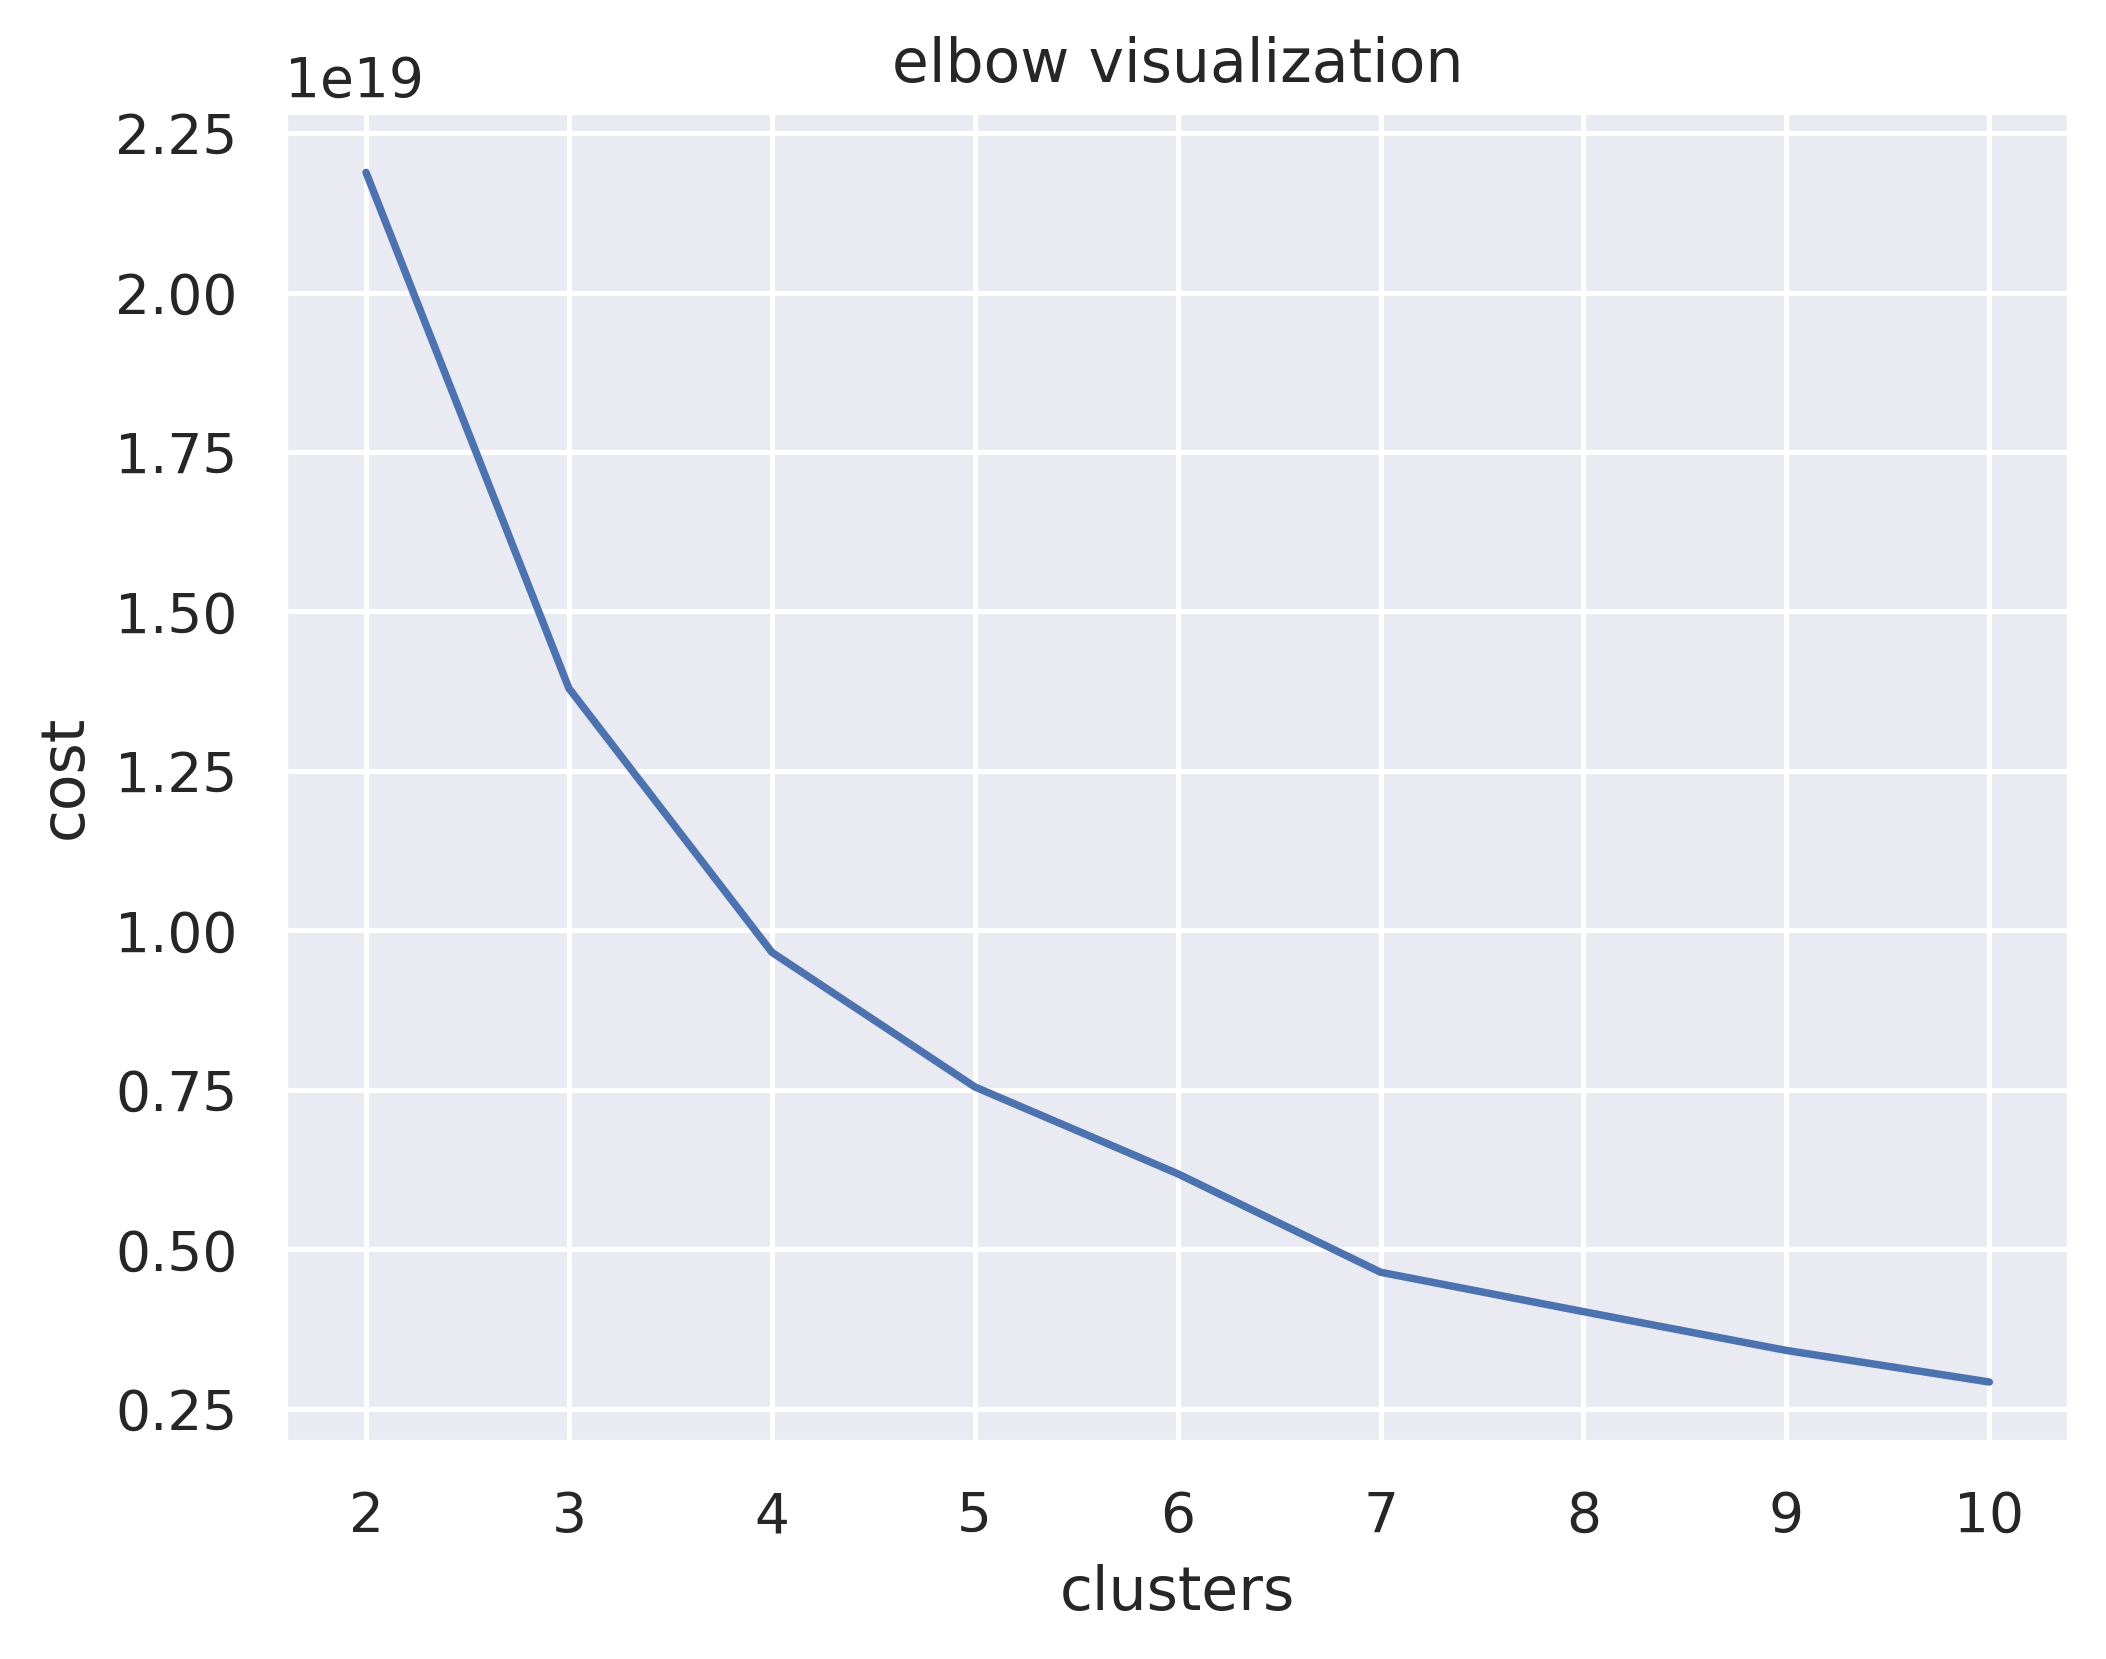

In [109]:
distortions = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

plt.plot(range(2, 11), distortions)
plt.title('elbow visualization')
plt.xlabel('clusters')
plt.ylabel('cost')
plt.show()

<h4>Nhận xét:</h4>

- Ta thấy có sự thay đổi nhiều khi phân từ 2 cụm về 3 cụm. Nhưng khi phân từ 3 cụm trở lên, chi phí không thay đổi nhiều.

#### Kết luận: `n_clusters=3`

<h4>Trực quan kết quả phân cụm với các siêu tham số đã xác định ở trên</h4>

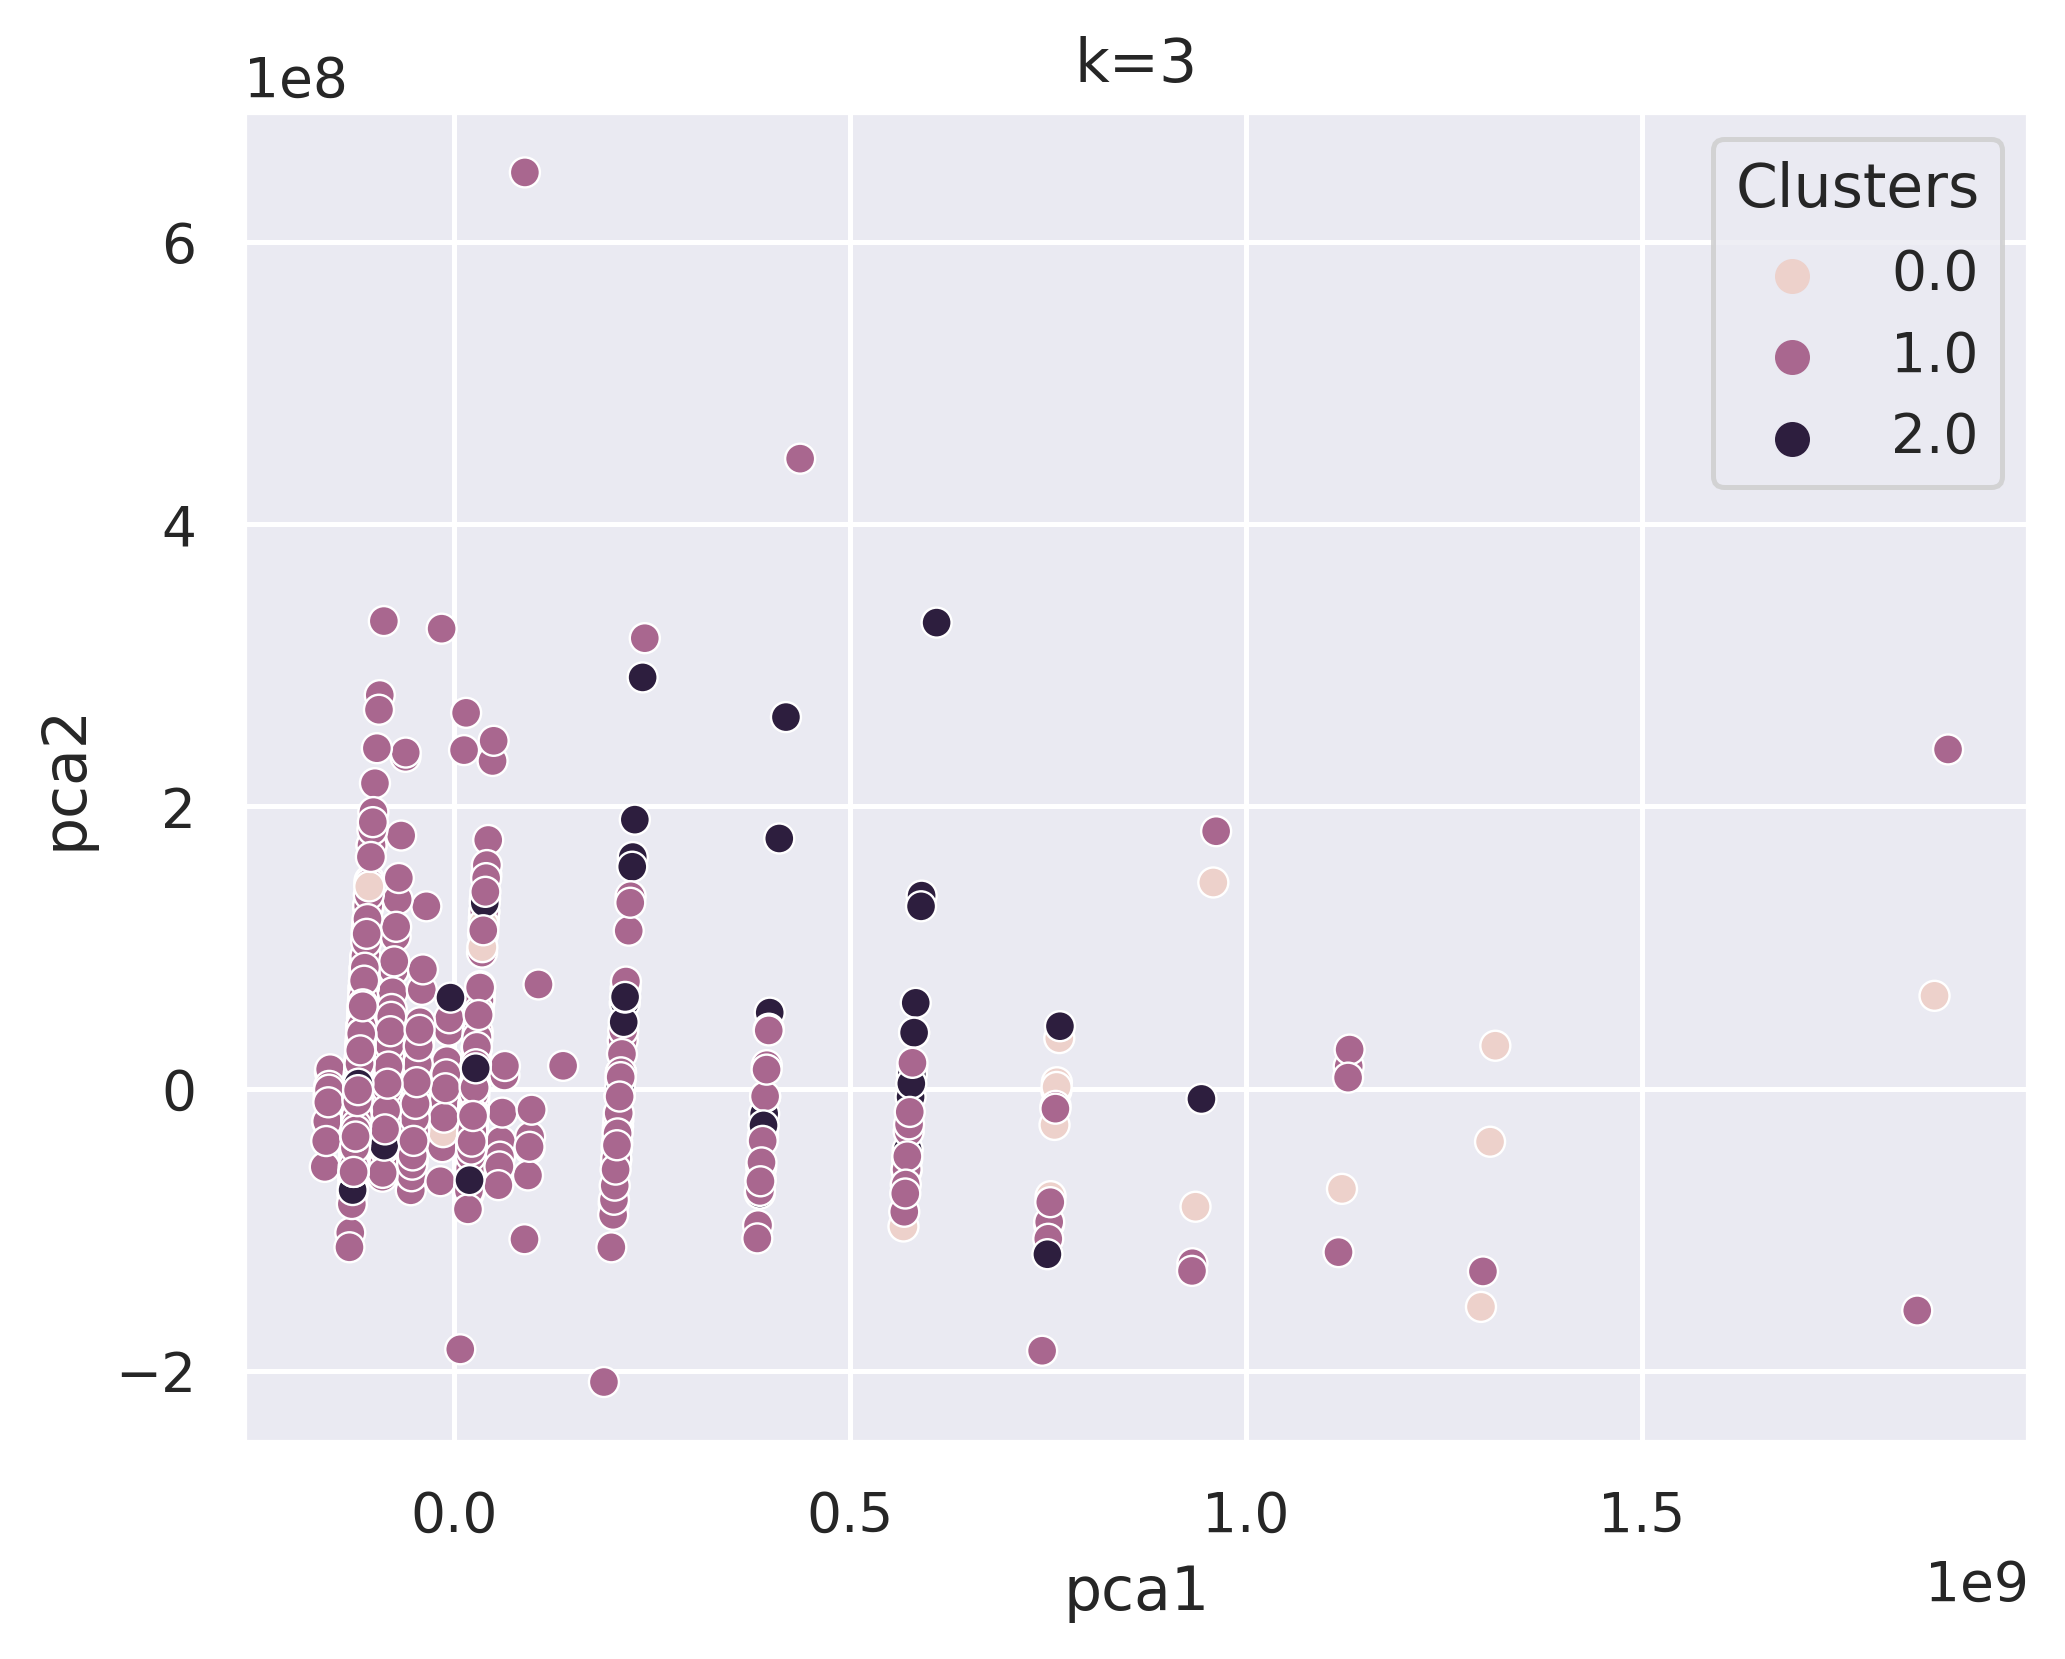

In [110]:
kmean=KMeans(n_clusters=3,init='random',n_init=50,max_iter=500, random_state=2020)
cluster_df['Clusters']=kmean.fit_predict(X)
kmean.fit(X)
reduced_data=PCA(2).fit_transform(X)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=cluster_df.Clusters, data=results)
plt.title(f'k=3')
plt.show()

<h4>Phân cụm các phim theo những cụm mà ta đã xác định ở trên</h4>

In [111]:
cluster_full_info_df_method1=cluster_full_info_df.copy()
cluster_full_info_df_method1["Clusters"]=cluster_df.Clusters
cluster_full_info_df_method1.Clusters=cluster_full_info_df_method1.Clusters.replace(np.nan,-1)

In [112]:
cluster_full_info_df_method1[cluster_full_info_df_method1.Clusters==2].Wins.unique()

array(['Won 3 Oscars', 'Won 2 Oscars', 'Won 4 Oscars',
       'Won 2 BAFTA Awards', 'Nominated for 10 Oscars',
       'Nominated for 8 Oscars'], dtype=object)

In [113]:
cluster_full_info_df_method1[cluster_full_info_df_method1.Clusters==1].Wins.unique()

array(['Won 1 Oscar', 'Nominated for 1 Oscar', 'Nominated for 3 Oscars',
       'Awards', 'Nominated for 7 Oscars', 'Nominated for 4 Oscars',
       'Won 1 BAFTA Award', 'Nominated for 2 Oscars',
       'Nominated for 1 BAFTA Award', 'Nominated for 5 BAFTA Awards',
       'Nominated for 5 Oscars', 'Nominated for 6 Oscars',
       'Nominated for 2 BAFTA Awards', None,
       'Nominated for 3 BAFTA Awards', 'Nominated for 2 Primetime Emmys',
       'Nominated for 3 Primetime Emmys'], dtype=object)

In [114]:
cluster_full_info_df_method1[cluster_full_info_df_method1.Clusters==0].Wins.unique()

array(['Won 7 Oscars', 'Won 6 Oscars', 'Won 5 Oscars', 'Won 11 Oscars',
       'Won 8 Oscars'], dtype=object)

In [115]:
cluster_full_info_df_method1[cluster_full_info_df_method1.Clusters==-1].Wins.unique()

array(['Awards', 'Nominated for 1 BAFTA Award', 'Won 1 Oscar',
       'Nominated for 1 Oscar', None, 'Nominated for 3 Oscars',
       'Won 2 Primetime Emmys', 'Nominated for 1 Primetime Emmy'],
      dtype=object)

<h4>Nhận xét:</h4>

- Theo kiểm tra bằng mắt với cột `Wins` thì ta thấy phân cụm trên khá hợp lý.

#### Để dễ quan sát hơn ta thực hiện một vài xử lý cột `Clusters`:
- Đổi tên cột `Clusters` thành `Classify`
- Các gía trị trong cột:
    - -1: Chưa xác định 
    - Cụm có 'Won 3 Oscars': Rất thành công
    - Cụm có 'Nominated for 2 Oscars': Thành công
    - Cụm có 'Won 11 Oscars' : Xuất sắc

In [116]:
def clusters_of_film(col):
    return col.Clusters[0]
temp=cluster_full_info_df_method1[~cluster_full_info_df_method1.Wins.str.findall(r'Won 11 Oscars').explode().isnull()]
clus_of_excellent=temp.Clusters.values[0]

temp=cluster_full_info_df_method1[~cluster_full_info_df_method1.Wins.str.findall(r'Won 3 Oscars').explode().isnull()]
clus_of_very_success=temp.Clusters.values[0]

temp=cluster_full_info_df_method1[~cluster_full_info_df_method1.Wins.str.findall(r'Nominated for 2 Oscars').explode().isnull()]
clus_of_success=temp.Clusters.values[0]

cluster_full_info_df_method1.Clusters=cluster_full_info_df_method1.Clusters.replace([-1,clus_of_excellent,clus_of_very_success,clus_of_success],['Chưa xác định ','Xuất Sắc','Rất thành công','Thành công'])
cluster_full_info_df_method1.rename({'Clusters':'Classify'},inplace= True)

In [117]:
cluster_full_info_df_method1.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL,Clusters
0,1,tt0068646,The Godfather,1972,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/,Rất thành công
1,2,tt0099685,Goodfellas,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/,Thành công
2,3,tt0110912,Pulp Fiction,1994,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/,Thành công
3,4,tt0114814,The Usual Suspects,1995,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/,Rất thành công
4,5,tt0078788,Apocalypse Now,1979,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/,Rất thành công


<h2>Method 2: K-Means + One hot encoding</h2>